# Machine Learning for prediction of progression in Parkinson's disease

### Importing packages

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from datetime import datetime
from sentence_transformers import SentenceTransformer

import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from catboost import CatBoostClassifier, Pool

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/HEHE.csv"
# Update this to whatever the output of grep MemTotal /proc/meminfo (In Linux)
available_memory = 791238788  # Memory in bytes
memory_per_row = 100 
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)

Original df that contains notes info

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
df = pd.concat(chunk)

In [4]:
# Only contains inforrmation regarding drug_source_value and note_text
df.sample(5)

person_id                                  drug_source_value  \
243797      256936  {"med_display_name": "heparin 25,000 units in ...   
1349389     223756  {"med_display_name": "ARIPiprazole (ABILIFY) t...   
1403758     220757  {"med_display_name": "0.45% NaCl infusion", "r...   
300892      256936  {"med_display_name": "heparin 5000 UNIT/ML inj...   
187848      256936  {"med_display_name": "DOPamine (INTROPIN) 400 ...   

           quantity             sig route_source_value  dose_source_value  \
243797     7.366334      CONTINUOUS        INTRAVENOUS               32.0   
1349389    2.000000           DAILY               ORAL               20.0   
1403758  900.000000      CONTINUOUS        INTRAVENOUS              100.0   
300892     0.340000             PRN        INTRAVENOUS             1700.0   
187848    11.506722  CONTINUOUS NOW        INTRAVENOUS                8.0   

        dose_unit_source_value  \
243797             Units/kg/hr   
1349389                     mg   
1403758                  ml/hr   
300892                   Units   
187848              mcg/kg/min   

                                                 note_text  
243797   [**NAME**], RN     [**DATE**]  2:18 PM Wound/O...  
1349389  "[**NAME**], MD     [**DATE**]  8:39 AM [**LOC...  
1403758  [**NAME**], MD     [**DATE**]  2:33 PM Gastros...  
300892   [**NAME**]     [**DATE**]  3:31 PM Prosthetic ...  
187848   "[**NAME**]     [**DATE**]  3:18 PM ADULT HEMA...

DataFrame with drug_exposure info

In [5]:
# TRY.csv contains information regarding drug_exposure, visit_occurrence_id and visit_detail_id.
# The SQL query to get this table involved looking at the drug_exposure_start_datetime for each PD drug for each PD patient. 
# Therefore, the table contains more specific information regarding administration of PD drugs.
# Later on, drug_exposure is used to calculate the LED
drug_exposure = pd.read_csv('data/TRY.csv')

In [6]:
drug_exposure.sample(5)

person_id drug_exposure_start_datetime  \
4059      255046          2017-02-22 08:46:00   
11506     220195          2017-07-01 20:32:00   
19453     203750          2020-11-14 09:40:00   
10643     221759          2017-11-28 14:33:00   
128       260996          2013-03-07 20:15:00   

                                       drug_source_value  dose_source_value  \
4059   {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
11506  {"med_display_name": "carbidopa-levodopa (SINE...                2.5   
19453  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
10643  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
128    {"med_display_name": "benztropine (COGENTIN) t...                0.5   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
4059                  tablet               ORAL             39104312   
11506                 tablet               ORAL             33863022   
19453                 tablet               ORAL             31854185   
10643                 tablet               ORAL             34013586   
128                       mg               ORAL             40422547   

       visit_detail_id  
4059         9537177.0  
11506        8059494.0  
19453        7303575.0  
10643        8147481.0  
128          9865334.0

Loading demographic info

In [7]:
demographics = pd.read_csv('data/DEMOGRAPHICS.csv') # Demographic information for PD patients only
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv') # Demographics info for all the patients

In [8]:
demographics.sample(5)

person_id       birth_datetime gender_source_value race_source_value  \
169     217974  1940-05-29 00:00:00              FEMALE             WHITE   
34      257120  1948-01-09 00:00:00                MALE             WHITE   
22      258122  1943-01-08 00:00:00                MALE             WHITE   
208     203750  1946-05-06 00:00:00                MALE             WHITE   
262     186631  1932-01-19 00:00:00                MALE             WHITE   

    ethnicity_source_value  
169           NOT HISPANIC  
34            NOT HISPANIC  
22            NOT HISPANIC  
208           NOT HISPANIC  
262           NOT HISPANIC

In [9]:
demographics_all.sample(5)

person_id       birth_datetime gender_source_value race_source_value  \
81465       81466  1938-03-18 00:00:00                MALE             WHITE   
13535       13536  1979-09-08 00:00:00                MALE             WHITE   
74526       74527  1955-09-06 00:00:00              FEMALE             WHITE   
173716     173717  1963-10-03 00:00:00              FEMALE             WHITE   
188467     188468  1953-03-08 00:00:00              FEMALE             WHITE   

       ethnicity_source_value  
81465            NOT HISPANIC  
13535            NOT HISPANIC  
74526            NOT HISPANIC  
173716           NOT HISPANIC  
188467           NOT HISPANIC

Calculating patient age

In [10]:
# # Converting the "birth_datetime" column to a datetime format
# demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"])
# demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"])

# # Calculate the age by subtracting the birth date from the current date
# current_date = pd.Timestamp('now')
# demographics["age"] = (current_date - demographics["birth_datetime"]).dt.days // 365
# demographics_all["age"] = (current_date - demographics_all["birth_datetime"]).dt.days // 365

# # Drop the "birth_datetime" column (it's not needed)
# demographics = demographics.drop("birth_datetime", axis=1)
# demographics_all = demographics_all.drop("birth_datetime", axis=1)

# # Re-arrange the order of the columns
# demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
# demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

Calculating patients age

In [11]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

demographics

person_id  age gender_source_value race_source_value  \
0       261006   74                MALE             WHITE   
1       260996   76              FEMALE             WHITE   
2       260956   88              FEMALE             WHITE   
3       260918   79              FEMALE             WHITE   
4       260872   75                MALE             BLACK   
..         ...  ...                 ...               ...   
281     176706   78              FEMALE             WHITE   
282     176462   68                MALE             WHITE   
283     176417   78                MALE             WHITE   
284     175744   90                MALE             WHITE   
285     175605   89                MALE             OTHER   

    ethnicity_source_value  
0             NOT HISPANIC  
1             NOT HISPANIC  
2             NOT HISPANIC  
3             NOT HISPANIC  
4             NOT HISPANIC  
..                     ...  
281           NOT HISPANIC  
282           NOT HISPANIC  
283           NOT HISPANIC  
284           NOT HISPANIC  
285               HISPANIC  

[286 rows x 5 columns]

Actual len of the whole dataset. It has more than 2 Million rows

In [12]:
len(df)

2326300

#### Number of patients in this cohort

In [13]:
df['person_id'].nunique()

441

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys:

In [14]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

We do the same for the `drug_source_value` column in the drug_exposure database

In [15]:
dsv_drug_exposure = drug_exposure['drug_source_value'].apply(lambda x: json.loads(x))

drug_exposure and dsv_drug_exposure  has already been filtered through SQL and contains Parkinson's drugs

In [16]:
print(len(drug_source_value),len(dsv_drug_exposure) )

2326300 26946


In [17]:
dsv_drug_exposure

0        {'med_display_name': 'carbidopa-levodopa (SINE...
1        {'med_display_name': 'carbidopa-levodopa (SINE...
2        {'med_display_name': 'carbidopa-levodopa (SINE...
3        {'med_display_name': 'carbidopa-levodopa (SINE...
4        {'med_display_name': 'carbidopa-levodopa (SINE...
                               ...                        
26941    {'med_display_name': 'carbidopa-levodopa (SINE...
26942    {'med_display_name': 'carbidopa-levodopa (SINE...
26943    {'med_display_name': 'carbidopa-levodopa (SINE...
26944    {'med_display_name': 'carbidopa-levodopa (SINE...
26945    {'med_display_name': 'carbidopa-levodopa (SINE...
Name: drug_source_value, Length: 26946, dtype: object

In [18]:
drug_exposure['person_id'].nunique()

286

drug_source_value has the same len as the original df. The positions of the dictionary are the rows in the original df 

In [19]:
drug_source_value[12] == json.loads(df.iloc[12]['drug_source_value'])

True

The keys of the dictionary are those used in the drug_source_value column

In [20]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [21]:
drug_source_value[12]

{'med_display_name': '0.9 % NaCl infusion',
 'rxnorm_concat': '| 313002 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'NEW BAG',
 'med_order_desc': 'SODIUM CHLORIDE 0.9 % IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [22]:
# Defining the generic name of drugs used to treat Parkinson's disease
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride", 'benserazide']

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical notes relating to Parkinson's.

In [23]:
pd_drug_info = {}
for i, drug in enumerate(drug_source_value):
    for item in pd_medication:
        # I can use drug as a dict here because drug_source_value is a dict
        if item in drug['med_display_name']:
            pd_drug_info[i] = drug['med_display_name'] # I could have also passed the whole dictionary

Something similar (extracting the med_display_name and using that instead of the whole json)

In [24]:
drug_info_drug_source_value = {}
for i, drug in enumerate(dsv_drug_exposure):
    drug_info_drug_source_value[i] = drug['med_display_name'] # I could have also passed the whole dictionary

In [25]:
# The len of drug_info_drug_source_value is higher becuase inthe SQL query the drug_exposure table was filtered to get specically time of admnistration for PD drugs
print(len(pd_drug_info), len(drug_info_drug_source_value))

16040 26946


In [26]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

In [27]:
print(len(pd_drug_info), len(drug_info_drug_source_value))

16040 26946


Only 16K+ rows have information regarding medication for Parkinson's

In [28]:
len(pd_drug_info)

16040

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [29]:
pd_drug_info.keys()

dict_keys([126, 127, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 2353, 2354, 2355, 2438, 2439, 2521, 2522, 2523, 2524, 2525, 2706, 2707, 2708, 2709, 2710, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 3496, 3497, 3498, 3499, 3500, 3501, 350

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [30]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [31]:
drug_source_value[1299166]

{'med_display_name': 'cabergoline (DOSTINEX) tablet 1 mg',
 'rxnorm_concat': '| 199703 |',
 'med_dose_unit_desc': 'mg',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CABERGOLINE 0.5 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [32]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

person_id                                  drug_source_value  \
1777065     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
92507       257075  {"med_display_name": "carbidopa-levodopa (SINE...   
970775      249161  {"med_display_name": "carbidopa-levodopa (SINE...   
2030943     203512  {"med_display_name": "carbidopa-levodopa (SINE...   
1439573     220757  {"med_display_name": "carbidopa-levodopa (SINE...   
1777326     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
834517      253410  {"med_display_name": "carbidopa-levodopa (SINE...   
899153      252024  {"med_display_name": "carbidopa-levodopa (SINE...   
2052003     202019  {"med_display_name": "carbidopa-levodopa (SINE...   
647015      256708  {"med_display_name": "benztropine (COGENTIN) t...   

         quantity                                   sig route_source_value  \
1777065       1.0             EVERY 2 HOURS WHILE AWAKE               ORAL   
92507         1.0                         4 TIMES DAILY               ORAL   
970775        1.0                               NIGHTLY               ORAL   
2030943       1.0                         3 TIMES DAILY               ORAL   
1439573       0.5                         2 TIMES DAILY               ORAL   
1777326       1.0  As Directed (see Admin Instructions)               ORAL   
834517        2.0                                  ONCE               ORAL   
899153        1.0                         3 TIMES DAILY               ORAL   
2052003       0.0                         3 TIMES DAILY               ORAL   
647015        1.0                         2 TIMES DAILY               ORAL   

         dose_source_value dose_unit_source_value  \
1777065                1.0                 tablet   
92507                  1.0                 tablet   
970775                 1.0                 tablet   
2030943                1.0                 tablet   
1439573                0.5                 tablet   
1777326                1.0                 tablet   
834517                 2.0                 Tablet   
899153                 1.0                 tablet   
2052003                0.0                 tablet   
647015                 1.0                     mg   

                                                 note_text  
1777065  "[**NAME**], MD     [**DATE**]  4:22 PM Depart...  
92507    [**NAME**], RN     [**DATE**]  2:26 PM Consult...  
970775   [**NAME**], RN     [**DATE**] 12:10 PM Consult...  
2030943  "[**NAME**], RD     [**DATE**]  2:12 PM INPATI...  
1439573  "[**NAME**], MD     [**DATE**] 11:11 AM Depart...  
1777326  "[**NAME**], MD     [**DATE**] 11:20 AM Family...  
834517   [**NAME**], Orthotist-Prosthetist     [**DATE*...  
899153   "[**NAME**], MD     [**DATE**]  7:49 PM [**LOC...  
2052003  [**NAME**], MD, PhD     [**DATE**] 10:50 AM De...  
647015   [**NAME**], RN     [**DATE**] 11:02 AM Consult...

Inserting the column drug_info into the pd dataset

In [33]:
print(len(df_pd), len(drug_info_drug_source_value), len(pd_drug_info))

16040 26946 16040


In [34]:
# TODO: Add drug_info_drug_source_value to df_pd look if that is what you wanted to do
df_pd.insert(loc=2, column="drug_info", value=pd_drug_info)

In [35]:
df_pd.sample(5)

person_id                                  drug_source_value  \
1147734     247690  {"med_display_name": "carbidopa-levodopa (SINE...   
867434      252725  {"med_display_name": "carbidopa-levodopa (SINE...   
2051847     202019  {"med_display_name": "carbidopa-levodopa (SINE...   
823217      253781  {"med_display_name": "benztropine (COGENTIN) t...   
1220116     241867  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                                 drug_info  quantity  \
1147734  carbidopa-levodopa (SINEMET) 25-100 MG per tab...       1.5   
867434   carbidopa-levodopa (SINEMET) 25-100 MG per tab...       0.0   
2051847  carbidopa-levodopa (SINEMET) 25-100 MG per tab...       1.0   
823217                  benztropine (COGENTIN) tablet 1 mg       2.0   
1220116        rotigotine (NEUPRO) 8 MG/24HR patch 1 patch       1.0   

                   sig route_source_value  dose_source_value  \
1147734  3 TIMES DAILY               ORAL                1.5   
867434   3 TIMES DAILY               ORAL                0.0   
2051847  3 TIMES DAILY               ORAL                1.0   
823217   2 TIMES DAILY               ORAL                1.0   
1220116          DAILY        TRANSDERMAL                1.0   

        dose_unit_source_value  \
1147734                 tablet   
867434                  tablet   
2051847                 tablet   
823217                      mg   
1220116                  patch   

                                                 note_text  
1147734  "[**NAME**], MD     [**DATE**]  3:48 PM Depart...  
867434   [**NAME**], RN     [**DATE**] 12:05 PM Consult...  
2051847  [**NAME**], MD, PhD     [**DATE**] 10:50 AM De...  
823217   [**NAME**], RN     [**DATE**] 12:45 PM Consult...  
1220116  "[**NAME**]     [**DATE**]  3:18 PM [**LOCATIO...

In [36]:
df_pd.iloc[955]

person_id                                                            257075
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET) 12.5-125 MG per t...
quantity                                                                0.5
sig                                                           4 TIMES DAILY
route_source_value                                                     ORAL
dose_source_value                                                       0.5
dose_unit_source_value                                               tablet
note_text                 "[**NAME**], MD     [**DATE**]  9:56 PM [**LOC...
Name: 92436, dtype: object

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [37]:
pd_drug_info

{126: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 127: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 955: 'amantadine (SYMMETREL) capsule 100 mg',
 956: 'amantadine (SYMMETREL) capsule 100 mg',
 957: 'amantadine (SYMMETREL) capsule 100 mg',
 958: 'amantadine (SYMMETREL) capsule 100 mg',
 959: 'amantadine (SYMMETREL) capsule 100 mg',
 960: 'amantadine (SYMMETREL) capsule 100 mg',
 961: 'amantadine (SYMMETREL) capsule 100 mg',
 962: 'amantadine (SYMMETREL) capsule 100 mg',
 963: 'amantadine (SYMMETREL) capsule 100 mg',
 964: 'amantadine (SYMMETREL) capsule 100 mg',
 965: 'amantadine (SYMMETREL) capsule 100 mg',
 966: 'amantadine (SYMMETREL) capsule 100 mg',
 967: 'amantadine (SYMMETREL) capsule 100 mg',
 968: 'amantadine (SYMMETREL) capsule 100 mg',
 969: 'amantadine (SYMMETREL) capsule 100 mg',
 970: 'amantadine (SYMMETREL) solution 100 mg',
 971: 'amantadine (SYMMETREL) solution 100 mg',
 972: 'amantadine (SYMMETREL) solution 100 mg',
 973: 'amantadi

In [38]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

We do the same for the drugs in dsv_drug_exposure

In [39]:
drugs_used_drug_exposure = [item.lower() for item in drug_info_drug_source_value.values()]
drugs_used_drug_exposure_unique = sorted(set(drugs_used_drug_exposure))

In [40]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

**Note:** 1299166 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [41]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

The position in the list that contains item with the key 1299166

In [42]:
list(pd_drug_info.keys()).index(1299166)

7778

In [43]:
pd_drugs_used

['carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'benztropine (cogentin) tabl

In [44]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'amantadine (symmetrel) syrup 50 mg',
 'amantadine er (gocovri) extended release capsule 137 mg',
 'apomorphine (apokyn) injection 1 ml',
 'benztropine (cogentin) tablet 0.5 mg',
 'benztropine (cogentin) tablet 1 mg',
 'benztropine (cogentin) tablet 2 mg

In [45]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

Using a ***Regex*** to get the drug_name, generic_name and dosage from pd_drugs_used

In [46]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

*Regex* for drug_exposure

In [47]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names_de = []
brand_names_de = []
dosages_de = []

# Extract information and populate the lists
for string in drugs_used_drug_exposure:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names_de.append(generic_name)

        if brand_name:
            brand_names_de.append(brand_name)
        else:
            brand_names_de.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages_de.append(dosage_match[0])
        else:
            dosages_de.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names_de.append(np.nan)


# Create DataFrame
pd_data_drug_exposure = pd.DataFrame({
    "generic_name": generic_names_de,
    "brand_name": brand_names_de,
    "dosage": dosages_de
})

In [48]:
pd_data.sample(5)

generic_name brand_name     dosage
15751  carbidopa-levodopa    sinemet  25-100 mg
10215         pramipexole    mirapex    0.25 mg
11697  carbidopa-levodopa    sinemet  25-250 mg
2955          benztropine   cogentin       1 mg
4310   carbidopa-levodopa    sinemet  25-100 mg

In [49]:
pd_data_drug_exposure.sample(5)

generic_name  brand_name     dosage
24667  carbidopa-levodopa     sinemet  25-100 mg
23338  carbidopa-levodopa  sinemet cr  25-100 mg
153           benztropine    cogentin     0.5 mg
16748       bromocriptine    parlodel     2.5 mg
6855      trihexyphenidyl      artane       1 mg

Error or inconsistency. I might look into this later

In [50]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "benztropine mesylate (COGENTIN) injection 0.5 mg", "rxnorm_concat": "| 885205 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "BENZTROPINE MESYLATE 1 MG/ML IJ SOLN"}'

In [51]:
pd_data.iloc[3013]

generic_name    benztropine mesylate
brand_name                  cogentin
dosage                        0.5 mg
Name: 3013, dtype: object

In [52]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    selegiline tablet 5 mg
brand_name                         NaN
dosage                            5 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [53]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3333               carbidopa-levodopa patient own        NaN            NaN
3334               carbidopa-levodopa patient own        NaN            NaN
3335               carbidopa-levodopa patient own        NaN            NaN
5187                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5188                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5189                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5190                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5191                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5192                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5193                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5194                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5195                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5196        

Using the pd_drugs_used_unique list to fill missing values que realize that the brand name for the drug is actualy duopa

In [54]:
pd_drugs_used[5187:5199]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med']

In [55]:
# Duopa is a carbodipa-levodopa intestinal gel used for PD
pd_drugs_used[7346:7390]

['inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodo

In [56]:
# Regex couldn't catch the brand name because it was in a different position, so we add it manually
pd_data.loc[pd_data.index[5187:5199], 'brand_name'] = 'duopa'
# Patient is taking LCIG (Levodopa-cabidopa intestinal gel), most likely it is duopa (this is an assumption) -> It's actually true
# TODO: Maybe replace this with Dopamine Replacement Therapy (Listen again to Dr. K's audio)
pd_data.loc[pd_data.index[7346:7390], 'brand_name'] = 'duopa'
# pd_data.loc[pd_data.index[7712:7725], 'brand_name'] = 'duopa' #durg_exposure_file

In [57]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name dosage
3333               carbidopa-levodopa patient own        NaN    NaN
3334               carbidopa-levodopa patient own        NaN    NaN
3335               carbidopa-levodopa patient own        NaN    NaN
7368   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378   inv levodopa-carbidopa intestinal gel pum

Looking for evidence of other brand names for Selegiline in our database

In [58]:
selegiline = pd_data[(pd_data['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [59]:
print(selegiline.to_string())

      generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
437     selegiline   eldepryl   5 mg
438     selegiline   eldepryl   5 mg
439     selegiline   eldepryl   5 mg
440     selegiline   eldepryl   5 mg
441     selegiline   eldepryl   5 mg
442     selegiline   eldepryl   5 mg
443     selegiline   eldepryl   5 mg
444     selegiline   eldepryl   5 mg
445     selegiline   eldepryl   5 mg
446     selegiline   eldepryl   5 mg
447     selegiline   eldepryl   5 mg
6110    selegiline   eldepryl   5 mg
7594    selegiline   eldepryl   5 mg
7595    selegiline   eldepryl   5 mg
7596    selegiline   eldepryl   5 mg
13507   selegiline   eldepryl   5 mg
13508   selegiline   eldepryl   5 mg
13509   selegiline   eldepryl   5 mg
13510   selegiline   eldepryl   5 mg
13511   selegiline   eldepryl   5 mg
13512   selegiline   eldepryl   5 mg
1

Making sure the word "tablet" isn't present in the drug's generic name


In [60]:
for index, name in enumerate(generic_names): #This one refers to drug_exposure
    if 'tablet' in name:
        print(name, index)

selegiline tablet 5 mg 13628
selegiline tablet 5 mg 13629
selegiline tablet 5 mg 13630
selegiline tablet 5 mg 13631
selegiline tablet 5 mg 13632
selegiline tablet 5 mg 13633
selegiline tablet 5 mg 13634
selegiline tablet 5 mg 13635
selegiline tablet 5 mg 13636
selegiline tablet 5 mg 13637
selegiline tablet 5 mg 13638
selegiline tablet 5 mg 13639


Blindfully assuming that the medication taken by the patient was in fact eldepryl. TODO: Listen again to an audio and check for DPT (Dopamine replacement Therapy)

In [61]:
pd_data.loc[pd_data.index[13628:13640], 'brand_name'] = 'eldepryl'
# Replacing "selegiline tablet 5mg for just selegiline"
pd_data.loc[pd_data.index[13628:13640], 'generic_name'] = 'selegiline'

TODO: For "carbidopa-levodopa patient own med" we aren't sure about the medication (sinemet, sinemet cr, etc) let's look at the rxnorm codes to see if they are informative

In [62]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                    generic_name brand_name dosage
3333              carbidopa-levodopa patient own        NaN    NaN
3334              carbidopa-levodopa patient own        NaN    NaN
3335              carbidopa-levodopa patient own        NaN    NaN
7368  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa   

In [63]:
missing_info_index = pd_data[pd_data.isnull().any(axis=1)].index

In [64]:
for i in range(len(missing_info_index)):
    print(df_pd.iloc[missing_info_index[i]]['drug_source_value'])

{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "each", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA INTESTINAL GEL PUMP STOP"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ea

A quick look into rxnorm codes 197444 and 1599846 reveals that the medication is actually sinemet (25-100 MG carbidopa-levodopa) and duopa (4.63-20 mg/ml carbidopa-levodopa). Let's update this information accordingly

In [65]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'sinemet']

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
42     carbidopa-levodopa    sinemet  25-100 mg
43     carbidopa-levodopa    sinemet  25-100 mg
44     carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
16035  carbidopa-levodopa    sinemet  25-100 mg
16036  carbidopa-levodopa    sinemet  25-100 mg
16037  carbidopa-levodopa    sinemet  25-100 mg
16038  carbidopa-levodopa    sinemet  25-100 mg
16039  carbidopa-levodopa    sinemet  25-100 mg

[9374 rows x 3 columns]

In [66]:
missing_info_index[:3]

Int64Index([3333, 3334, 3335], dtype='int64')

In [67]:
pd_data.loc[missing_info_index[:3], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[:3], 'brand_name'] = 'sinemet'
pd_data.loc[missing_info_index[:3], 'dosage'] = '25-100 mg'

In [68]:
pd_data.loc[missing_info_index[:3]]

generic_name brand_name     dosage
3333  carbidopa-levodopa    sinemet  25-100 mg
3334  carbidopa-levodopa    sinemet  25-100 mg
3335  carbidopa-levodopa    sinemet  25-100 mg

Taking a look at how the rows containing duopa look like

In [69]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'duopa']

generic_name brand_name         dosage
5187                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5188                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5189                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5190                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5191                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5192                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5193                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5194                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5195                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5196                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5197                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5198                          carbidopa-levodopa      duopa  4.63-20 mg/ml
7346       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7347       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7348       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7349       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7350       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7351       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7352       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7353       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7354       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7355       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7356       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7357       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7358       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7359       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7360       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7361       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7362       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7363       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7364       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7365       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7366       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7367       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7368  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7379  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7380  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7381  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7382  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7383  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7384  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7385  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7386  inv levodopa-carbidopa intestinal gel pump      duopa  

Filling in the values for duopa

In [70]:
pd_data.loc[missing_info_index[3:], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[3:], 'brand_name'] = 'duopa'
pd_data.loc[missing_info_index[3:], 'dosage'] = '4.63-20 mg/ml'

In [71]:
pd_data.loc[missing_info_index[3:]]

generic_name brand_name         dosage
7368  carbidopa-levodopa      duopa  4.63-20 mg/ml
7369  carbidopa-levodopa      duopa  4.63-20 mg/ml
7370  carbidopa-levodopa      duopa  4.63-20 mg/ml
7371  carbidopa-levodopa      duopa  4.63-20 mg/ml
7372  carbidopa-levodopa      duopa  4.63-20 mg/ml
7373  carbidopa-levodopa      duopa  4.63-20 mg/ml
7374  carbidopa-levodopa      duopa  4.63-20 mg/ml
7375  carbidopa-levodopa      duopa  4.63-20 mg/ml
7376  carbidopa-levodopa      duopa  4.63-20 mg/ml
7377  carbidopa-levodopa      duopa  4.63-20 mg/ml
7378  carbidopa-levodopa      duopa  4.63-20 mg/ml
7379  carbidopa-levodopa      duopa  4.63-20 mg/ml
7380  carbidopa-levodopa      duopa  4.63-20 mg/ml
7381  carbidopa-levodopa      duopa  4.63-20 mg/ml
7382  carbidopa-levodopa      duopa  4.63-20 mg/ml
7383  carbidopa-levodopa      duopa  4.63-20 mg/ml
7384  carbidopa-levodopa      duopa  4.63-20 mg/ml
7385  carbidopa-levodopa      duopa  4.63-20 mg/ml
7386  carbidopa-levodopa      duopa  4.63-20 mg/ml
7387  carbidopa-levodopa      duopa  4.63-20 mg/ml
7388  carbidopa-levodopa      duopa  4.63-20 mg/ml
7389  carbidopa-levodopa      duopa  4.63-20 mg/ml

In [72]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [73]:
pd_data[pd_data['brand_name'] == 'duopa']

generic_name brand_name         dosage
5187                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5188                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5189                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5190                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5191                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5192                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5193                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5194                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5195                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5196                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5197                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5198                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7346  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7347  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7348  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7349  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7350  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7351  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7352  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7353  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7354  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7355  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7356  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7357  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7358  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7359  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7360  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7361  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7362  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7363  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7364  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7365  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7366  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7367  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7368                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7369                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7370                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7371                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7372                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7373                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7374                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7375                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7376                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7377                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7378                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7379                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7380                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7381                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7382                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7383                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7384                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7385                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7386                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7387                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7388                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7389                     carbidopa-levodopa      duopa  4.63-20 mg/ml

Let's switch the order of inv levodopa-carbidopa intestinal gel to inv carbidopa-levodopa intestinal gel and the dosage too

In [74]:
pd_data.loc[7346:7368, 'generic_name'] = 'inv carbidopa-levodopa intestinal gel'
pd_data.loc[7346:7368, 'dosage'] = '5-20 mg/ml'

In [75]:
pd_data.loc[7346:7368]

generic_name brand_name      dosage
7346  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7347  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7348  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7349  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7350  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7351  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7352  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7353  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7354  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7355  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7356  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7357  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7358  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7359  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7360  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7361  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7362  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7363  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7364  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7365  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7366  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7367  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7368  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml

In [76]:
pd_data.loc[pd_data.index[13628:13640]]

generic_name brand_name dosage
13628   selegiline   eldepryl   5 mg
13629   selegiline   eldepryl   5 mg
13630   selegiline   eldepryl   5 mg
13631   selegiline   eldepryl   5 mg
13632   selegiline   eldepryl   5 mg
13633   selegiline   eldepryl   5 mg
13634   selegiline   eldepryl   5 mg
13635   selegiline   eldepryl   5 mg
13636   selegiline   eldepryl   5 mg
13637   selegiline   eldepryl   5 mg
13638   selegiline   eldepryl   5 mg
13639   selegiline   eldepryl   5 mg

In [77]:
pd_data[pd_data['generic_name'] == 'selegiline']

generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
...            ...        ...    ...
13635   selegiline   eldepryl   5 mg
13636   selegiline   eldepryl   5 mg
13637   selegiline   eldepryl   5 mg
13638   selegiline   eldepryl   5 mg
13639   selegiline   eldepryl   5 mg

[69 rows x 3 columns]

No more empty rows in pd_data

In [78]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [79]:
len(pd_data)

16040

In [80]:
# Inserting generic_name, brand_name and dosage into the original dataframe

df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

In [81]:
df_pd.sample(20)

person_id                                  drug_source_value  \
2000583     205200  {"med_display_name": "amantadine (SYMMETREL) c...   
2113120     199710  {"med_display_name": "carbidopa-levodopa (SINE...   
1776930     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
1031431     249161  {"med_display_name": "pramipexole (MIRAPEX) ta...   
1118739     248844  {"med_display_name": "carbidopa-levodopa (SINE...   
905630      250804  {"med_display_name": "*amantadine ER (GOCOVRI)...   
2240036     187199  {"med_display_name": "carbidopa-levodopa (SINE...   
1727164     217571  {"med_display_name": "carbidopa-levodopa (SINE...   
2040748     202475  {"med_display_name": "carbidopa-levodopa (SINE...   
664186      256706  {"med_display_name": "benztropine (COGENTIN) t...   
822934      253781  {"med_display_name": "amantadine (SYMMETREL) c...   
2149899     194868  {"med_display_name": "amantadine (SYMMETREL) s...   
92416       257075  {"med_display_name": "carbidopa-levodopa (SINE...   
664348      256706  {"med_display_name": "benztropine (COGENTIN) t...   
745291      256680  {"med_display_name": "carbidopa-levodopa (SINE...   
2250748     186338  {"med_display_name": "carbidopa-levodopa (SINE...   
92287       257075  {"med_display_name": "amantadine (SYMMETREL) c...   
2001750     205200  {"med_display_name": "carbidopa-levodopa (SINE...   
1439818     220757  {"med_display_name": "carbidopa-levodopa (SINE...   
1202436     245457  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
2000583              amantadine (SYMMETREL) capsule 100 mg   
2113120  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1776930  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1031431               pramipexole (MIRAPEX) tablet 0.25 mg   
1118739  carbidopa-levodopa (SINEMET) 12.5-50 MG per ta...   
905630   *amantadine ER (GOCOVRI) extended release caps...   
2240036  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1727164  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2040748  carbidopa-levodopa (SINEMET) 10-100 MG per tab...   
664186                benztropine (COGENTIN) tablet 0.5 mg   
822934               amantadine (SYMMETREL) capsule 100 mg   
2149899             amantadine (SYMMETREL) solution 100 mg   
92416    carbidopa-levodopa (SINEMET) 12.5-125 MG per t...   
664348                benztropine (COGENTIN) tablet 0.5 mg   
745291   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2250748  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
92287                amantadine (SYMMETREL) capsule 100 mg   
2001750  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1439818  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1202436  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

               generic_name brand_name       dosage  quantity  \
2000583          amantadine  symmetrel       100 mg       0.0   
2113120  carbidopa-levodopa    sinemet    25-100 mg       2.0   
1776930  carbidopa-levodopa    sinemet    25-100 mg       1.0   
1031431         pramipexole    mirapex      0.25 mg       2.0   
1118739  carbidopa-levodopa    sinemet   12.5-50 mg       1.0   
905630        amantadine er    gocovri       137 mg       1.0   
2240036  carbidopa-levodopa    sinemet    25-100 mg       3.0   
1727164  carbidopa-levodopa    sinemet    25-100 mg       1.0   
2040748  carbidopa-levodopa    sinemet    10-100 mg       0.0   
664186          benztropine   cogentin       0.5 mg       1.0   
822934           amantadine  symmetrel       100 mg       1.0   
2149899          amantadine  symmetrel       100 mg      10.0   
92416    carbidopa-levodopa    sinemet  12.5-125 mg       0.5   
664348          benztropine   cogentin       0.5 mg       1.0   
745291   carbidopa-levodopa    sinemet    25-100 mg       2.0   
2250748  carbidopa-levodopa    sinemet    25-100 mg       3.0   
92287            amantadine  symmetrel       100 mg       1.0   
20

### Dealing with missing data for pd_data_drug_exposure 

In [82]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3573                                       carbidopa-levodopa er        NaN   36.25-145 mg
3574                                       carbidopa-levodopa er        NaN   36.25-145 mg
3575                                       carbidopa-levodopa er        NaN   36.25-145 mg
3576                                       carbidopa-levodopa er        NaN   36.25-145 mg
3577                                       carbidopa-levodopa er        NaN   36.25-145 mg
3578                                       carbidopa-levodopa er        NaN   48.75-195 mg
3579                                       carbidopa-levodopa er        NaN   48.75-195 mg
3580                                       carbidopa-levodopa er        NaN   48.75-195 mg
3581                                       carbidopa-levodopa er        NaN   48.75-195 mg
3582                                       carbidopa-levodopa er        NaN   48.75-195 mg

For carbidopa-levodopa er (extended release) the dose strength definitely matches with that of Rytary; we will update the brand name as is

In [83]:
pd_data_drug_exposure['brand_name'].iloc[3573:3659] = 'rytary'

In [84]:
pd_data_drug_exposure[3573:3659]

generic_name brand_name        dosage
3573  carbidopa-levodopa er     rytary  36.25-145 mg
3574  carbidopa-levodopa er     rytary  36.25-145 mg
3575  carbidopa-levodopa er     rytary  36.25-145 mg
3576  carbidopa-levodopa er     rytary  36.25-145 mg
3577  carbidopa-levodopa er     rytary  36.25-145 mg
...                     ...        ...           ...
3654  carbidopa-levodopa er     rytary  36.25-145 mg
3655  carbidopa-levodopa er     rytary  36.25-145 mg
3656  carbidopa-levodopa er     rytary  36.25-145 mg
3657  carbidopa-levodopa er     rytary  48.75-195 mg
3658  carbidopa-levodopa er     rytary  48.75-195 mg

[86 rows x 3 columns]

In [85]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3962                              carbidopa-levodopa patient own        NaN            NaN
5994                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5995                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5996                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5997                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5998                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5999                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6000                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6001                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6002                                          carbidopa-levodopa        NaN  4.63-20 mg/ml

Once we take a look at the original array we see that the regex couldn't catch the brand_name (duopa). We will update this manually

In [86]:
drugs_used_drug_exposure[5994:6009]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidop

In [87]:
pd_data_drug_exposure['brand_name'].iloc[5994:6009] = 'duopa'

In [88]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

Duopa is also used as an intestinal gel. We will update this columns accordingly

Duopa is presented most of the times as either 4.63-20mg/ml or 5-20mg/ml. I'm gonna blindfully assume that the conncentration is 5-20 

In [89]:
pd_data_drug_exposure['brand_name'].iloc[8137:8150] = 'duopa'
# If the drug is asctually duopa
pd_data_drug_exposure['brand_name'].iloc[8143:8150] = 'duopa'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'duopa'

# Changing order for dosage and generic_name of levodopa-carbidopa 
pd_data_drug_exposure['dosage'].iloc[8137:8143] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8137:8143] = 'inv carbidopa-levodopa intestinal gel'

pd_data_drug_exposure['dosage'].iloc[8143:8150] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'inv carbidopa-levodopa intestinal gel pump'

In [90]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'duopa']

generic_name brand_name         dosage
5994                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5995                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5996                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5997                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5998                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5999                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6000                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6001                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6002                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6003                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6004                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6005                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6006                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6007                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6008                          carbidopa-levodopa      duopa  4.63-20 mg/ml
8137       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8138       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8139       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8140       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8141       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8142       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8143  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8144  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8145  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8146  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8147  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8148  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8149  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml

In [91]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

In [92]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if(item == 'carbidopa-levadopa 25-100 mg orally disintegrating tablet'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'carbidopa-levodopa patient own'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'pramipexole dihydrochloride tb24'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'pramipexole'
    if(item == 'selegiline tablet 5 mg'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'selegiline'
    if(item == 'rasagiline 1mg tablet-'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'rasagiline'

In [93]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name     dosage
3962   carbidopa-levodopa        NaN        NaN
6475           ropinirole  requip xl        NaN
6476           ropinirole  requip xl        NaN
6477           ropinirole  requip xl        NaN
6478           ropinirole  requip xl        NaN
6479           ropinirole  requip xl        NaN
6480           ropinirole  requip xl        NaN
6481           ropinirole  requip xl        NaN
6482           ropinirole  requip xl        NaN
6658           ropinirole  requip xl        NaN
6659           ropinirole  requip xl        NaN
6660           ropinirole  requip xl        NaN
6661           ropinirole  requip xl        NaN
6662           ropinirole  requip xl        NaN
6663           ropinirole  requip xl        NaN
8730   nf selegiline 5 mg        NaN       5 mg
9136   carbidopa-levodopa        NaN  25-100 mg
9137   carbidopa-levodopa        NaN  25-100 mg
9138   carbidopa-levodopa        NaN  25-100 mg
9139   carbidopa-levodopa        NaN  25

In [94]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'nf selegiline 5 mg',
       'cabergoline', 'pramipexole er', 'rasagiline', 'bromocriptine',
       'tolcapone'], dtype=object)

In [95]:
pd_data_drug_exposure['generic_name'].iloc[9136]

'carbidopa-levodopa'

Parcopa matches the description of orally disintegrating tablet with strength 25-100mg

In [96]:
# drugs_used_drug_exposure
pd_data_drug_exposure['brand_name'].iloc[9136:9148] = 'parcopa'

In [97]:
pd_data_drug_exposure.iloc[8730]

generic_name    nf selegiline 5 mg
brand_name                     NaN
dosage                        5 mg
Name: 8730, dtype: object

In [98]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
8730   nf selegiline 5 mg        NaN     5 mg
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        N

There's not enough information in the regex or the full drug description to know what is the asctua dosage or strength of Ropinirole. Would have to look deeper into notes

In [99]:
drugs_used_drug_exposure[6475:6482+1]

['ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet']

In [100]:
drugs_used_drug_exposure[6658:6663+1]

['*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied']

Dealing with selegiline

In [101]:
selegiline = pd_data_drug_exposure[(pd_data_drug_exposure['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [102]:
pd_data_drug_exposure['generic_name'].iloc[20843:20849] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[20843:20849] = 'eldepryl'
pd_data_drug_exposure['generic_name'].iloc[8730] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[8730] = 'eldepryl'

Dealing with Rasagiline

In [103]:
pd_data_drug_exposure['generic_name'].iloc[10477:10479] = 'rasagiline'
pd_data_drug_exposure['brand_name'].iloc[10477:10479] = 'azilect'

In [104]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        NaN   1.5 mg
10454         pramipexole        N

Figuring what's going on with Paramipexole AKA Mirapex

In [105]:
drug_exposure.iloc[10449]

person_id                                                                  222876
drug_exposure_start_datetime                                  2019-05-21 21:22:00
drug_source_value               {"med_display_name": "Pramipexole Dihydrochlor...
dose_source_value                                                             1.5
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      34186201
visit_detail_id                                                         8187411.0
Name: 10449, dtype: object

In [106]:
drug_exposure['drug_source_value'].iloc[10449]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 mg", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [107]:
drug_exposure['person_id'].iloc[10449]

222876

In [108]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole')]

generic_name brand_name   dosage
933    pramipexole    mirapex     1 mg
934    pramipexole    mirapex     1 mg
935    pramipexole    mirapex     1 mg
936    pramipexole    mirapex     1 mg
1273   pramipexole    mirapex   0.5 mg
...            ...        ...      ...
23456  pramipexole    mirapex  0.25 mg
23457  pramipexole    mirapex  0.25 mg
23458  pramipexole    mirapex  0.25 mg
26721  pramipexole    mirapex     1 mg
26722  pramipexole    mirapex     1 mg

[1445 rows x 3 columns]

In [109]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole') & (pd_data_drug_exposure['dosage'] == '1 mg')]

generic_name brand_name dosage
933    pramipexole    mirapex   1 mg
934    pramipexole    mirapex   1 mg
935    pramipexole    mirapex   1 mg
936    pramipexole    mirapex   1 mg
1585   pramipexole    mirapex   1 mg
...            ...        ...    ...
18072  pramipexole    mirapex   1 mg
18073  pramipexole    mirapex   1 mg
18074  pramipexole    mirapex   1 mg
26721  pramipexole    mirapex   1 mg
26722  pramipexole    mirapex   1 mg

[282 rows x 3 columns]

In [110]:
drug_exposure.iloc[933]

person_id                                                                  260872
drug_exposure_start_datetime                                  2021-04-05 22:20:00
drug_source_value               {"med_display_name": "pramipexole (MIRAPEX) ta...
dose_source_value                                                             1.0
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      40421749
visit_detail_id                                                         9879425.0
Name: 933, dtype: object

In [111]:
drug_exposure[drug_exposure['person_id'] == 260872]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-250 MG per tablet 1 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}',
       '{"med_display_name": "pramipexole (MIRAPEX) tablet 1 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'],
      dtype=object)

In [112]:
# Patient doesn't reach maximum dose a day (4.5  mg/day)
# MD pramipexole (MIRAPEX) 1 MG PO Tablet Take 1 tablet by mouth 4 times daily. Take at 5am-10 am -3 pm and 8 pm change in dose
df_pd[df_pd['person_id'] == 260872]['note_text'].iloc[2]

'"[**NAME**], MD     [**DATE**] 12:39 AM This consult is :In person Consult Note Department of Neurology Admit Date: [**DATE**]  LOS: 0 days PCP: [**NAME**], MD Subjective Reason for Request:  ""Rule out Dementia"" History of Present Illness: [**NAME**] is a 72 y.o. male with a PMH of idiopathic Parkinson\'s disease, REM behavioral disturbance, CAD status post PCI on Plavix who presented to the hospital on [**DATE**] for syncope and altered mental status. This consultation was requested by Hospitalist. History obtained from patient, chart. Patient was found passed out in his front steps of his home where he lives with his son.  There were no signs of trauma.  EMS was called due to concern for syncope.  Upon awakening patient was noted to be combative brought in for evaluation.  He is evaluated with his long-time female friend at bedside.  He appears at baseline and is cooperative. For his female friend, patient is able to care for himself including bathing, cooking, eating, financial m

In [113]:
drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN-1ST DOSE EDUCATION", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "HELD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_dis

In [114]:
temp_var = drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()[4]

In [115]:
temp_var

'{"med_display_name": "pramipexole (MIRAPEX) tablet 0.5 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'

In [116]:
drug_exposure[drug_exposure['drug_source_value'] == temp_var]['drug_exposure_start_datetime'].unique()

array(['2016-08-23 13:58:00', '2016-08-23 20:38:00',
       '2016-08-24 08:03:00', '2016-08-24 13:44:00',
       '2016-08-24 21:11:00', '2016-08-25 08:37:00',
       '2016-08-25 14:46:00', '2016-08-25 20:02:00',
       '2016-08-26 08:38:00', '2016-08-26 14:23:00',
       '2016-08-26 21:20:00', '2016-08-27 08:00:00',
       '2016-08-27 14:22:00', '2016-08-27 20:12:00',
       '2016-08-28 08:44:00', '2016-08-28 15:00:00',
       '2016-08-28 20:13:00', '2016-08-30 08:24:00',
       '2016-08-30 15:09:00', '2016-08-30 20:44:00',
       '2016-08-31 08:19:00', '2016-08-31 13:17:00',
       '2016-08-31 20:26:00', '2016-09-01 08:16:00',
       '2016-09-01 13:03:00', '2016-09-01 23:11:00',
       '2016-09-02 08:54:00', '2016-09-02 13:38:00',
       '2016-09-02 20:23:00', '2016-09-03 08:19:00',
       '2016-09-03 13:10:00', '2019-03-15 16:14:00',
       '2019-03-15 22:13:00', '2019-03-16 08:39:00',
       '2019-03-16 13:28:00', '2019-03-16 20:46:00',
       '2019-03-17 08:42:00', '2019-03-17 15:1

In [117]:
df_pd[df_pd['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', '0.75 mg'],
      dtype=object)

In [118]:
pd_data_drug_exposure['brand_name'].iloc[10449:10477] = 'mirapex'

In [119]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name dosage
3962   carbidopa-levodopa        NaN    NaN
6475           ropinirole  requip xl    NaN
6476           ropinirole  requip xl    NaN
6477           ropinirole  requip xl    NaN
6478           ropinirole  requip xl    NaN
6479           ropinirole  requip xl    NaN
6480           ropinirole  requip xl    NaN
6481           ropinirole  requip xl    NaN
6482           ropinirole  requip xl    NaN
6658           ropinirole  requip xl    NaN
6659           ropinirole  requip xl    NaN
6660           ropinirole  requip xl    NaN
6661           ropinirole  requip xl    NaN
6662           ropinirole  requip xl    NaN
6663           ropinirole  requip xl    NaN
10454         pramipexole    mirapex    NaN
10455         pramipexole    mirapex    NaN
10456         pramipexole    mirapex    NaN
10457         pramipexole    mirapex    NaN
10458         pramipexole    mirapex    NaN
10459         pramipexole    mirapex    NaN
10460         pramipexole    mir

In [120]:
drug_exposure.iloc[10454:10460+1]['drug_source_value'].iloc[0]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 tablet", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [121]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', nan, '2.25 mg',
       '0.75 mg'], dtype=object)

Rxnorm 901550 is actually 24 HR pramipexole dihydrochloride 1.5 MG Extended Release Oral Tablet ...

In [122]:
pd_data_drug_exposure['dosage'].iloc[10454:10460+1] = '1.5 mg'

In [123]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN
6475          ropinirole  requip xl    NaN
6476          ropinirole  requip xl    NaN
6477          ropinirole  requip xl    NaN
6478          ropinirole  requip xl    NaN
6479          ropinirole  requip xl    NaN
6480          ropinirole  requip xl    NaN
6481          ropinirole  requip xl    NaN
6482          ropinirole  requip xl    NaN
6658          ropinirole  requip xl    NaN
6659          ropinirole  requip xl    NaN
6660          ropinirole  requip xl    NaN
6661          ropinirole  requip xl    NaN
6662          ropinirole  requip xl    NaN
6663          ropinirole  requip xl    NaN


Looking at the rxnorm codes for ropinirole (824959, 799056) we find out that the drug strength is 12 and 4 mg 

In [124]:
# 824959
# 799056
drug_exposure['drug_source_value'].iloc[6663]

'{"med_display_name": "*rOPINIRole (REQUIP XL) 24 hr tablet PATIENT SUPPLIED", "rxnorm_concat": "| 799056 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "ROPINIROLE HCL ER 4 MG PO TB24"}'

In [125]:
pd_data_drug_exposure['dosage'].iloc[6475: 6483] = '12 mg'
pd_data_drug_exposure['dosage'].iloc[6658: 6664] = '4 mg'

In [126]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN


In [127]:
drug_exposure['drug_source_value'].iloc[3962]

'{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

Rxnorm code 197444 shows that the drug is Carbidopa-Levodopa 25-100 mg. We will update that drug accordingly

In [128]:
# Looking for a row with carbidopa-levodopa so that I can insert the new register in a similar fashion
pd_data_drug_exposure[pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa']

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
26941  carbidopa-levodopa    sinemet  25-100 mg
26942  carbidopa-levodopa    sinemet  25-100 mg
26943  carbidopa-levodopa    sinemet  25-100 mg
26944  carbidopa-levodopa    sinemet  25-100 mg
26945  carbidopa-levodopa    sinemet  25-100 mg

[19828 rows x 3 columns]

In [129]:
pd_data_drug_exposure['generic_name'].iloc[3962] = 'carbidopa-levodopa'
pd_data_drug_exposure['brand_name'].iloc[3962] = 'sinemet'
pd_data_drug_exposure['dosage'].iloc[3962] = '25-100 mg'

We have finally dealt with missing values

In [130]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [131]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
26941  carbidopa-levodopa    sinemet  25-100 mg
26942  carbidopa-levodopa    sinemet  25-100 mg
26943  carbidopa-levodopa    sinemet  25-100 mg
26944  carbidopa-levodopa    sinemet  25-100 mg
26945  carbidopa-levodopa    sinemet  25-100 mg

[26946 rows x 3 columns]

Using the original drug_exposure to fill in the blanks ... drug_exposure will be later on be used to calculate the LED

In [132]:
drug_exposure['person_id'].iloc[10455]

222876

In [133]:
df_pd[df_pd['person_id'] == 222876]['note_text'].iloc[0]

'"[**NAME**], MD     [**DATE**]  9:18 AM [**LOCATION_INSTITUTE**]  Palliative and Supportive Care   Initial Consult Requested by: [**NAME**]* Reason for consult:Goals of Care and Symptom Management - Recommendations Palliative Diagnosis: metastatic squamous cell carcinoma HPI:  [**NAME**] is a 73 y.o.male male with metastatic squamous cell carcinoma with mets to right parotid gland s/p parotidectomy and radiation and recent POD with lymphangitic spread to lung and bilateral pleural effusions, presumed sarcoidosis, parkinsons disease, h/o TIA, T8 vertebral fracture, anemia who is admitted [**DATE**]  8:52 AM with new acute PE and worsening metastatic lung disease. Per chart review and discussion with patient, he initially presented from Oak Hammock for worsening chest pain, chills, and respiratory symptoms. CTA showed PE and CT chest revealed worsening lymphangitic spread in lungs with bilateral pleural effusions. Yesterday the patient became more hypoxic even while on non-rebreather. B

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [134]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [135]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [136]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'", pa-c       2:16 pm   division of infectious disease consult history & physical admit date:   los: 2 days date of consult:  requesting physician: dr  subjective:  is a 60 y.o. female admitted for infection and inflammatory reaction due to device, implant, and graft, initial encounter id has been consulted for infected right chest ipg. fever monitoring: temp (24hrs), avg:37.1 degc (98.8 degf), min:36.8 degc (98.2 degf), max:37.4 degc (99.4 degf) location: right chest quality:  device erosion through the skin, pain, redness, drainage severity:  moderate/severe duration:  infection since  timing: not resolving context: ms.  is a 60 y/o female with a hx of parkinson\'s disease with a deep brain stimulator in place since . is admitted for exposed and infected right chest implanted pulse generator. it was placed  and complicated by infection of the device . she was treated with a 6 week course of iv vancomycin, cefepime, and po rifampin which she finished 1 week ago. despite completing th

#### Adding the pre-processed version of the notes to the DataFrame

In [137]:
df_pd.loc[:, "note_text"] = corpus
df_pd

/tmp/ipykernel_42757/144884047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.loc[:, "note_text"] = corpus


person_id                                  drug_source_value  \
126         261006  {"med_display_name": "carbidopa-levodopa (SINE...   
127         261006  {"med_display_name": "carbidopa-levodopa (SINE...   
955         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
956         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
957         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
...            ...                                                ...   
2324745     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324746     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324747     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324748     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324749     175605  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
126      carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
127      carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
955                  amantadine (SYMMETREL) capsule 100 mg   
956                  amantadine (SYMMETREL) capsule 100 mg   
957                  amantadine (SYMMETREL) capsule 100 mg   
...                                                    ...   
2324745  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2324746  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2324747  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2324748  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2324749  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

               generic_name brand_name     dosage  quantity              sig  \
126      carbidopa-levodopa    sinemet  25-100 mg       2.0    EVERY 4 HOURS   
127      carbidopa-levodopa    sinemet  25-100 mg       2.0    EVERY 4 HOURS   
955              amantadine  symmetrel     100 mg       1.0    2 TIMES DAILY   
956              amantadine  symmetrel     100 mg       1.0  EVERY OTHER DAY   
957              amantadine  symmetrel     100 mg       1.0    2 TIMES DAILY   
...                     ...        ...        ...       ...              ...   
2324745  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324746  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324747  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324748  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324749  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   

        route_source_value  dose_source_value dose_unit_source_value  \
126                   ORAL                2.0                 tablet   
127                   ORAL                2.0                 tablet   
955                   ORAL              100.0                     mg   
956                   ORAL              100.0                     mg   
957                   ORAL              100.0                     mg   
...                    ...                ...                    ...   
2324745               ORAL                0.0                 tablet   
2324746               ORAL                0.0                 tablet   
2324747               ORAL                0.0                 tablet   
2324748               ORAL                0.0                 tablet   
2324749               ORAL                0.0                 tablet   

                                                 note_text  
126      ",        7:04 pm department of medicine divis...  
127      "          9:51:05 am requesting service: fami...  
955      , orthotist-pr       6:02 pm pt. seen for fit/...  
956      ", rd      11:30 am nutrition consult date of ...  
957             7:56 pm psychology initial evaluation  ...  
...                                                    ...  
2324745  ",        1:12 pm :  current patient location:...  
2324746  "      11:30 pm rehab psychology consultation ...  
2324747  ", 

Looking for ocurrences of the word "updrs"or "motor scale" in the database

In [138]:
keywords = ['updrs', 'motor scale total', 'motor examination']
indexes = []
for i, item in enumerate(corpus):
    for word in keywords:
        if word in item:
            indexes.append(i)    

In [139]:
indexes

[10441,
 10451,
 10460,
 10474,
 10484,
 10497,
 10997,
 10997,
 11008,
 11008,
 11022,
 11022,
 11040,
 11040,
 11056,
 11056,
 11079,
 11079,
 11089,
 11089,
 11129,
 11129,
 11130,
 11130,
 11152,
 11152,
 11164,
 11164,
 11192,
 11192,
 11199,
 11199,
 11201,
 11201,
 11237,
 11237,
 11240,
 11240,
 11265,
 11265,
 11284,
 11284,
 11290,
 11290,
 11307,
 11307,
 11345,
 11345,
 11347,
 11347,
 11367,
 11367,
 11389,
 11389,
 11395,
 11395,
 11400,
 11400,
 11416,
 11416,
 11417,
 11417,
 11431,
 11431,
 11465,
 11465,
 11495,
 11495,
 11507,
 11507,
 11530,
 11530,
 11539,
 11539,
 11544,
 11544,
 11557,
 11557,
 11605,
 11605,
 11627,
 11627,
 11635,
 11635,
 11666,
 11666,
 11668,
 11668,
 11678,
 11678,
 11681,
 11681,
 11712,
 11712,
 11730,
 11730,
 11759,
 11759,
 11769,
 11769,
 11771,
 11771,
 11800,
 11800,
 12070,
 12110,
 12402,
 12405,
 12406,
 12408,
 12410,
 12625,
 14305,
 14305,
 14327,
 14327,
 14349,
 14349]

Filtering out those rows

In [140]:
df_pd.iloc[indexes]

person_id                                  drug_source_value  \
1646081     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646091     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646100     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646354     220195  {"med_display_name": "entacapone (COMTAN) tabl...   
1646364     220195  {"med_display_name": "entacapone (COMTAN) tabl...   
...            ...                                                ...   
2108392     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108414     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108414     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108436     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108436     199862  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
1646081  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1646091  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1646100  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1646354                  entacapone (COMTAN) tablet 200 mg   
1646364                  entacapone (COMTAN) tablet 200 mg   
...                                                    ...   
2108392  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2108414  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2108414  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2108436  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2108436  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

               generic_name brand_name     dosage  quantity            sig  \
1646081  carbidopa-levodopa    sinemet  25-100 mg       1.0  3 TIMES DAILY   
1646091  carbidopa-levodopa    sinemet  25-100 mg       2.0  3 TIMES DAILY   
1646100  carbidopa-levodopa    sinemet  25-100 mg       2.5  4 TIMES DAILY   
1646354          entacapone     comtan     200 mg       1.0  4 TIMES DAILY   
1646364          entacapone     comtan     200 mg       1.0  4 TIMES DAILY   
...                     ...        ...        ...       ...            ...   
2108392  carbidopa-levodopa    sinemet  25-100 mg       1.0  3 TIMES DAILY   
2108414  carbidopa-levodopa    sinemet  25-100 mg       1.0  3 TIMES DAILY   
2108414  carbidopa-levodopa    sinemet  25-100 mg       1.0  3 TIMES DAILY   
2108436  carbidopa-levodopa    sinemet  25-100 mg       0.0  3 TIMES DAILY   
2108436  carbidopa-levodopa    sinemet  25-100 mg       0.0  3 TIMES DAILY   

        route_source_value  dose_source_value dose_unit_source_value  \
1646081               ORAL                1.0                 tablet   
1646091               ORAL                2.0                 tablet   
1646100               ORAL                2.5                 tablet   
1646354               ORAL              200.0                     mg   
1646364               ORAL              200.0                     mg   
...                    ...                ...                    ...   
2108392               ORAL                1.0                 tablet   
2108414               ORAL                1.0                 tablet   
2108414               ORAL                1.0                 tablet   
2108436               ORAL                0.0                 tablet   
2108436               ORAL                0.0                 tablet   

                                                 note_text  
1646081  ,       12:01 pm neurology consultation subspe...  
1646091  ,       12:01 pm neurology consultation subspe...  
1646100  ,       12:01 pm neurology consultation subspe...  
1646354  ,       12:01 pm neurology consultation subspe...  
1646364  ,       12:01 pm neurology consultation subspe...  
...                                                    ...  
2108392  ",        5:08 pm neurology consultation subsp...  
2108414  ",        5:08 pm neurology consultation subsp...  
2108414  ",        5:08 pm neurology

Only in 4 patients there's mention of the updrs and/or motor scale 

In [141]:
df_pd.iloc[indexes]['person_id'].unique()

array([220195, 215778, 213526, 211511, 206133, 199862])

Seeing info regarding rows where updrs and motor scale are mentioned

In [142]:
# TODO: Come back here and read the whole thing
df_pd.iloc[indexes]['note_text']

1646081    ,       12:01 pm neurology consultation subspe...
1646091    ,       12:01 pm neurology consultation subspe...
1646100    ,       12:01 pm neurology consultation subspe...
1646354    ,       12:01 pm neurology consultation subspe...
1646364    ,       12:01 pm neurology consultation subspe...
                                 ...                        
2108392    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
Name: note_text, Length: 118, dtype: object

In [143]:
demographics.sample(5)

person_id  age gender_source_value race_source_value  \
152     221493   86              FEMALE             WHITE   
37      256708   67                MALE             BLACK   
28      257685   72                MALE             WHITE   
177     215771   69              FEMALE             WHITE   
233     200747   75              FEMALE             BLACK   

    ethnicity_source_value  
152           NOT HISPANIC  
37            NOT HISPANIC  
28            NOT HISPANIC  
177           NOT HISPANIC  
233           NOT HISPANIC

In [144]:
demographics_all.sample(5)

person_id  age gender_source_value race_source_value  \
110362     110363   67              FEMALE             WHITE   
160341     160342   52              FEMALE             WHITE   
139068     139069   75                MALE             WHITE   
107880     107881   56                MALE             WHITE   
26005       26006   67                MALE             WHITE   

       ethnicity_source_value  
110362           NOT HISPANIC  
160341           NOT HISPANIC  
139068           NOT HISPANIC  
107880           NOT HISPANIC  
26005            NOT HISPANIC

We merge df_pd with demographics based in the person_id. This is because, initially, df_pd only contains drug information, not patient information

In [145]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

In [146]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         260996   76              FEMALE             WHITE   
3         260996   76              FEMALE             WHITE   
4         260996   76              FEMALE             WHITE   
...          ...  ...                 ...               ...   
16035     175605   89                MALE             OTHER   
16036     175605   89                MALE             OTHER   
16037     175605   89                MALE             OTHER   
16038     175605   89                MALE             OTHER   
16039     175605   89                MALE             OTHER   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
16035               HISPANIC   
16036               HISPANIC   
16037               HISPANIC   
16038               HISPANIC   
16039               HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "amantadine (SYMMETREL) c...   
3      {"med_display_name": "amantadine (SYMMETREL) c...   
4      {"med_display_name": "amantadine (SYMMETREL) c...   
...                                                  ...   
16035  {"med_display_name": "carbidopa-levodopa (SINE...   
16036  {"med_display_name": "carbidopa-levodopa (SINE...   
16037  {"med_display_name": "carbidopa-levodopa (SINE...   
16038  {"med_display_name": "carbidopa-levodopa (SINE...   
16039  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2                  amantadine (SYMMETREL) capsule 100 mg          amantadine   
3                  amantadine (SYMMETREL) capsule 100 mg          amantadine   
4                  amantadine (SYMMETREL) capsule 100 mg          amantadine   
...                                                  ...                 ...   
16035  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
16036  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
16037  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
16038  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
16039  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  quantity              sig route_source_value  \
0        sinemet  25-100 mg       2.0    EVERY 4 HOURS               ORAL   
1        sinemet  25-100 mg       2.0    EVERY 4 HOURS               ORAL   
2      symmetrel     100 mg       1.0    2 TIMES DAILY               ORAL   
3      symmetrel     100 mg       1.0  EVERY OTHER DAY               ORAL   
4      symmetrel     100 mg       1.0    2 TIMES DAILY               ORAL   
...          ...        ...       ...              ...                ...   
16035    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16036    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16037    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16038    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16039    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   

       dose_source_value dose_unit_source_value  \
0                    2.0                 tablet   
1                    2.0                 tablet   
2                  100.0                     mg   
3                  100.0                     mg   
4  

### Some statistics

In [147]:
df_pd['age'].describe()

count    16040.000000
mean        71.038840
std         13.059993
min         31.000000
25%         65.000000
50%         72.000000
75%         81.000000
max        102.000000
Name: age, dtype: float64

In [148]:
demographics_all['age'].describe()

count    261154.000000
mean         59.383498
std          17.996773
min          21.000000
25%          45.000000
50%          62.000000
75%          73.000000
max         121.000000
Name: age, dtype: float64

In [149]:
pd_data.describe()

generic_name brand_name     dosage
count                16040      16040      16040
unique                  21         21         36
top     carbidopa-levodopa    sinemet  25-100 mg
freq                 10959       9377       8472

In [150]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

## Plots and statistics

In [151]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

person_id  age gender_source_value race_source_value  \
227803     227804   34             UNKNOWN             OTHER   

       ethnicity_source_value  
227803               HISPANIC

In [152]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [153]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.646853
FEMALE    0.353147
Name: gender_source_value, dtype: float64

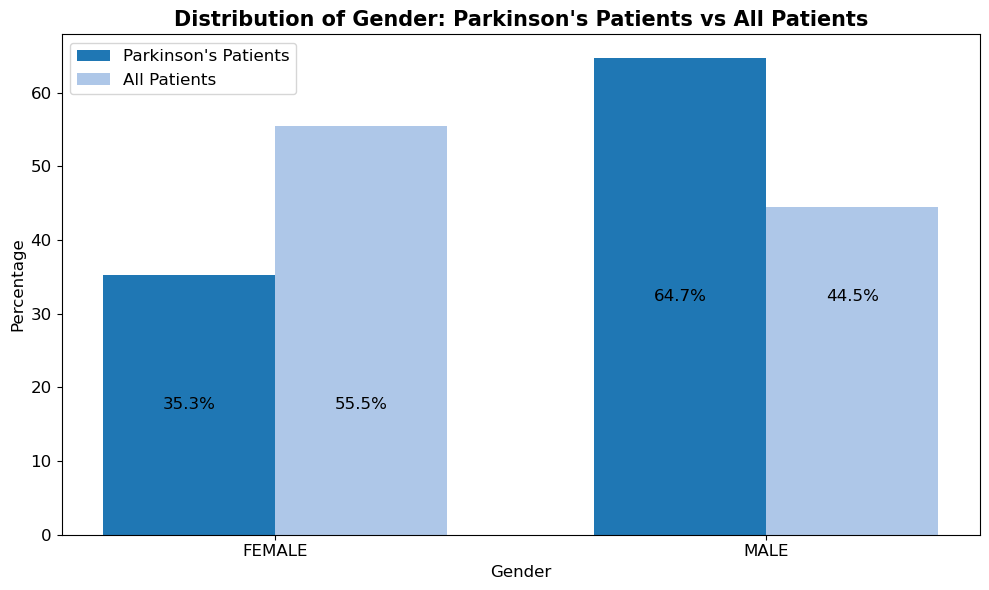

In [154]:
# Plotting the distribution of gender for PD patients vs. all patients
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "Parkinson's Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["Parkinson's Patients"], width=bar_width, label="Parkinson's Patients", color=colors[0])

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["All Patients"], width=bar_width, label="All Patients", color=colors[1])

# Set plot title and labels
ax.set_title("Distribution of Gender: Parkinson's Patients vs All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(fontsize=12)

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Add the percentage values inside each bar
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center', fontsize=12)
    ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [155]:
demographics['gender_source_value'].value_counts(normalize=False) 

MALE      185
FEMALE    101
Name: gender_source_value, dtype: int64

In [156]:
demographics_all['gender_source_value'].value_counts(normalize=False) 

FEMALE     144929
MALE       116224
UNKNOWN         1
Name: gender_source_value, dtype: int64

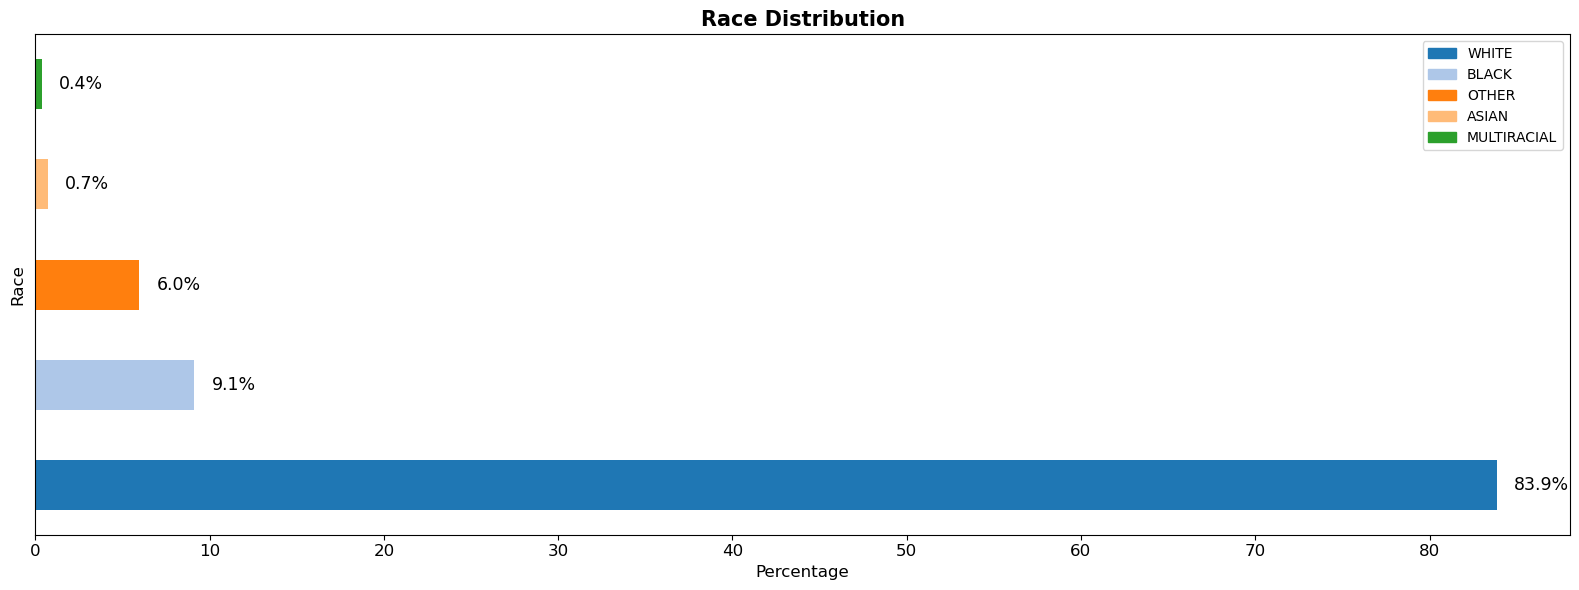

In [157]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [158]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    272
HISPANIC         14
Name: ethnicity_source_value, dtype: int64

In [159]:
race_counts

WHITE          83.859649
BLACK           9.122807
OTHER           5.964912
ASIAN           0.701754
MULTIRACIAL     0.350877
Name: race_source_value, dtype: float64

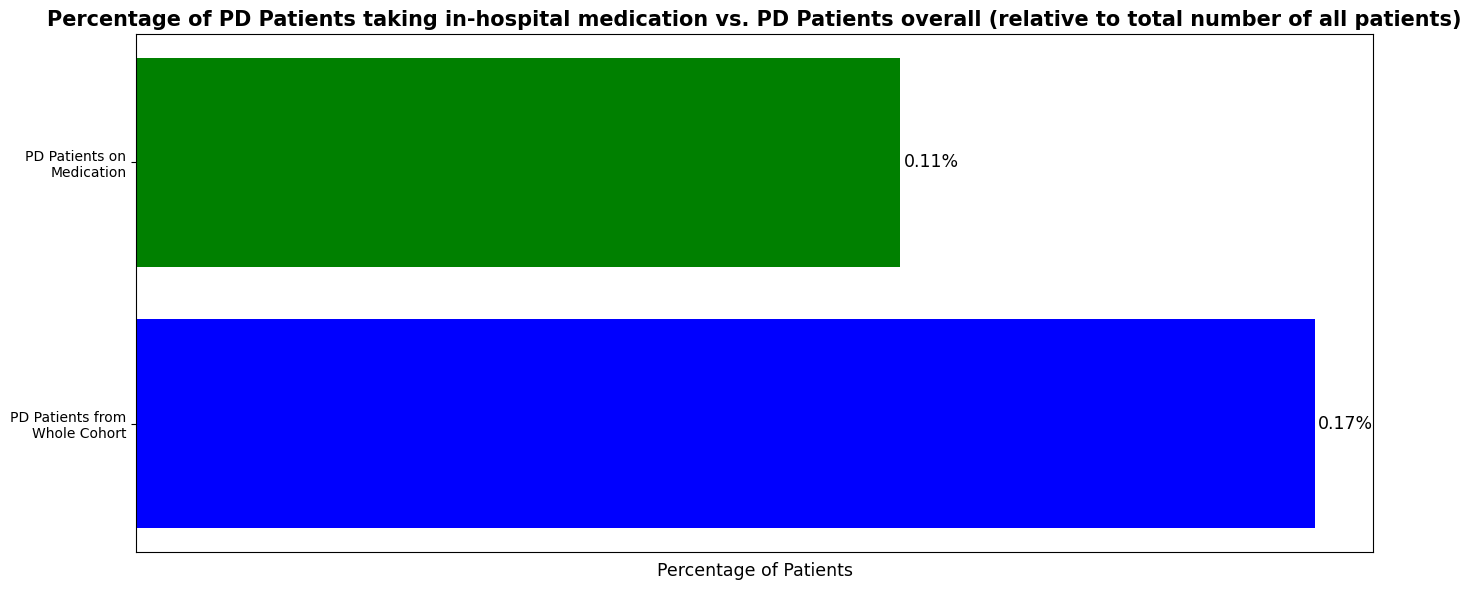

In [160]:
# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [161]:
percentage_pd_patients_df

0.1688658799022799

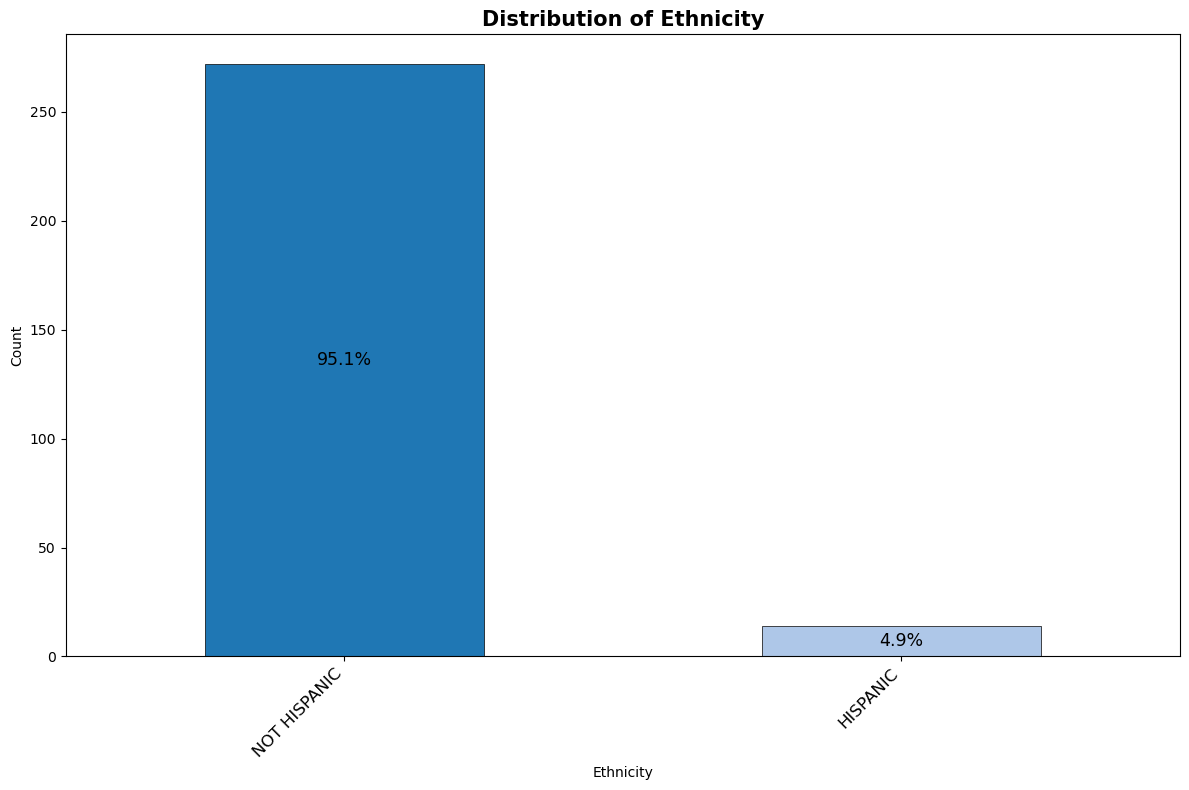

In [162]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(12, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)

# Calculate the percentages
total_count = ethnicity.sum()
percentages = [(count / total_count) * 100 for count in ethnicity]

# Display the percentages inside the bars
ax.bar_label(ax.containers[0], labels=[f"{percentage:.1f}%" for percentage in percentages], label_type='center', fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

Actual actual way to deal with this lol

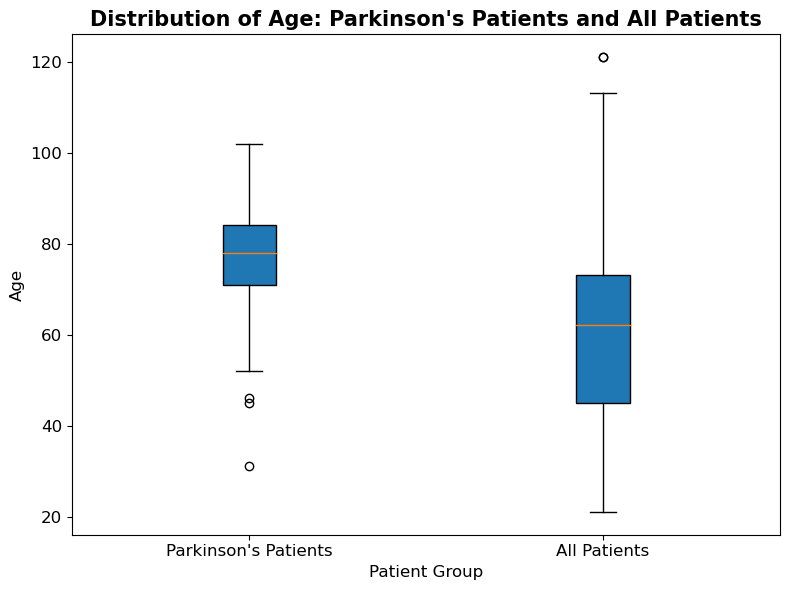

In [163]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["Parkinson's Patients", "All Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Parkinson's Patients and All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

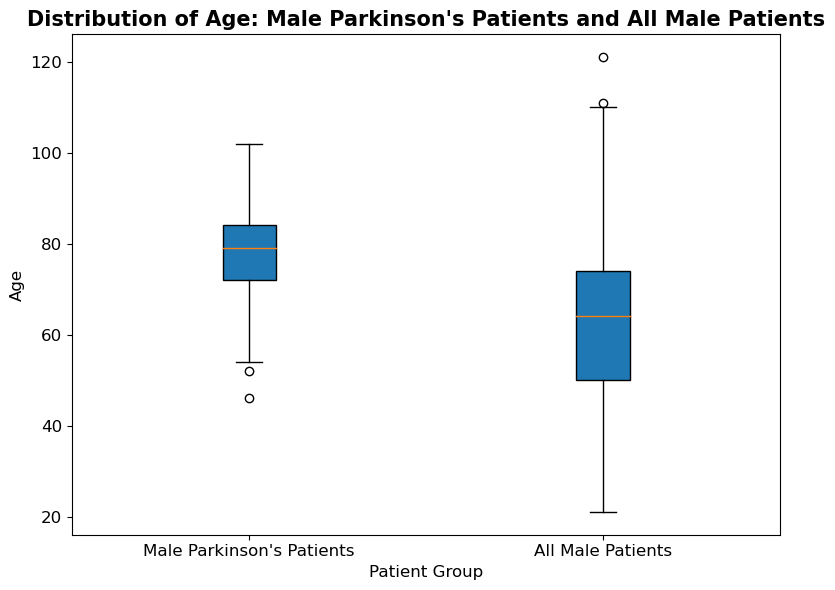

In [164]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

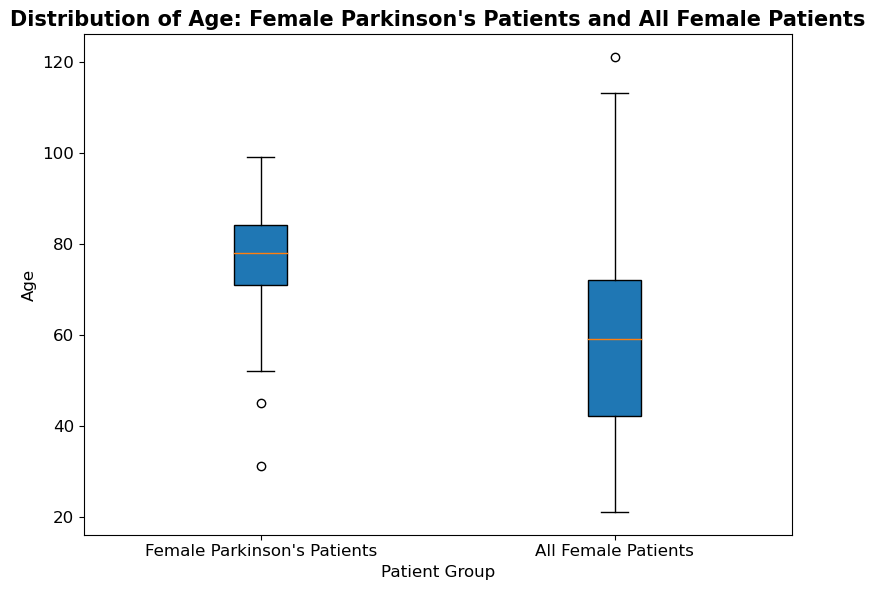

In [165]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

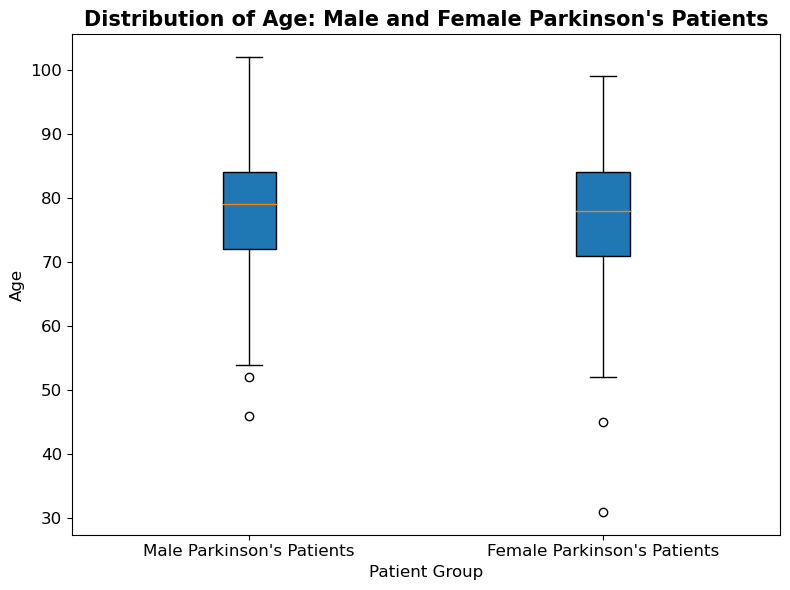

In [166]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

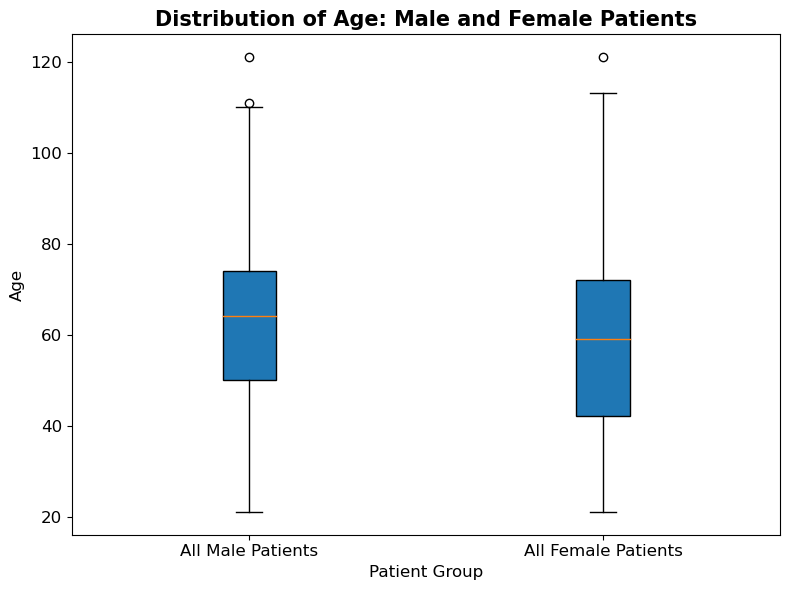

In [167]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [168]:
pd_data.value_counts(normalize=True)

generic_name                           brand_name  dosage         
carbidopa-levodopa                     sinemet     25-100 mg          0.461783
                                       sinemet cr  25-100 mg          0.065150
benztropine                            cogentin    1 mg               0.064713
amantadine                             symmetrel   100 mg             0.059850
carbidopa-levodopa                     sinemet     25-250 mg          0.050000
pramipexole                            mirapex     0.25 mg            0.044701
benztropine                            cogentin    0.5 mg             0.035287
carbidopa-levodopa                     sinemet     10-100 mg          0.034040
                                                   12.5-50 mg         0.030985
                                       sinemet cr  50-200 mg          0.030050
benztropine                            cogentin    2 mg               0.014651
entacapone                             comtan      200 mg       

In [169]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.584601
cogentin      0.120324
sinemet cr    0.095200
symmetrel     0.074751
mirapex       0.069327
comtan        0.014963
artane        0.009726
azilect       0.007107
eldepryl      0.004302
duopa         0.003491
stalevo       0.003117
parlodel      0.003055
neupro        0.002681
gocovri       0.001995
parcopa       0.001372
rytary        0.001372
requip        0.000873
lodosyn       0.000686
tasmar        0.000623
dostinex      0.000249
apokyn        0.000187
Name: brand_name, dtype: float64

## Distribution of drugs

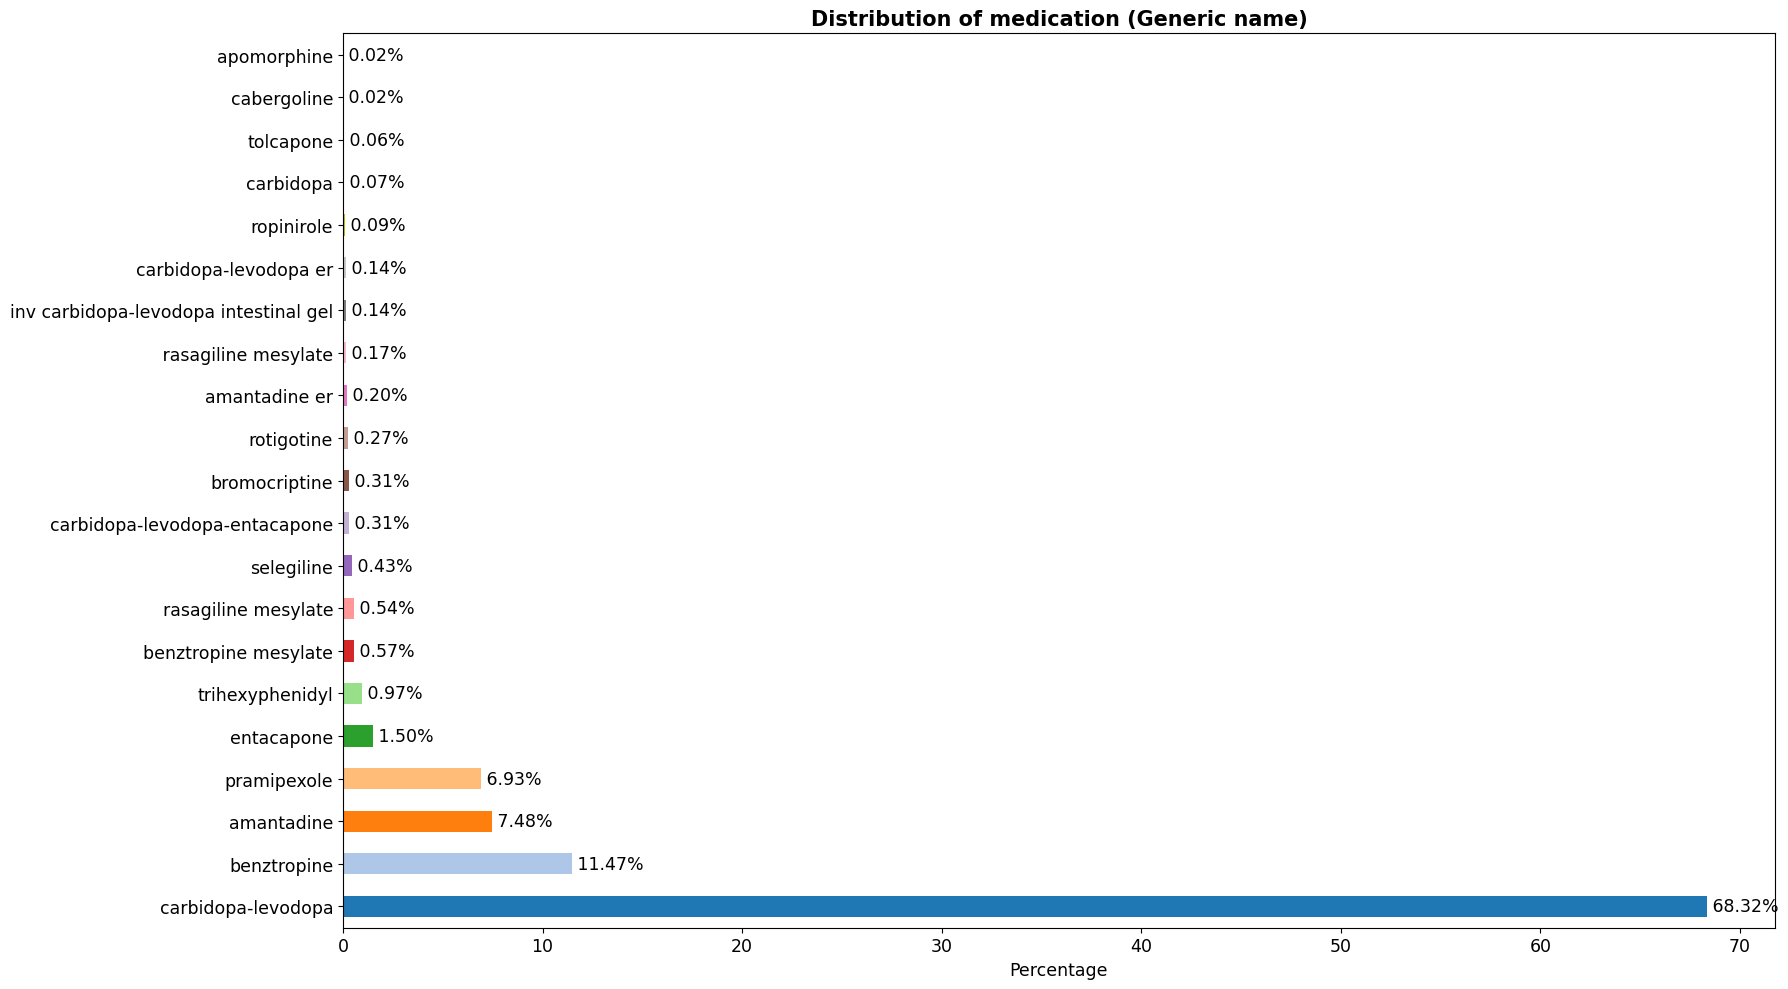

In [170]:
drug_distribution_count = df_pd['generic_name'].value_counts(normalize=True) * 100
drug_distribution = pd.DataFrame({'Percentage': drug_distribution_count})

# Sort the DataFrame by percentage in descending order
drug_distribution = drug_distribution.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_distribution['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Distribution of medication (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_distribution['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_distribution)), drug_distribution.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_distribution.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [171]:
len(pd_data) == len(df_pd)

True

In [172]:
df_pd.iloc[5187]

person_id                                                            250766
age                                                                      85
gender_source_value                                                  FEMALE
race_source_value                                                     WHITE
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "**carbidopa-levodopa 4.6...
drug_info                 **carbidopa-levodopa 4.63-20 mg/mL (DUOPA) sus...
generic_name                                             carbidopa-levodopa
brand_name                                                            duopa
dosage                                                        4.63-20 mg/ml
quantity                                                              100.0
sig                                                                   DAILY
route_source_value                                               PER J TUBE
dose_source_

In [173]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                   duopa
dosage               4.63-20 mg/ml
Name: 5187, dtype: object

In [174]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<AxesSubplot: >

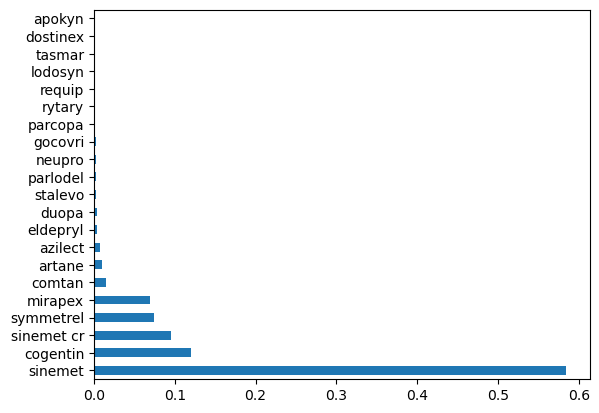

In [175]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [176]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
apokyn          1
artane          7
azilect        12
cogentin       22
comtan          8
dostinex        1
duopa           2
eldepryl        5
gocovri         1
lodosyn         4
mirapex        29
neupro          8
parcopa         2
parlodel        2
requip          3
rytary          2
sinemet       244
sinemet cr     82
stalevo         4
symmetrel      33
tasmar          1
Name: person_id, dtype: int64

In [177]:
df_pd['brand_name'].nunique()

21

In [178]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'sig',
       'route_source_value', 'dose_source_value', 'dose_unit_source_value',
       'note_text'],
      dtype='object')

In [179]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.835664
BLACK          0.090909
OTHER          0.059441
ASIAN          0.006993
MULTIRACIAL    0.003497
Name: person_id, dtype: float64

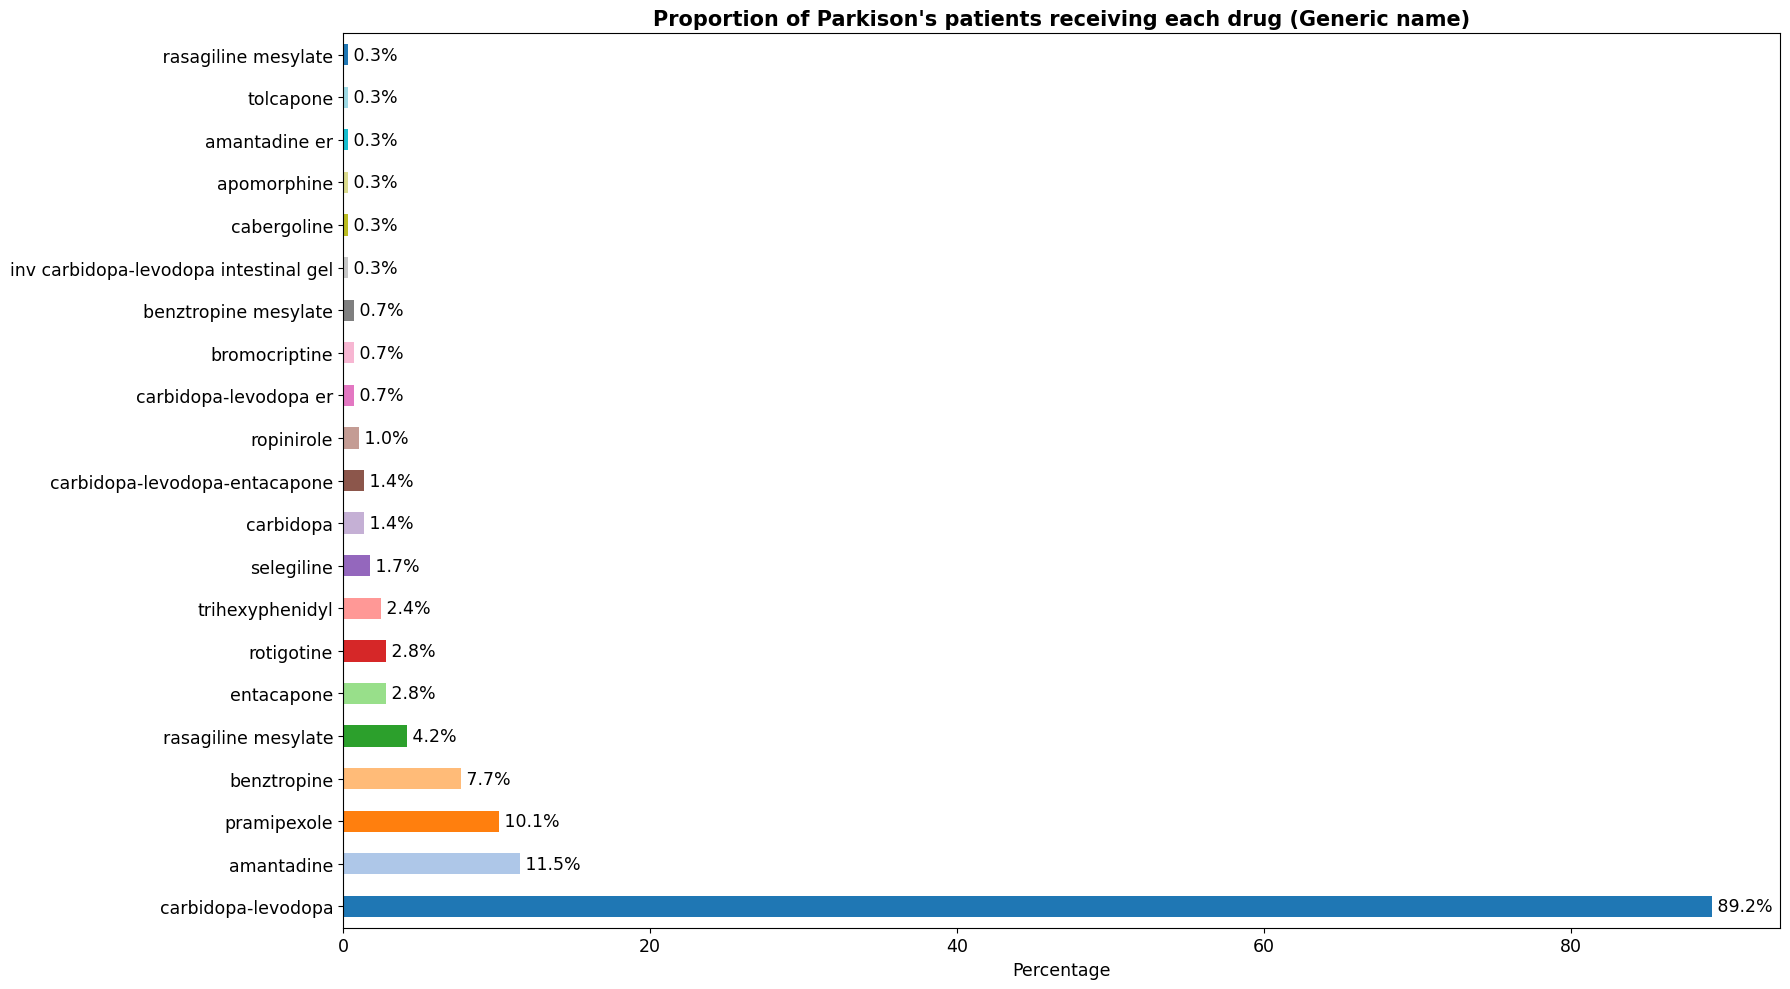

In [180]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


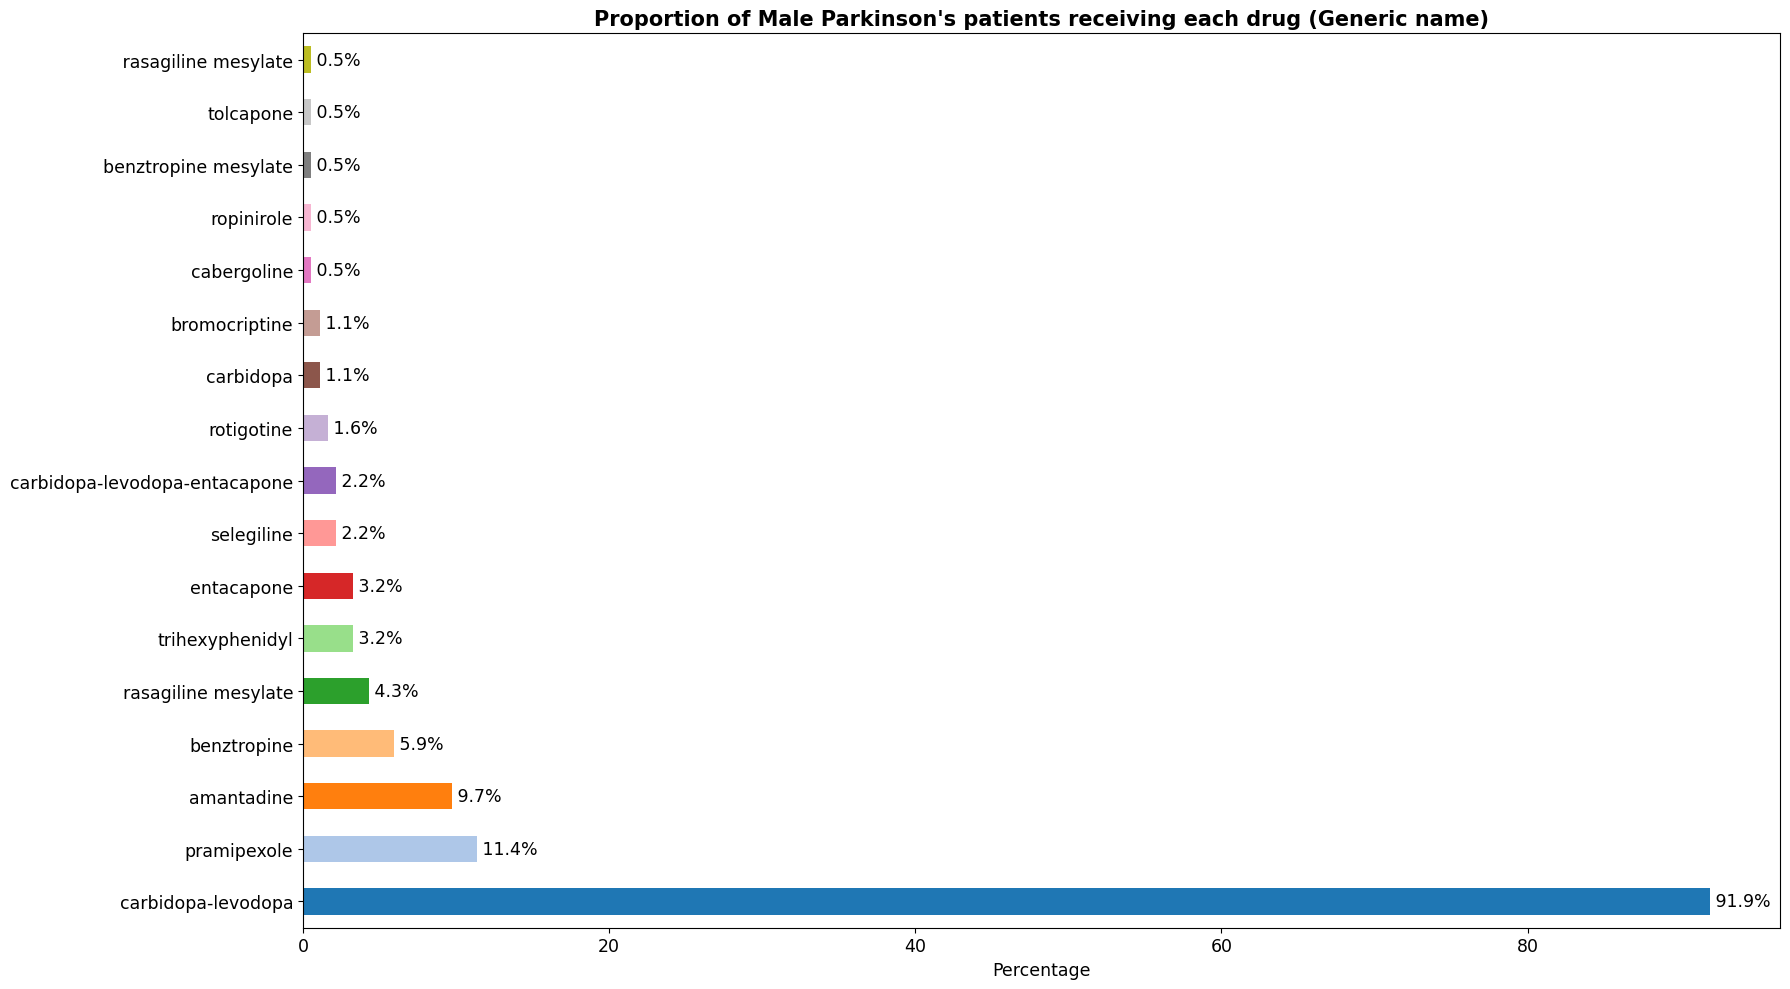

In [181]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
male_pd = df_pd[df_pd['gender_source_value'] == 'MALE']

# Calculate the drug percentage for males
male_drug_percentage = male_pd.groupby('generic_name')['person_id'].nunique() / male_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
male_drug_popularity_count = male_drug_percentage * 100
male_drug_popularity = pd.DataFrame({'Percentage': male_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
male_drug_popularity = male_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = male_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Male Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(male_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(male_drug_popularity)), male_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, male_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


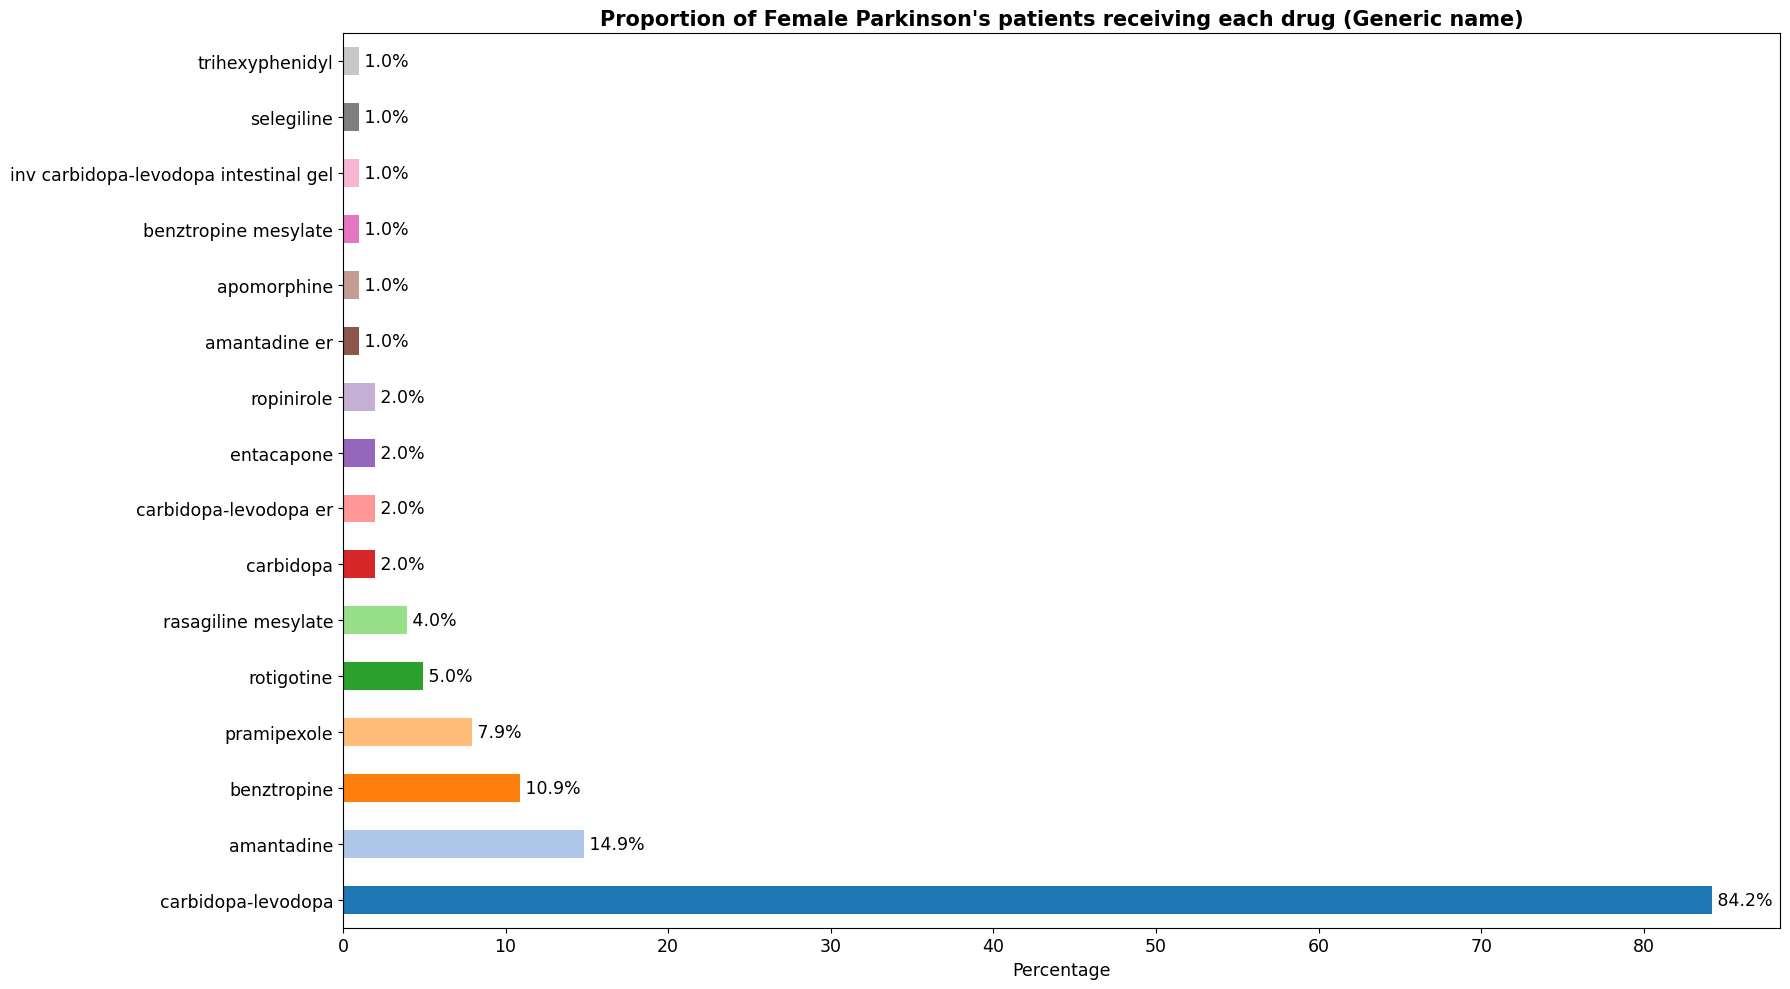

In [182]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
female_pd = df_pd[df_pd['gender_source_value'] == 'FEMALE']

# Calculate the drug percentage for males
female_drug_percentage = female_pd.groupby('generic_name')['person_id'].nunique() / female_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
female_drug_popularity_count = female_drug_percentage * 100
female_drug_popularity = pd.DataFrame({'Percentage': female_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
female_drug_popularity = female_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = female_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Female Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(female_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(female_drug_popularity)), female_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, female_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [183]:
female_drug_popularity['Percentage']

generic_name
carbidopa-levodopa                       84.158416
amantadine                               14.851485
benztropine                              10.891089
pramipexole                               7.920792
rotigotine                                4.950495
rasagiline mesylate                       3.960396
carbidopa                                 1.980198
carbidopa-levodopa er                     1.980198
entacapone                                1.980198
ropinirole                                1.980198
amantadine er                             0.990099
apomorphine                               0.990099
benztropine mesylate                      0.990099
inv carbidopa-levodopa intestinal gel     0.990099
selegiline                                0.990099
trihexyphenidyl                           0.990099
Name: Percentage, dtype: float64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


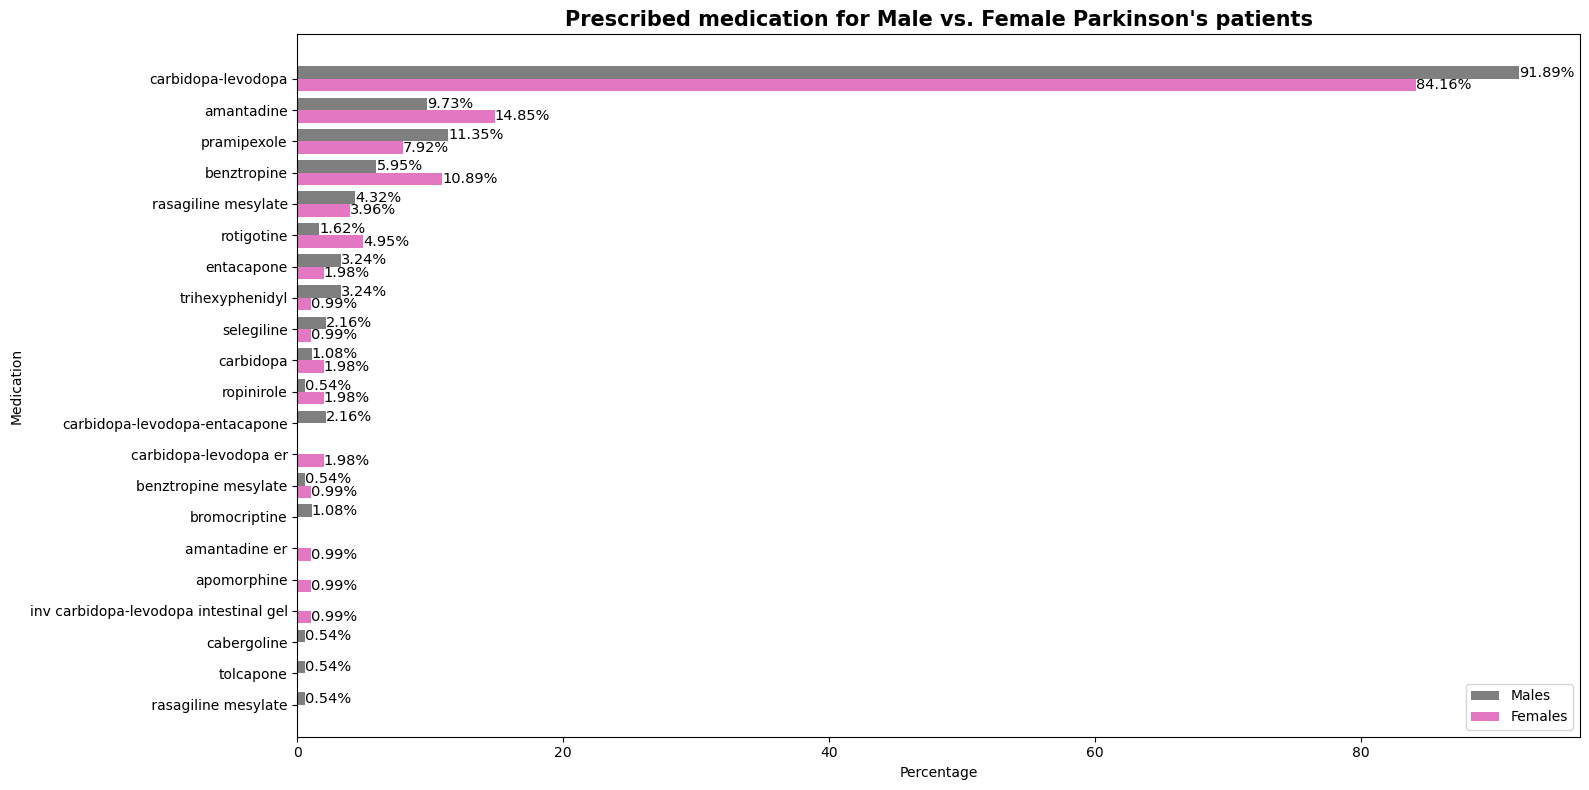

In [184]:
# Assuming you already have these variables as pandas Series
# male_drug_popularity and female_drug_popularity with 'Percentage' as the data and medication names as the index.

# Combine both male and female data for sorting
combined_data = pd.concat([male_drug_popularity, female_drug_popularity], axis=1)
combined_data.columns = ['Males', 'Females']

# Sort the medications based on the sum of percentages (sorting from higher to lower)
sorted_combined = combined_data.sum(axis=1).sort_values(ascending=False)

# Plotting the data as a horizontal bar plot
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# Increase the width of the bars and adjust figure size for better spacing
width = 0.4

# Bar plot for males
ind_male = range(len(sorted_combined))
bars_male = plt.barh(ind_male, combined_data.loc[sorted_combined.index, 'Males'], height=width, label='Males', color='tab:gray')

# Bar plot for females
ind_female = [i + width for i in ind_male]
bars_female = plt.barh(ind_female, combined_data.loc[sorted_combined.index, 'Females'], height=width, label='Females', color='tab:pink')

# Adding percentages to the side of the bars
for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Males']):
    plt.text(val, i, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Females']):
    plt.text(val, i + width, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

# Adding labels, titles, and customizing the plot
plt.xlabel('Percentage')
plt.ylabel('Medication')
plt.title('Prescribed medication for Male vs. Female Parkinson\'s patients', fontsize=15, fontweight='bold')
plt.yticks([i + width / 2 for i in ind_male], sorted_combined.index, fontsize=10)
plt.gca().invert_yaxis()
plt.legend(loc='lower right')  # Move the legend to upper right for better spacing
plt.tight_layout()
plt.show()


In [185]:
df_pd['generic_name'].value_counts(normalize=True) * 100

carbidopa-levodopa                       68.322943
benztropine                              11.465087
amantadine                                7.475062
pramipexole                               6.932668
entacapone                                1.496259
trihexyphenidyl                           0.972569
benztropine mesylate                      0.567332
rasagiline mesylate                       0.536160
selegiline                                0.430175
carbidopa-levodopa-entacapone             0.311721
bromocriptine                             0.305486
rotigotine                                0.268080
amantadine er                             0.199501
 rasagiline mesylate                      0.174564
inv carbidopa-levodopa intestinal gel     0.143392
carbidopa-levodopa er                     0.137157
ropinirole                                0.087282
carbidopa                                 0.068579
tolcapone                                 0.062344
cabergoline                    

In [186]:
drug_percentage

generic_name
 rasagiline mesylate                     0.003497
amantadine                               0.115385
amantadine er                            0.003497
apomorphine                              0.003497
benztropine                              0.076923
benztropine mesylate                     0.006993
bromocriptine                            0.006993
cabergoline                              0.003497
carbidopa                                0.013986
carbidopa-levodopa                       0.891608
carbidopa-levodopa er                    0.006993
carbidopa-levodopa-entacapone            0.013986
entacapone                               0.027972
inv carbidopa-levodopa intestinal gel    0.003497
pramipexole                              0.101399
rasagiline mesylate                      0.041958
ropinirole                               0.010490
rotigotine                               0.027972
selegiline                               0.017483
tolcapone                            

## Calculating LED (Levodopa Dose Equivalent) for Parkinson's patients

In [187]:
# sig stablished how the medication should be taken by the patient
formatted_series = df_pd['dose_source_value'].unique()
format_func = np.vectorize(lambda x: '{:.4}'.format(x))
bla = np.sort(format_func(formatted_series))
bla

array(['0.0', '0.125', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5',
       '100.0', '137.0', '2.0', '2.5', '20.0', '200.0', '25.0', '3.0',
       '32.0', '4.0', '40.0', '5.0', '50.0', '8.0', 'nan'], dtype='<U5')

In [188]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [189]:
rasagiline_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '1mg'].index
pd_data_drug_exposure.loc[rasagiline_index, 'dosage'] = '1 mg'
pd_data_drug_exposure.iloc[rasagiline_index]['dosage']

10477    1 mg
10478    1 mg
Name: dosage, dtype: object

In [190]:
entacapone_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '200mg'].index
pd_data_drug_exposure.loc[entacapone_index, 'dosage'] = '200 mg'
pd_data_drug_exposure.iloc[entacapone_index]['dosage']

13141    200 mg
13142    200 mg
13143    200 mg
13144    200 mg
13145    200 mg
13146    200 mg
13147    200 mg
13148    200 mg
13149    200 mg
13150    200 mg
13151    200 mg
13152    200 mg
13153    200 mg
13154    200 mg
13155    200 mg
13156    200 mg
13157    200 mg
13158    200 mg
13159    200 mg
13160    200 mg
13161    200 mg
13162    200 mg
13163    200 mg
13164    200 mg
13165    200 mg
13166    200 mg
13167    200 mg
13168    200 mg
13169    200 mg
13170    200 mg
Name: dosage, dtype: object

In [191]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [192]:
pd_data_drug_exposure['dosage'].unique()[0].split('-')[1].split()[0]

'100'

In [193]:
led_dose = []
for index, item in enumerate(pd_data_drug_exposure['dosage']):
    if '-' in item:
        dosage = item.split('-')[1].split()[0]
    else:
        dosage = item.split()[0]
    led_dose.append(dosage)

In [194]:
len(pd_data_drug_exposure)

26946

In [195]:
set(sorted(led_dose))

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [196]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if 'levodopa-carbidopa' in item:
        print(item)

In [197]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [198]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
26941  carbidopa-levodopa    sinemet  25-100 mg
26942  carbidopa-levodopa    sinemet  25-100 mg
26943  carbidopa-levodopa    sinemet  25-100 mg
26944  carbidopa-levodopa    sinemet  25-100 mg
26945  carbidopa-levodopa    sinemet  25-100 mg

[26946 rows x 3 columns]

In [199]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [200]:
led_df = pd.concat([drug_exposure.iloc[:, 0:3], pd_data_drug_exposure, drug_exposure.iloc[:, 3:]], axis=1)

In [201]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value        generic_name  \
0      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
1      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
2      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
3      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
4      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
...                                                  ...                 ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
26942  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
26943  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
26944  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
26945  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   

      brand_name     dosage  dose_source_value dose_unit_source_value  \
0        sinemet  25-100 mg                2.0                 tablet   
1        sinemet  25-100 mg                2.0                 tablet   
2        sinemet  25-100 mg                2.0                 tablet   
3        sinemet  25-100 mg                2.0                 tablet   
4        sinemet  25-100 mg                2.0                 tablet   
...          ...        ...                ...                    ...   
26941    sinemet  25-100 mg                1.0                 tablet   
26942    sinemet  25-100 mg                1.0                 tablet   
26943    sinemet  25-100 mg                1.0                 tablet   
26944    sinemet  25-100 mg                0.0                 tablet   
26945    sinemet  25-100 mg                0.0                 tablet   

      route_source_value  visit_occurrence_id  visit_detail_id  
0                   ORAL             40422623        9880783.0  
1                   ORAL             40422623        9880783.0  
2                   ORAL             40422623        9880783.0  
3                   ORAL             40422623        9880783.0  
4                   ORAL             40422623        9880783.0  
...                  ...                  ...              ...  
26941               ORAL             27807633        6375345.0  
26942               ORAL             27807633        6375345.0  
26943               ORAL             27807633        6375345.0  
26944               ORAL             27807633        6375345.0  
26945               ORAL             27807633        6375345.0  

[26946 rows x 11 columns]

In [202]:
led_df.insert(loc=6, column="led_dose", value=led_dose)
led_df.insert(loc=3, column="drug_info", value=drug_info_drug_source_value)
# Properly handling the led_dose and drug_exposure_start_datetime colums
led_df['led_dose'] = pd.to_numeric(led_df['led_dose'], errors='coerce') # Coverting this column to a float type and handling uncommon values
led_df['drug_exposure_start_datetime'] = pd.to_datetime(led_df['drug_exposure_start_datetime'])

In [203]:
len(drug_exposure)

26946

In [204]:
len(pd_data_drug_exposure)

26946

In [205]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [206]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...   
26942  {"med_display_name": "carbidopa-levodopa (SINE...   
26943  {"med_display_name": "carbidopa-levodopa (SINE...   
26944  {"med_display_name": "carbidopa-levodopa (SINE...   
26945  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
26941  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26942  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26943  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26944  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26945  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
26941    sinemet  25-100 mg     100.0                1.0   
26942    sinemet  25-100 mg     100.0                1.0   
26943    sinemet  25-100 mg     100.0                1.0   
26944    sinemet  25-100 mg     100.0                0.0   
26945    sinemet  25-100 mg     100.0                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  


Esta bieeeeeeeeeeeeeeeeeeen y funciona

In [207]:
dl = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, tem in enumerate(dl):
    print(index, led_df['person_id'].iloc[index], dl[index]['mar_action'], led_df['drug_source_value'].iloc[index])
len(dl)

0 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
1 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
2 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
3 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
4 261006 HELD {"med_display_name": "

953

In [208]:
type(led_df[led_df['dose_source_value'] == 0.0]['drug_source_value'])

pandas.core.series.Series

In [209]:
type(led_df.loc[led_df['dose_source_value'] == 0.0, ['drug_source_value']])

pandas.core.frame.DataFrame

In [210]:
bla = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, item in enumerate(bla):
    print(bla[index]['mar_action'])

HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD


We lose 59% percent of patients because their medication was held

In [211]:
print(len(dl)*100/len(df_pd))

5.94139650872818


In [212]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [213]:
pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '0.5 mg']

generic_name brand_name  dosage
88     benztropine   cogentin  0.5 mg
89     benztropine   cogentin  0.5 mg
90     benztropine   cogentin  0.5 mg
91     benztropine   cogentin  0.5 mg
92     benztropine   cogentin  0.5 mg
...            ...        ...     ...
24965   ropinirole     requip  0.5 mg
24966   ropinirole     requip  0.5 mg
24967   ropinirole     requip  0.5 mg
24968   ropinirole     requip  0.5 mg
24969   ropinirole     requip  0.5 mg

[743 rows x 3 columns]

In [214]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [215]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [216]:
set(led_dose)

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [217]:
led_df['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [218]:
led_df[(led_df['brand_name'] == 'rytary') & (led_df['generic_name'] == 'carbidopa-levodopa')]

person_id drug_exposure_start_datetime  \
3633     256628          2017-01-24 01:00:00   
3634     256628          2017-01-31 21:33:00   

                                      drug_source_value  \
3633  {"med_display_name": "carbidopa-levodopa (SINE...   
3634  {"med_display_name": "carbidopa-levodopa (SINE...   

                                              drug_info        generic_name  \
3633  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3634  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

     brand_name     dosage  led_dose  dose_source_value  \
3633     rytary  25-100 mg     100.0                1.0   
3634     rytary  25-100 mg     100.0                1.0   

     dose_unit_source_value route_source_value  visit_occurrence_id  \
3633                 tablet               ORAL             39519189   
3634                 tablet               ORAL             39519190   

      visit_detail_id  
3633        9635043.0  
3634        9635045.0

In [219]:
led_df[led_df['dose_unit_source_value'] == 'tablet']['dose_source_value']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
26941    1.0
26942    1.0
26943    1.0
26944    0.0
26945    0.0
Name: dose_source_value, Length: 20044, dtype: float64

In [220]:
led_df[led_df['dose_unit_source_value'] == 'each']#['dose_source_value'].unique()

person_id drug_exposure_start_datetime  \
8143     245457          2013-03-15 23:27:00   
8144     245457          2013-03-16 23:39:00   
8145     245457          2013-03-17 23:15:00   
8146     245457          2013-03-18 23:00:00   
8147     245457          2013-03-19 23:26:00   
8148     245457          2013-03-21 00:00:00   
8149     245457          2013-03-21 23:14:00   

                                      drug_source_value  \
8143  {"med_display_name": "Inv levodopa-carbidopa i...   
8144  {"med_display_name": "Inv levodopa-carbidopa i...   
8145  {"med_display_name": "Inv levodopa-carbidopa i...   
8146  {"med_display_name": "Inv levodopa-carbidopa i...   
8147  {"med_display_name": "Inv levodopa-carbidopa i...   
8148  {"med_display_name": "Inv levodopa-carbidopa i...   
8149  {"med_display_name": "Inv levodopa-carbidopa i...   

                                            drug_info  \
8143  Inv levodopa-carbidopa intestinal gel pump stop   
8144  Inv levodopa-carbidopa intestinal gel pump stop   
8145  Inv levodopa-carbidopa intestinal gel pump stop   
8146  Inv levodopa-carbidopa intestinal gel pump stop   
8147  Inv levodopa-carbidopa intestinal gel pump stop   
8148  Inv levodopa-carbidopa intestinal gel pump stop   
8149  Inv levodopa-carbidopa intestinal gel pump stop   

                                    generic_name brand_name      dosage  \
8143  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8144  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8145  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8146  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8147  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8148  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8149  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   

      led_dose  dose_source_value dose_unit_source_value route_source_value  \
8143      20.0                NaN                   each         PEG-J TUBE   
8144      20.0                NaN                   each         PEG-J TUBE   
8145      20.0                NaN                   each         PEG-J TUBE   
8146      20.0                NaN                   each         PEG-J TUBE   
8147      20.0                NaN                   each         PEG-J TUBE   
8148      20.0                0.0                   each         PEG-J TUBE   
8149      20.0                0.0                   each         PEG-J TUBE   

      visit_occurrence_id  visit_detail_id  
8143             37041564        8941399.0  
8144             37041564        8941399.0  
8145             37041564        8941399.0  
8146             37041564        8941399.0  
8147             37041564        8941399.0  
8148             37041564        8941399.0  
8149             37041564        8941399.0

In [221]:
led_df[led_df['dose_unit_source_value'] != 'tablet'].sample(20)

person_id drug_exposure_start_datetime  \
3381      256706          2020-11-16 09:34:00   
6474      249643          2013-12-04 08:48:00   
9532      229161          2015-03-05 20:24:00   
13909     216583          2014-08-31 17:28:00   
13330     216583          2014-12-24 08:55:00   
7132      247869          2016-03-10 20:05:00   
5788      252405          2021-03-10 22:26:00   
18562     205200          2016-10-14 20:40:00   
22579     201023          2017-09-30 17:37:00   
6581      249161          2020-04-15 12:47:28   
5261      253316          2017-10-08 20:45:00   
22478     201023          2017-09-14 05:23:00   
9526      229161          2015-03-02 20:47:00   
3621      256628          2018-03-12 04:45:00   
22663     201023          2017-06-12 13:40:00   
9508      229161          2015-02-20 21:26:00   
19867     203593          2015-11-21 14:13:00   
20733     202164          2019-11-29 12:49:00   
24090     187800          2015-09-19 08:02:00   
24128     187800          2015-10-11 21:59:00   

                                       drug_source_value  \
3381   {"med_display_name": "benztropine (COGENTIN) t...   
6474   {"med_display_name": "rOPINIRole (REQUIP XL) 2...   
9532   {"med_display_name": "amantadine (SYMMETREL) s...   
13909  {"med_display_name": "pramipexole (MIRAPEX) ta...   
13330  {"med_display_name": "entacapone (COMTAN) tabl...   
7132   {"med_display_name": "benztropine (COGENTIN) t...   
5788   {"med_display_name": "entacapone (COMTAN) tabl...   
18562  {"med_display_name": "amantadine (SYMMETREL) c...   
22579  {"med_display_name": "entacapone (COMTAN) tabl...   
6581   {"med_display_name": "rOPINIRole (REQUIP) tabl...   
5261   {"med_display_name": "rOPINIRole (REQUIP) tabl...   
22478  {"med_display_name": "entacapone (COMTAN) tabl...   
9526   {"med_display_name": "amantadine (SYMMETREL) s...   
3621   {"med_display_name": "*Carbidopa-Levodopa ER 4...   
22663  {"med_display_name": "pramipexole (MIRAPEX) ta...   
9508   {"med_display_name": "amantadine (SYMMETREL) s...   
19867  {"med_display_name": "rOPINIRole (REQUIP) tabl...   
20733  {"med_display_name": "selegiline (ELDEPRYL) ca...   
24090  {"med_display_name": "trihexyphenidyl (ARTANE)...   
24128  {"med_display_name": "trihexyphenidyl (ARTANE)...   

                                               drug_info  \
3381                  benztropine (COGENTIN) tablet 1 mg   
6474            rOPINIRole (REQUIP XL) 24 hr tablet 8 mg   
9532              amantadine (SYMMETREL) solution 100 mg   
13909              pramipexole (MIRAPEX) tablet 0.125 mg   
13330                  entacapone (COMTAN) tablet 200 mg   
7132                benztropine (COGENTIN) tablet 0.5 mg   
5788                   entacapone (COMTAN) tablet 200 mg   
18562              amantadine (SYMMETREL) capsule 100 mg   
22579                  entacapone (COMTAN) tablet 200 mg   
6581                     rOPINIRole (REQUIP) tablet 2 mg   
5261                  rOPINIRole (REQUIP) tablet 0.25 mg   
22478                  entacapone (COMTAN) tablet 200 mg   
9526              amantadine (SYMMETREL) solution 100 mg   
3621   *Carbidopa-Levodopa ER 48.75-195 MG CPCR 1 cap...   
22663                pramipexole (MIRAPEX) tablet 1.5 mg   
9508              amantadine (SYMMETREL) solution 100 mg   
19867                 rOPINIRole (REQUIP) tablet 0.25 mg   
20733                 selegiline (ELDEPRYL) capsule 5 mg   
24090               trihexyphenidyl (ARTANE) tablet 2 mg   
24128               trihexyphenidyl (ARTANE) tablet 2 mg   

                generic_name brand_name        dosage  led_dose  \
3381             benztropine   cogentin          1 mg     1.000   
6474              ropinirole  requip xl          8 mg     8.000   
9532              amantadine  symmetrel        100 mg   100.000   
13909            pramipexole    mirapex      0.125 mg     0.125   
13330             entacapone     comtan        200 mg   200.000   
7132             benztropine   cogentin        0.5 mg

Difference betwen ryrary and duopa??
Rytary is carbidopa-levodopa extended release and suopa is carbidopa-levodopa enteral suspension

In [222]:
sorted(led_df['generic_name'].unique())

[' rasagiline mesylate',
 'amantadine',
 'amantadine er',
 'apomorphine',
 'benztropine',
 'benztropine mesylate',
 'bromocriptine',
 'cabergoline',
 'carbidopa',
 'carbidopa-levodopa',
 'carbidopa-levodopa er',
 'carbidopa-levodopa-entacapone',
 'entacapone',
 'inv carbidopa-levodopa intestinal gel',
 'inv carbidopa-levodopa intestinal gel pump',
 'pramipexole',
 'pramipexole er',
 'rasagiline',
 'rasagiline mesylate',
 'ropinirole',
 'rotigotine',
 'selegiline',
 'tolcapone',
 'trihexyphenidyl']

Setting conversion factors for Parkinson's drugs and calculating LED

In [223]:
# Conversion factors from: https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.29410
conversion_factors = {
    'amantadine': 1.0,
    'amantadine er': 1.25, 
    'apomorphine': 10.0,
    # trihexyphenidyl and benztropine aren't as unified but the paper proposes a conversion factor of 1
    'benztropine': 1.0,
    'benztropine mesylate': 1.0,
    'bromocriptine': 10.0,
    'cabergoline': 66.7,
    'carbidopa-levodopa': 1.0,
    'inv carbidopa-levodopa intestinal gel': 1.0,
    'inv carbidopa-levodopa intestinal gel pump': 1.0,
    'carbidopa': 0.1,
    'carbidopa-levodopa er': 0.5,
    'carbidopa-levodopa-entacapone': 1.33,
    'entacapone': 1.33, # Double-check this
    'pramipexole': 100.0,
    'pramipexole er': 100.0,
    'trihexyphenidyl': 1.0,
    'rasagiline': 100.0,
    ' rasagiline mesylate': 100.0,
    'ropinirole': 20.0,
    'rotigotine': 30.0, 
    'selegiline': 10.0, # All the rows relating to selegiline are oral
    'tolcapone': 1.5,
    'ropinirole': 0.5,
}

# Convert 'drug_exposure_start_datetime' to datetime format
def calculate_led(row):
    """ The logic goes as follows: We will map the conversion factors to the generic_name found in the led_df dataframe. All of the generic_names are contained into the dictionary.
    We check the led_dose calculated. If it's equal to the dose_source_value it means that the medication is probably carbidopa-levodopa, so we will skip it and we do that by setting dose_source_value to 1.
    That way when we multiply it will be as if nothing happened.

    Then we check if dose_source_value is zero. If that happends, then that drug was not administered but held (look at mar_action in the drug_source column). If it's zero we put the equivalent to np.nan into that row

    If everything goes well and the dose_source_value is actually something we can work with, then the led will be the multiplication of the dose_sourve_value, the led_dose and the conversion factor

    If the dose_source_value is something we can't work with, the led will exclude that info from the multiplication.

    At the end we apply the function into a new column called led. 
    """
    dose_source_value = row['dose_source_value']
    led_dose = row['led_dose']
    conversion_factor = conversion_factors.get(row['generic_name'], 0)
    if led_dose == dose_source_value:
        dose_source_value = 1.0
    if dose_source_value == 0.0:
        return None
    if pd.notna(dose_source_value):
        return dose_source_value * row['led_dose'] * conversion_factor
    else:
        return row['led_dose'] * conversion_factor

led_df['led'] = led_df.apply(calculate_led, axis=1)

Adding diagnosis date

In [224]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...   
26942  {"med_display_name": "carbidopa-levodopa (SINE...   
26943  {"med_display_name": "carbidopa-levodopa (SINE...   
26944  {"med_display_name": "carbidopa-levodopa (SINE...   
26945  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
26941  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26942  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26943  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26944  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26945  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
26941    sinemet  25-100 mg     100.0                1.0   
26942    sinemet  25-100 mg     100.0                1.0   
26943    sinemet  25-100 mg     100.0                1.0   
26944    sinemet  25-100 mg     100.0                0.0   
26945    sinemet  25-100 mg     100.0                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id    led  
0            9880783.0  200.0  
1            9880783.0  200.0  
2            9880783.0  200.0  
3            9880783.0

In [225]:
diagnosis_date = pd.read_csv('data/DIAGNOSIS_DATE.csv')
diagnosis_date["diagnosis_date"] = pd.to_datetime(diagnosis_date["diagnosis_date"], format='%Y-%m-%d')

# led_df = led_df.merge(diagnosis_date, on='person_id', how='inner')
# led_df = led_df[['person_id', 'drug_exposure_start_datetime', 'diagnosis_date', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'led_dose', 'dose_source_value', 'dose_unit_source_value', 'route_source_value','visit_occurrence_id', 'visit_detail_id', 'led']]

Different kinds of LED by patient, administration date, drug, and visit

In [226]:
# We use the aggreagte function to find the min and max date of drugs being administered
# TODO: Estoy usando el min y el max de la fecha de administracion de la droga, pero deberia usar el min y el max de la fecha de la visita
patient_stay = led_df.groupby('person_id')['drug_exposure_start_datetime'].agg(['min', 'max']).reset_index()
# Compute the mean LED per patiient
mean_led_per_patient = led_df.groupby('person_id')['led'].mean().reset_index() # Mean LED per patient
mean_led_per_administration_date= led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()
mean_led_per_drug = led_df.groupby(['person_id', led_df['generic_name']])['led'].mean().reset_index()
# mean_led_per_visit = led_df.groupby(['person_id', led_df['visit_occurrence_id']])['led'].mean().reset_index()
# Assing the mean LED to the DataFrame
patient_stay['mean_led_per_patient'] = mean_led_per_patient['led']
patient_stay['mean_led_per_administration_date'] = mean_led_per_administration_date['led']
patient_stay['mean_led_per_drug'] = mean_led_per_drug['led']
# patient_stay['mean_led_per_visit'] = mean_led_per_visit['led']
# Compute and add the patient stay in format days and hours, and patient stay in years
patient_stay['stay'] = patient_stay['max'] - patient_stay['min']
patient_stay['stay_in_years'] = (patient_stay['max'] - patient_stay['min']) / np.timedelta64(1, 'Y')
# Sort values by patient stay
# patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug', 'mean_led_per_visit' ]].sort_values(by=['stay_in_years'], ascending=False)
patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug' ]].sort_values(by=['stay_in_years'], ascending=False)

In [227]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
111     216583 3348 days 19:06:00       9.168692            136.266748   
229     253410 3308 days 21:15:00       9.059421            195.942408   
98      213120 3169 days 17:29:00       8.678422            135.135135   
104     215395 2974 days 14:46:00       8.144220            168.950820   
142     222938 2901 days 22:36:00       7.945246             54.424569   
..         ...                ...            ...                   ...   
3       176462    0 days 03:23:00       0.000386            100.000000   
72      203402    0 days 02:23:00       0.000272             80.000000   
213     250583    0 days 00:00:00       0.000000            100.000000   
125     220744    0 days 00:00:00       0.000000            100.000000   
129     221162    0 days 00:00:00       0.000000                   NaN   

     mean_led_per_administration_date  mean_led_per_drug  
111                             100.0         200.000000  
229                             212.5          99.206349  
98                              250.0         107.692308  
104                             250.0         100.000000  
142                             250.0         135.135135  
..                                ...                ...  
3                                50.0         100.000000  
72                              100.0           0.500000  
213                             250.0           0.500000  
125                             250.0         100.000000  
129                             250.0         100.000000  

[286 rows x 6 columns]

In [228]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0        175605                   2017-05-31  100.0
1        175605                   2017-06-01  100.0
2        175605                   2017-06-02  100.0
3        175605                   2017-06-06   50.0
4        175605                   2017-06-07   50.0
...         ...                          ...    ...
6547     260996                   2013-05-28  100.0
6548     260996                   2013-05-29  100.0
6549     260996                   2013-05-30  100.0
6550     261006                   2021-04-11  200.0
6551     261006                   2021-04-12  200.0

[6552 rows x 3 columns]

In [229]:
mean_led_per_drug

person_id        generic_name         led
0       175605  carbidopa-levodopa   56.687898
1       175744  carbidopa-levodopa  100.000000
2       176417  carbidopa-levodopa  100.000000
3       176462         pramipexole  100.000000
4       176706  carbidopa-levodopa  200.000000
..         ...                 ...         ...
431     260956  carbidopa-levodopa  159.375000
432     260996          amantadine  100.000000
433     260996         benztropine    0.500000
434     260996  carbidopa-levodopa  105.335157
435     261006  carbidopa-levodopa  200.000000

[436 rows x 3 columns]

In [230]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
111     216583 3348 days 19:06:00       9.168692            136.266748   
229     253410 3308 days 21:15:00       9.059421            195.942408   
98      213120 3169 days 17:29:00       8.678422            135.135135   
104     215395 2974 days 14:46:00       8.144220            168.950820   
142     222938 2901 days 22:36:00       7.945246             54.424569   
..         ...                ...            ...                   ...   
3       176462    0 days 03:23:00       0.000386            100.000000   
72      203402    0 days 02:23:00       0.000272             80.000000   
213     250583    0 days 00:00:00       0.000000            100.000000   
125     220744    0 days 00:00:00       0.000000            100.000000   
129     221162    0 days 00:00:00       0.000000                   NaN   

     mean_led_per_administration_date  mean_led_per_drug  
111                             100.0         200.000000  
229                             212.5          99.206349  
98                              250.0         107.692308  
104                             250.0         100.000000  
142                             250.0         135.135135  
..                                ...                ...  
3                                50.0         100.000000  
72                              100.0           0.500000  
213                             250.0           0.500000  
125                             250.0         100.000000  
129                             250.0         100.000000  

[286 rows x 6 columns]

In [231]:
years_of_stay = patient_stay[patient_stay['stay_in_years'] >= 6]
years_of_stay_person_id = years_of_stay['person_id'].tolist()

In [232]:
led_df[led_df['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime  \
12421     216583          2011-05-31 17:00:00   
12422     216583          2011-05-31 21:00:00   
12423     216583          2011-06-01 08:20:00   
12424     216583          2011-06-01 12:22:00   
12425     216583          2011-06-01 17:16:00   
...          ...                          ...   
13799     216583          2020-07-31 07:58:00   
12998     216583          2020-07-31 07:59:00   
14387     216583          2020-07-31 12:06:00   
12933     216583          2020-07-31 12:06:00   
13800     216583          2020-07-31 12:06:00   

                                       drug_source_value  \
12421  {"med_display_name": "carbidopa-levodopa (SINE...   
12422  {"med_display_name": "carbidopa-levodopa (SINE...   
12423  {"med_display_name": "carbidopa-levodopa (SINE...   
12424  {"med_display_name": "carbidopa-levodopa (SINE...   
12425  {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
13799  {"med_display_name": "entacapone (COMTAN) tabl...   
12998  {"med_display_name": "carbidopa-levodopa (SINE...   
14387  {"med_display_name": "pramipexole (MIRAPEX) ta...   
12933  {"med_display_name": "carbidopa-levodopa (SINE...   
13800  {"med_display_name": "entacapone (COMTAN) tabl...   

                                               drug_info        generic_name  \
12421  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
12422  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
12423  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
12424  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
12425  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
13799                  entacapone (COMTAN) tablet 200 mg          entacapone   
12998  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
14387              pramipexole (MIRAPEX) tablet 0.125 mg         pramipexole   
12933  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
13800                  entacapone (COMTAN) tablet 200 mg          entacapone   

      brand_name     dosage  led_dose  dose_source_value  \
12421    sinemet  25-100 mg   100.000              1.000   
12422    sinemet  25-100 mg   100.000              1.000   
12423    sinemet  25-100 mg   100.000              1.000   
12424    sinemet  25-100 mg   100.000              1.000   
12425    sinemet  25-100 mg   100.000              1.000   
...          ...        ...       ...                ...   
13799     comtan     200 mg   200.000            200.000   
12998    sinemet  25-100 mg   100.000              1.500   
14387    mirapex   0.125 mg     0.125              0.125   
12933    sinemet  25-100 mg   100.000              1.000   
13800     comtan     200 mg   200.000            200.000   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
12421                 tablet               ORAL             33394388   
12422                 tablet               ORAL             33394388   
12423                 tablet               ORAL             33394388   
12424                 tablet               ORAL             33394388   
12425                 tablet               ORAL             33394388   
...                      ...                ...                  ...   
13799                     mg               ORAL             33418398   
12998                 tablet               ORAL             33418398   
14387                     mg               ORAL             33418398   
12933                 tablet               ORAL             33418398   
13800                     mg               ORAL             33418398   

       visit_detail_id    led  
12421              NaN  100.0  
12422              NaN  100.0  
12423              NaN  100.0  
12424              NaN

In [233]:
mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime         led
2812     216583                   2011-05-31  100.000000
2813     216583                   2011-06-01  100.000000
2814     216583                   2011-06-02  100.000000
2815     216583                   2011-06-03  100.000000
2816     216583                   2011-06-04  100.000000
...         ...                          ...         ...
3050     216583                   2020-07-27  145.590909
3051     216583                   2020-07-28  145.590909
3052     216583                   2020-07-29  145.590909
3053     216583                   2020-07-30  145.590909
3054     216583                   2020-07-31  134.500000

[243 rows x 3 columns]

In [234]:
diagnosis_date[diagnosis_date['person_id'].isin(years_of_stay_person_id)]

person_id diagnosis_date condition_poa
56      257569     2016-03-30           NaN
57      257569     2016-04-27          True
105     253410     2016-03-31           NaN
106     253410     2016-03-14          True
119     252548     2016-06-20           NaN
120     252548     2016-09-09          True
155     249161     2015-11-14          True
184     243410     2016-02-02           NaN
185     243410     2018-01-03          True
229     235373     2019-07-25           NaN
230     235373     2019-11-19          True
239     230650     2017-12-30          True
264     222938     2015-10-31           NaN
265     222938     2016-10-13          True
301     220195     2015-10-31           NaN
302     220195     2016-05-04          True
319     216583     2015-10-14           NaN
320     216583     2017-08-24          True
333     215395     2020-02-07           NaN
334     215395     2017-06-13          True
345     213120     2016-01-13           NaN
346     213120     2017-11-22          True
349     212715     2018-10-24           NaN
350     212715     2018-10-24          True
363     209423     2019-07-02           NaN
364     209423     2020-11-11          True
449     196471     2019-05-29          True

In [235]:
led_df.loc[led_df['person_id'] == 209423, ['generic_name', 'drug_exposure_start_datetime', 'dosage']].head(20)

generic_name drug_exposure_start_datetime     dosage
17981  carbidopa-levodopa          2020-11-12 13:32:00  25-100 mg
17982  carbidopa-levodopa          2020-11-13 11:49:00  25-100 mg
17983  carbidopa-levodopa          2020-11-14 11:23:00  25-100 mg
17984  carbidopa-levodopa          2020-11-15 12:20:00  25-100 mg
17985  carbidopa-levodopa          2020-11-12 23:58:00  25-100 mg
17986  carbidopa-levodopa          2020-11-13 09:16:00  25-100 mg
17987  carbidopa-levodopa          2020-11-13 22:15:00  25-100 mg
17988  carbidopa-levodopa          2020-11-14 08:20:00  25-100 mg
17989  carbidopa-levodopa          2020-11-14 20:59:00  25-100 mg
17990  carbidopa-levodopa          2020-11-15 08:15:00  25-100 mg
17991  carbidopa-levodopa          2020-11-12 01:20:00  25-100 mg
17992  carbidopa-levodopa          2020-11-12 10:51:00  25-100 mg
17993  carbidopa-levodopa          2014-03-27 21:21:00  50-200 mg
17994  carbidopa-levodopa          2014-03-28 09:01:00  50-200 mg
17995  carbidopa-levodopa          2020-10-25 12:42:00  25-100 mg
17996  carbidopa-levodopa          2020-10-26 13:24:00  25-100 mg
17997  carbidopa-levodopa          2020-10-27 12:44:00  25-100 mg
17998  carbidopa-levodopa          2020-10-28 11:04:00  25-100 mg
17999  carbidopa-levodopa          2019-10-03 13:45:00  25-100 mg
18000  carbidopa-levodopa          2019-10-03 19:02:00  25-100 mg

In [236]:
# The visit_occurrence table has been already filtered with the kind of visits we care about
# It contains more detailed information for drug_exposure and visits because it takes into account ALL the drugs being administered, not only PD drugs
visit_occurrence = pd.read_csv('data/CROSSOVER.csv') # I believe this has the H&P notes
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"], format='%Y-%m-%d')

In [237]:
visit_occurrence['visit_occurrence_id'].nunique()

4834

In [238]:
visit_occurrence['visit_concept_id'].unique()

array([    8717,  4004517,     8870,     8756,   581477,  4203722,
              0, 38004515, 44791812,     9202])

In [239]:
led_df['visit_occurrence_id'].nunique()

849

In [240]:
# # TAKES A LOT OF TIME. LOOK AT years_of_stay_person_id

# import matplotlib.lines as mlines
# # Create individual subplots for each patient
# fig, axes = plt.subplots(len(years_of_stay_person_id), 1, figsize=(12, 6 * len(years_of_stay_person_id)))

# for i, person_id in enumerate(years_of_stay_person_id):
#     person_data = mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == person_id]
    
#     # Smooth out the LED values using a moving average
#     window_size = 5  # Adjust this value to control the smoothing level
#     smoothed_led = person_data['led'].rolling(window=window_size, min_periods=1).mean()
    
#     ax = axes[i]
    
#     # Plot the data points with dots
#     ax.plot(person_data['drug_exposure_start_datetime'], person_data['led'], marker='x', markersize=4, label='Data Points') #-> Normal
#     # ax.plot(person_data['drug_exposure_start_datetime'], smoothed_led, marker='x', markersize=4, label='Data Points')
#     ax.set_title(f'Person ID {person_id}')
    
#     # Set X-axis tick frequency and formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     ax.xaxis.set_major_locator(mdates.YearLocator())
    
#     for date, condition_poa in diagnosis_date[diagnosis_date['person_id'] == person_id][['diagnosis_date', 'condition_poa']].values:
#         if condition_poa == True:
#             ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, linewidth=2)  # Customize color, linestyle, and alpha as needed
#         # The times where there's only one dotted blue line is becasue the earliest date is the POA date
#         else:
#             ax.axvline(x=date, color='red', linestyle='-.', alpha=0.7, linewidth=2)  # Dash-dot line

#     for another_date in visit_occurrence[visit_occurrence['person_id'] == person_id]['visit_start_datetime'].values:
#         ax.axvline(x=another_date, color='gray', linestyle=':', alpha=0.7, linewidth=1)

#     # Get the generic name for the current person_id
#     # generic_name = led_df[led_df['person_id'] == person_id]['generic_name'].values[0]
    
#     # Add the generic name to the legend
#     # ax.legend([f'LED ({generic_name})'], loc='upper left')
    
#     # Create custom legend elements with specified colors
#     poa_legend = mlines.Line2D([], [], color='blue', linestyle='--', label='Present On Admission')
#     diagnosis_legend = mlines.Line2D([], [], color='red', linestyle='-.', label='Diagnosis Date')
#     visit_legend = mlines.Line2D([], [], color='gray', linestyle=':', label='Visit')


#     # Add the custom legend elements to the legend
#     ax.legend(handles=[diagnosis_legend, poa_legend, visit_legend])
#     ax.set_xlabel('Date')
#     ax.set_ylabel('LED')
#     ax.grid(False)
#     ax.tick_params(axis='x', rotation=45)
#     ax.set_title(f'Mean LED per administration date: person_id {person_id}')
    
# plt.tight_layout()
# plt.show()

249161 Is another patient to follow up for further something

In [241]:
visit_occurrence['person_id'].nunique() == led_df['person_id'].nunique()

True

In [242]:
inpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8717]['person_id'].unique()
outpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8756]['person_id'].unique()

In [243]:
print(len(outpatient_hospital_ids))

160


In [244]:
led_df[led_df['person_id'].isin(outpatient_hospital_ids)]['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine',
       'benztropine mesylate', 'pramipexole', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'ropinirole',
       'carbidopa', 'rasagiline mesylate', 'rotigotine',
       'carbidopa-levodopa er', 'trihexyphenidyl', 'apomorphine',
       'amantadine er', ' rasagiline mesylate', 'cabergoline',
       'pramipexole er', 'rasagiline', 'tolcapone', 'bromocriptine'],
      dtype=object)

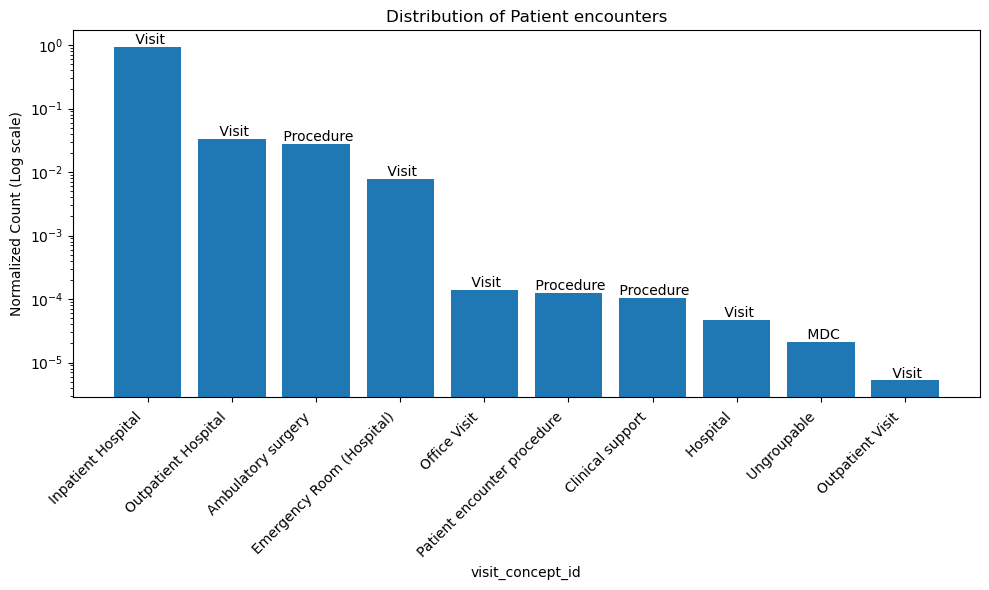

In [245]:
unique_visits = visit_occurrence['visit_concept_id'].unique()
label = {
    8717: 'Inpatient Hospital - Visit',
    8756: 'Outpatient Hospital - Visit',
    4004517: 'Ambulatory surgery - Procedure',
    8870: 'Emergency Room (Hospital) - Visit',
    581477: 'Office Visit - Visit',
    4203722: 'Patient encounter procedure - Procedure',
    44791812: 'Clinical support - Procedure',
    38004515: 'Hospital - Visit',
    0: 'Ungroupable - MDC',
    9202: 'Outpatient Visit - Visit'
}
visit_label = [word.split('-')[0] for word in list(label.values())] 
visit_type = [word.split('-')[1] for word in list(label.values())] 
value_counts = visit_occurrence['visit_concept_id'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(visit_label, value_counts)

# Adding labels and title
plt.xlabel('visit_concept_id')
plt.ylabel('Normalized Count (Log scale)')
plt.title('Distribution of Patient encounters')
plt.yscale('log')

for bar, v_type in zip(bars, visit_type):
    x_pos = bar.get_x() + bar.get_width() / 2 # Adjusted x-coordinate
    y_pos = bar.get_height() / 0.9
    plt.text(x_pos, y_pos, v_type, ha='center')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [246]:
visit_occurrence.groupby('person_id')['visit_start_datetime'].nunique().describe()

count    286.000000
mean      16.895105
std       67.609219
min        1.000000
25%        3.000000
50%        8.000000
75%       13.000000
max      837.000000
Name: visit_start_datetime, dtype: float64

In [247]:
visit_occurrence.loc[visit_occurrence['person_id'] == 175605, ['visit_start_datetime', 'visit_occurrence_id']].head(15)

visit_start_datetime  visit_occurrence_id
190977  2016-02-03 10:23:00             27807625
190978  2016-02-03 10:23:00             27807625
190979  2016-02-03 10:23:00             27807625
190980  2016-05-12 11:00:00             27800762
190981  2016-11-10 09:04:00             27807626
190982  2016-11-10 09:04:00             27807626
190983  2016-11-10 09:04:00             27807626
190984  2016-11-10 09:04:00             27807626
190985  2016-11-10 09:04:00             27807626
190986  2016-11-10 09:04:00             27807626
190987  2016-11-10 09:04:00             27807626
190988  2016-11-10 09:04:00             27807626
190989  2016-11-10 09:04:00             27807626
190990  2016-11-10 09:04:00             27807626
190991  2016-11-10 09:04:00             27807626

In [248]:
led_df = led_df.sort_values(by=['drug_exposure_start_datetime'], ascending=True)

In [249]:
led_df

person_id drug_exposure_start_datetime  \
902       260956          2011-05-18 17:35:00   
903       260956          2011-05-18 21:40:00   
904       260956          2011-05-19 08:19:00   
12421     216583          2011-05-31 17:00:00   
12422     216583          2011-05-31 21:00:00   
...          ...                          ...   
26595     179137          2021-05-04 13:57:00   
26716     176706          2021-05-04 15:02:00   
26717     176706          2021-05-04 21:21:00   
26718     176706          2021-05-05 06:15:00   
26719     176706          2021-05-05 12:54:00   

                                       drug_source_value  \
902    {"med_display_name": "carbidopa-levodopa (SINE...   
903    {"med_display_name": "carbidopa-levodopa (SINE...   
904    {"med_display_name": "carbidopa-levodopa (SINE...   
12421  {"med_display_name": "carbidopa-levodopa (SINE...   
12422  {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
26595  {"med_display_name": "carbidopa-levodopa (SINE...   
26716  {"med_display_name": "carbidopa-levodopa (SINE...   
26717  {"med_display_name": "carbidopa-levodopa (SINE...   
26718  {"med_display_name": "carbidopa-levodopa (SINE...   
26719  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
902    carbidopa-levodopa (SINEMET CR) 50-200 MG per ...  carbidopa-levodopa   
903    carbidopa-levodopa (SINEMET CR) 50-200 MG per ...  carbidopa-levodopa   
904    carbidopa-levodopa (SINEMET CR) 50-200 MG per ...  carbidopa-levodopa   
12421  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
12422  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
26595  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26716  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26717  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26718  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26719  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

       brand_name     dosage  led_dose  dose_source_value  \
902    sinemet cr  50-200 mg     200.0                1.0   
903    sinemet cr  50-200 mg     200.0                1.0   
904    sinemet cr  50-200 mg     200.0                1.0   
12421     sinemet  25-100 mg     100.0                1.0   
12422     sinemet  25-100 mg     100.0                1.0   
...           ...        ...       ...                ...   
26595     sinemet  25-100 mg     100.0                2.0   
26716     sinemet  25-100 mg     100.0                2.0   
26717     sinemet  25-100 mg     100.0                2.0   
26718     sinemet  25-100 mg     100.0                2.0   
26719     sinemet  25-100 mg     100.0                2.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
902                   tablet               ORAL             40366253   
903                   tablet               ORAL             40366253   
904                   tablet               ORAL             40366253   
12421                 tablet               ORAL             33394388   
12422                 tablet               ORAL             33394388   
...                      ...                ...                  ...   
26595                 tablet               ORAL             28470800   
26716                 tablet               ORAL             28046060   
26717                 tablet               ORAL             28046060   
26718                 tablet               ORAL             28046060   
26719                 tablet               ORAL             28046060   

       visit_detail_id    led  
902                NaN  200.0  
903                NaN  200.0  
904                NaN  200.0  
12421     

### Finding Home Medications

In [250]:
from collections import Counter

count_comma = 0
count_asterisc = 0
comma_delimiter = False
target_word = 'Home Medications'
# Add pattern to avoid numbers. Maybe also limit words to 1-3 chars
pattern = r'([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)'
dosage = r'\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml|%))(?:/hr)?'
home_meds_pattern = r"Home Medications:? ([\w\s\d\(\)]+)"

generic_names= []
brand_names = []
target = []
home_meds_note = []
home_meds_portion = []
medications_appearance = ""
bleh = []
after_home_meds = []
rest_note = []
temp = corpus_clean # list(set(corpus_clean))
count = 0

# Goes over corpus_clean (which contains the notes for each patient) and uses a regex to find "Home Medications(:)"
# After that it restricts the note to Home Medications and everything after that

raro = {}
medications_data = []

for index, row in df_pd.iterrows():
    person_id, note_text = row['person_id'], corpus_clean[index]
    raro[index] = {
        'person_id': person_id,
        'note_text': note_text
    }


for index, item in enumerate(temp): # Make sure to sure the whole array next
    match = re.search(home_meds_pattern, item)
    if  match:
        # Little count to see how many notes contain home meds
        count = count + 1
        # Actual index where the word is inside of the string
        word_index = item.find(target_word) 
        # Truncated_note
        home_meds_note.append(item[word_index:])
        # What it actually matches
        home_meds_portion.append(match.group(0))
        # Array contianing the indexes of the notes that contain home meds
        bleh.append(index)

# Replaces the matched portion of home meds for a "". In other words, deletes the matched portion from the array
result = [note.replace(portion, "") for note, portion in zip(home_meds_note, home_meds_portion)]      
# Splits the notes by whitespaces. Note the list comprehension: words is a list of lists that contains words that have been separated by a whitespace
words = [word.split(' ') for word in result]

# Go through the ists of lists and look for the word "Medication". 
# When found concatenate th 2 words prior to the word, the word and the 2 words before the word  
for i, item in enumerate(words):
    for j, word in enumerate(item):
        if "Medications" in word:
            # Avoid getting the word at the end of the array
            if j-2 == -1:
                medications_appearance = " ".join([words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            else:
                medications_appearance = " ".join([words[i][j-2], words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            
            target.append(medications_appearance)
            # if not medications_appearance.startswith("caused by Medications"):
            #     target.append(medications_appearance)
        
        # Get the current word and two more, if it matches any of the 2 key words, attach them to the target array
        # target is a list that contains potential words that are going to be the stopwords.
        multi_word_phrase = " ".join(item[j:j+3])  # Adjust the slice range as needed
        multi_word_phrase_other = " ".join(item[j:j+2])
        if 'Allergies Allergen Reactions' in multi_word_phrase:
            target.append(multi_word_phrase)
        
        if 'Family History' in multi_word_phrase_other:
            target.append(multi_word_phrase_other)

# Here we count how many times a potential stopword is in the array and we sort them by importance
element_counts = Counter(target)
sorted_target = sorted(target, key=lambda x: (-element_counts[x], x))
target_unique = []
seen = set()

for element in sorted_target:
    if element not in seen:
        target_unique.append(element)
        seen.add(element)

whats = []
ble = []
# We iterate from the truncated note up until potential target and count the number of commas and asteriscs so that it can be the delimiter.
# Whatever is higher (commas or astheriscs) is gonna be used to split the string and get the meds
for item in result:
    for stop_word in target_unique:
        if stop_word in item:
            word_index = item.find(stop_word)
            epa = item[:word_index]
            count_comma = epa.count(',')
            count_asterisc = epa.count('*')
            whats.append(epa)
            break
        comma_delimiter = False    
        if count_comma > count_asterisc:
            comma_delimiter = True
        ble.append(comma_delimiter)

# We use the delimiter to separate the string and then ue another regex to find the generic and brand name of the drug    
for index, item in enumerate(whats):
    delimiter = ',' if ble[index] else '*'
    potential_drugs = item.split(delimiter)
    for indo, string in enumerate(potential_drugs):
        drug_name_match = re.findall(pattern, string)
        if drug_name_match:
            # I have to use temp variables beecause tuples are not mutable in Python
            for match in drug_name_match:
                # Removing the words Authorizing Provider and Historical
                if "Authorizing Provider" in match[0]:
                    temp_match = match[0].replace("Authorizing Provider", "")
                elif "Historical" in match[0]:
                    temp_match = match[0].replace("Historical", "")
                else:
                    temp_match = match[0]
                # Making the drug names lowercase and removing whitespaces
                updated_match = (temp_match.lower().strip(), match[1].lower().strip())
                generic_name, brand_name = updated_match
                generic_names.append(generic_name)
                if brand_name:
                    brand_names.append(brand_name)
                else:
                    brand_names.append(np.nan)

                person_id = raro[bleh[index]]['person_id']
                medications_data.append({
                    'person_id': person_id,
                    'index': bleh[index],
                    'generic_name': generic_name,
                    'brand_name': brand_name
                })        

medications_df = pd.DataFrame(medications_data)

In [251]:
medications_df

person_id  index                               generic_name  \
0         261006      0                                  albuterol   
1         261006      0                                        108   
2         261006      0                                   baclofen   
3         261006      0                                  bupropion   
4         261006      0                     carboxymethylcellulose   
...          ...    ...                                        ...   
75160     201787  14016                                   losartan   
75161     201787  14016                                 sertraline   
75162     201787  14016  50 mg tablet take 1 tablet by mouth daily   
75163     201787  14016                                  verapamil   
75164     201787  14016                                  donepezil   

           brand_name  
0           albuterol  
1             90 base  
2            lioresal  
3       wellbutrin xl  
4             refresh  
...               ...  
75160          cozaar  
75161          zoloft  
75162  with breakfast  
75163        calan-sr  
75164         aricept  

[75165 rows x 4 columns]

In [252]:
# Create a boolean mask by applying str.contains() to each element in pd_medications
mask = medications_df['generic_name'].apply(lambda x: any(med in x for med in pd_medication))
# Use the mask to filter medications_df
filtered_df = medications_df[mask]

In [253]:
filtered_df

person_id  index        generic_name  brand_name
35        260996      4         benztropine    cogentin
37        260996      4  carbidopa-levodopa     sinemet
48        260996      5          amantadine   symmetrel
51        260996      5  carbidopa-levodopa  sinemet cr
52        260996      5  carbidopa-levodopa     sinemet
...          ...    ...                 ...         ...
75113     201787  14003  carbidopa-levodopa  sinemet cr
75121     201787  14004  carbidopa-levodopa  sinemet cr
75130     201787  14007  carbidopa-levodopa  sinemet cr
75140     201787  14009  carbidopa-levodopa     sinemet
75149     201787  14012  carbidopa-levodopa  sinemet cr

[6868 rows x 4 columns]

In [254]:
# Replacing manually the instances where the drugs still contain an string before the name
filtered_df.loc[:, 'generic_name'] = filtered_df['generic_name'].replace({
    'do carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c carbidopa-levodopa': 'carbidopa-levodopa',
    'np carbidopa-levodopa': 'carbidopa-levodopa',
    'ap carbidopa-levodopa': 'carbidopa-levodopa',
    '2  carbidopa-levodopa': 'carbidopa-levodopa',
    '2 tabs 3 times daily  carbidopa-levodopa': 'carbidopa-levodopa',
    '1  calcium 500 mg tablet chewable  carbidopa-levodopa': 'carbidopa-levodopa',
    'gastroparesis  carbidopa-levodopa': 'carbidopa-levodopa',
    'yes  information carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c benztropine': 'benztropine',
    'ap ropinirole': 'ropinirole',
    'do ropinirole': 'ropinirole',
    'pa-c ropinirole': 'ropinirole',
    's disease with unknown cause  ropinirole': 'ropinirole',
    'ureteral stone  ropinirole': 'ropinirole',
    'soda coffee or tea daily for bowel movement and then once a week as needed  selegiline': 'selegiline',
    '-levodopa': 'levodopa',
    'ap entacapone': 'entacapone',
    'pa-c selegiline': 'selegiline'
      })

/tmp/ipykernel_42757/1014870408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'generic_name'] = filtered_df['generic_name'].replace({


In [255]:
filtered_df

person_id  index        generic_name  brand_name
35        260996      4         benztropine    cogentin
37        260996      4  carbidopa-levodopa     sinemet
48        260996      5          amantadine   symmetrel
51        260996      5  carbidopa-levodopa  sinemet cr
52        260996      5  carbidopa-levodopa     sinemet
...          ...    ...                 ...         ...
75113     201787  14003  carbidopa-levodopa  sinemet cr
75121     201787  14004  carbidopa-levodopa  sinemet cr
75130     201787  14007  carbidopa-levodopa  sinemet cr
75140     201787  14009  carbidopa-levodopa     sinemet
75149     201787  14012  carbidopa-levodopa  sinemet cr

[6868 rows x 4 columns]

In [256]:
# result_df contains the home medications for each patient
result_df = filtered_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
    'index': lambda x: ', '.join(map(str, x.unique()))
}).reset_index()
result_df = result_df.sort_values(by='person_id', ascending=False)

In [257]:
result_df

person_id                                 generic_name  \
130     260996  amantadine, benztropine, carbidopa-levodopa   
129     260872              carbidopa-levodopa, pramipexole   
128     260789               carbidopa-levodopa, ropinirole   
127     260769                           carbidopa-levodopa   
126     260735                           carbidopa-levodopa   
..         ...                                          ...   
4       202116                           carbidopa-levodopa   
3       202019                           carbidopa-levodopa   
2       202007                           carbidopa-levodopa   
1       201878                           carbidopa-levodopa   
0       201787               carbidopa-levodopa, ropinirole   

                                   brand_name  \
130  cogentin, sinemet, sinemet cr, symmetrel   
129                          mirapex, sinemet   
128                           requip, sinemet   
127                       sinemet, sinemet cr   
126                       sinemet, sinemet cr   
..                                        ...   
4                         sinemet, sinemet cr   
3                         sinemet, sinemet cr   
2                         sinemet, sinemet cr   
1                                     sinemet   
0                 requip, sinemet, sinemet cr   

                                                 index  
130  4, 5, 6, 7, 8, 11, 14, 15, 16, 17, 18, 19, 23,...  
129                                           124, 129  
128  132, 134, 136, 139, 140, 143, 144, 146, 147, 1...  
127                       168, 171, 173, 174, 179, 180  
126                                           185, 190  
..                                                 ...  
4    13534, 13540, 13545, 13549, 13551, 13555, 1356...  
3    13641, 13643, 13644, 13645, 13648, 13649, 1365...  
2    13802, 13803, 13804, 13805, 13806, 13807, 1380...  
1                                         13840, 13841  
0    13844, 13847, 13848, 13849, 13855, 13856, 1385...  

[131 rows x 4 columns]

In [258]:
# resultado contains the generic_name and brand_name for inpatient drugs
resultado = led_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
}).reset_index()
resultado = resultado.sort_values(by='person_id', ascending=False)
resultado_df = resultado[resultado['person_id'].isin(filtered_df['person_id'].unique())]
resultado_df

person_id                                       generic_name  \
284     260996        amantadine, benztropine, carbidopa-levodopa   
281     260872                    carbidopa-levodopa, pramipexole   
280     260789                     carbidopa-levodopa, ropinirole   
279     260769                  benztropine, benztropine mesylate   
278     260735                                 carbidopa-levodopa   
..         ...                                                ...   
65      202116                     carbidopa-levodopa, selegiline   
64      202019                                 carbidopa-levodopa   
63      202007                                 carbidopa-levodopa   
60      201878                                 carbidopa-levodopa   
59      201787  amantadine, carbidopa-levodopa, entacapone, ro...   

                                         brand_name  
284        cogentin, sinemet, sinemet cr, symmetrel  
281                                mirapex, sinemet  
280                                 requip, sinemet  
279                                        cogentin  
278                                         sinemet  
..                                              ...  
65                    eldepryl, sinemet, sinemet cr  
64                                          sinemet  
63                                          sinemet  
60                                          sinemet  
59   comtan, requip, sinemet, sinemet cr, symmetrel  

[131 rows x 3 columns]

In [259]:
comparison_generic_name = pd.merge(result_df[['person_id', 'generic_name']], resultado_df[['person_id', 'generic_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))
comparison_brand_name = pd.merge(result_df[['person_id', 'brand_name']], resultado_df[['person_id', 'brand_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))
# comparison_generic_name.to_csv('comparison_generic_name.csv', index=False)
# comparison_brand_name.to_csv('comparison_brand_name.csv', index=False)

In [260]:
comparison_generic_name

person_id                        generic_name_filtered  \
0       260996  amantadine, benztropine, carbidopa-levodopa   
1       260872              carbidopa-levodopa, pramipexole   
2       260789               carbidopa-levodopa, ropinirole   
3       260769                           carbidopa-levodopa   
4       260735                           carbidopa-levodopa   
..         ...                                          ...   
126     202116                           carbidopa-levodopa   
127     202019                           carbidopa-levodopa   
128     202007                           carbidopa-levodopa   
129     201878                           carbidopa-levodopa   
130     201787               carbidopa-levodopa, ropinirole   

                                      generic_name_led  
0          amantadine, benztropine, carbidopa-levodopa  
1                      carbidopa-levodopa, pramipexole  
2                       carbidopa-levodopa, ropinirole  
3                    benztropine, benztropine mesylate  
4                                   carbidopa-levodopa  
..                                                 ...  
126                     carbidopa-levodopa, selegiline  
127                                 carbidopa-levodopa  
128                                 carbidopa-levodopa  
129                                 carbidopa-levodopa  
130  amantadine, carbidopa-levodopa, entacapone, ro...  

[131 rows x 3 columns]

In [261]:
comparison_brand_name

person_id                       brand_name_filtered  \
0       260996  cogentin, sinemet, sinemet cr, symmetrel   
1       260872                          mirapex, sinemet   
2       260789                           requip, sinemet   
3       260769                       sinemet, sinemet cr   
4       260735                       sinemet, sinemet cr   
..         ...                                       ...   
126     202116                       sinemet, sinemet cr   
127     202019                       sinemet, sinemet cr   
128     202007                       sinemet, sinemet cr   
129     201878                                   sinemet   
130     201787               requip, sinemet, sinemet cr   

                                     brand_name_led  
0          cogentin, sinemet, sinemet cr, symmetrel  
1                                  mirapex, sinemet  
2                                   requip, sinemet  
3                                          cogentin  
4                                           sinemet  
..                                              ...  
126                   eldepryl, sinemet, sinemet cr  
127                                         sinemet  
128                                         sinemet  
129                                         sinemet  
130  comtan, requip, sinemet, sinemet cr, symmetrel  

[131 rows x 3 columns]

In [262]:
# Split the medication lists into sets for comparison
comparison_generic_name['filtered_set'] = comparison_generic_name['generic_name_filtered'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['led_set'] = comparison_generic_name['generic_name_led'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['union'] = comparison_generic_name.apply(lambda row: row['filtered_set'].union(row['led_set']), axis=1)
comparison_generic_name['intersection'] = comparison_generic_name.apply(lambda row: row['filtered_set'].intersection(row['led_set']), axis=1)
comparison_generic_name['match'] = comparison_generic_name.apply(lambda row: round(len(row['intersection']) / len(row['union']) * 100, 0), axis=1)
comparison_generic_name['difference'] = comparison_generic_name.apply(lambda row: row['union'].difference(row['intersection']), axis=1)

In [263]:
comparison_generic_name['match'].describe()

count    131.000000
mean      47.572519
std       33.453074
min        0.000000
25%       25.000000
50%       33.000000
75%       71.000000
max      100.000000
Name: match, dtype: float64

In [264]:
comparison_generic_name['match'].value_counts(normalize=True)

33.0     0.244275
100.0    0.229008
50.0     0.190840
0.0      0.137405
25.0     0.068702
17.0     0.030534
20.0     0.030534
75.0     0.022901
67.0     0.022901
29.0     0.007634
60.0     0.007634
38.0     0.007634
Name: match, dtype: float64

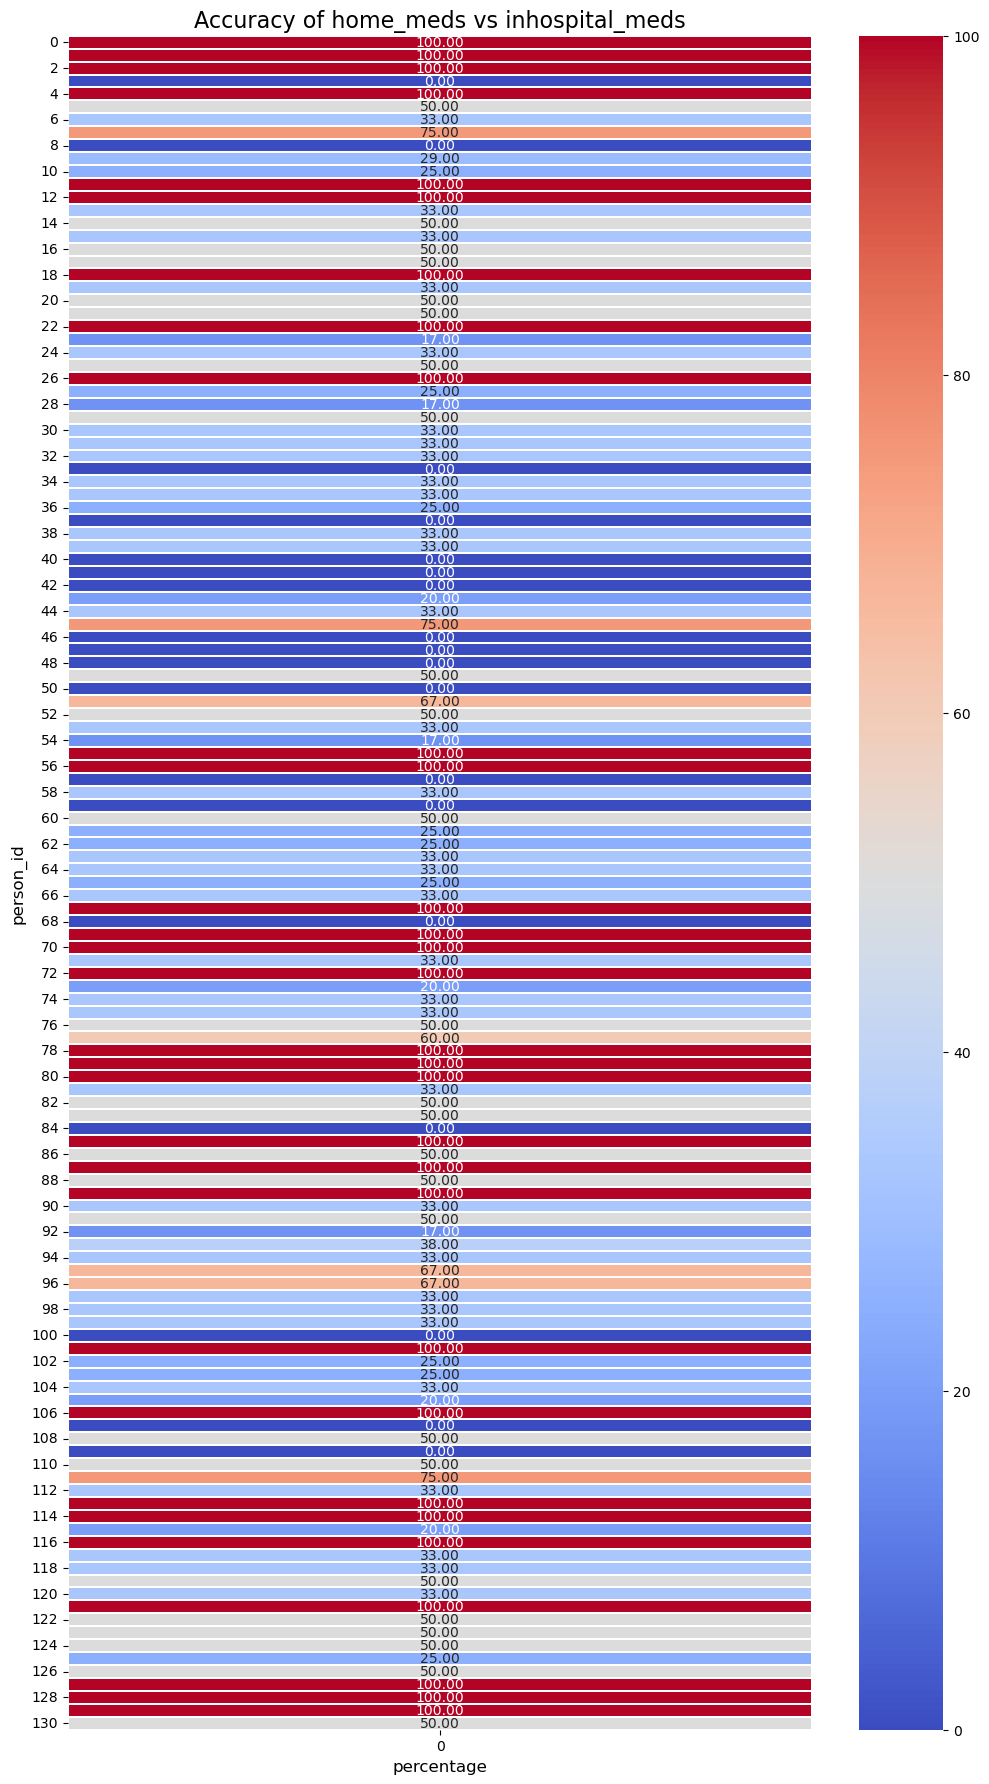

In [265]:
# Transform the matching percentages into a NumPy array
heatmap_data = comparison_generic_name['match'].values.reshape(-1, 1)

# Set the figure size
plt.figure(figsize=(12, 22))

# Create a heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.2)

# Customize the plot
plt.title('Accuracy of home_meds vs inhospital_meds', fontsize=16)
plt.xlabel('percentage', fontsize=12)
plt.ylabel('person_id', fontsize=12)

# Show the plot
plt.show()

In [266]:
comparison_generic_name.describe()

person_id       match
count     131.000000  131.000000
mean   234783.190840   47.572519
std     21272.665555   33.453074
min    201787.000000    0.000000
25%    214688.000000   25.000000
50%    241559.000000   33.000000
75%    254041.000000   71.000000
max    260996.000000  100.000000

Allergies Allergen Reactions, Physical Exam, Family History, Allergies Allergen Reactions

In [267]:
corpus_clean[bleh[60]]

",        6:10 PM Department of Neurology Subspecialty Service: Neurohospitalist Date of Consult:   Subjective:  Reason for request: encephalopathy  is a 66 y.o. female who was admitted for <principal problem not specified>.  This consultation was requested by Dr. . Hx is obtained by the husband and chart. 10 yr hx of Parkinson's, well controlled until Sept. 2012, when pt fell backwards with TBI. This was followed by a coma lasting 2 wks with pt never returning to her baseline mental status and exhibiting pseudobulbar affect. A psychotic depression was unresponsive to meds, requiring ECT in Dec; there was some improvement in the depression, but pt remained abulic, requiring a recent addition of clozapine. Clozapine caused significant hypersomnolence. Pt was admitted after 2 days of hypotension with SBP in the 80's. She has become and remained obtunded, somnolent, moaning, but probably recognizing her husband.  An EEG in Oct showed bitemporal slowing and sharp activity. There have been 

In [268]:
set(corpus_clean)

{'",        9:56 PM   Division of Infectious Disease Consult History & Physical Admit Date:   LOS: 1 day Date of Consult:  Requesting Physician: Dr. Subjective:  is a 59 y.o. female admitted for <principal problem not specified> ID has been consulted for infected neurostimulator Fever monitoring: Temp (24hrs), Avg:36.8 degC (98.2 degF), Min:36.7 degC (98 degF), Max:36.9 degC (98.5 degF) Location: Right chest / neurostimulator Quality:  infection Severity:  mod-severe Duration:  Few days Timing: N/a Context: History obtained from Chart review mostly as patient is difficult to understand. Family member not present at bedside. 59 yo female with H/o Parkinsons disease, H/o Deep brain stimulator initially put in . Looks like it was done at baptist. They started following up with  neurosurgery since . On  Dr.D. Tavanaiepour performed removal of Left deep brain stimulation battery and right deep brain brain stimulation battery replacement. On  patient was transferred from  hospital for R IPG 

In [269]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [270]:
# This person probably had restless leg syndrome or Parkinsonism
led_df.loc[led_df['person_id'] == 258899, ['drug_exposure_start_datetime', 'generic_name']]

drug_exposure_start_datetime        generic_name
1585          2011-12-05 06:25:00         pramipexole
1586          2012-02-06 22:15:00         pramipexole
1587          2012-02-09 11:00:00         pramipexole
1588          2012-02-09 14:46:00         pramipexole
1589          2012-02-09 20:58:00         pramipexole
...                           ...                 ...
1661          2014-02-07 05:52:00         pramipexole
1581          2017-01-07 13:26:00  carbidopa-levodopa
1582          2017-01-07 17:17:00  carbidopa-levodopa
1583          2017-01-07 23:41:00  carbidopa-levodopa
1584          2017-01-08 08:00:00  carbidopa-levodopa

[81 rows x 2 columns]

In [271]:
led_df.groupby('person_id')['visit_occurrence_id'].nunique().sort_values(ascending=False)

person_id
249161    25
256936    24
216583    21
256706    14
208220    12
          ..
235403     1
203512     1
203744     1
203757     1
261006     1
Name: visit_occurrence_id, Length: 286, dtype: int64

In [272]:
visit_occurrence[visit_occurrence['person_id'] == 261006]['visit_occurrence_id'].unique()

array([40382465, 40422617, 40422624, 40384038, 40422625, 40422626,
       40422627, 40382459, 40422628, 40382460, 40382461, 40422629,
       40384085, 40382213, 40382462, 40382466, 40422630, 40422631,
       40422618, 40382464, 40422620, 40382312, 40382316, 40382320,
       40382325, 40422621, 40422622, 40382467, 40422623])

In [273]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [274]:
# So this is critical step in the model. When I drop the duplicates the accuracy drops. But I feel like it's a neccesary step
# The reason why it's dropped is because we are only interested in the visits. led_df already has accurate info on the drugs
visit_occurrence_modified = visit_occurrence.drop(columns=['drug_exposure_start_datetime'])
visit_occurrence_modified.drop_duplicates(inplace=True)

In [275]:
led_df = led_df.merge(visit_occurrence_modified, on=['person_id', 'visit_occurrence_id'], how='inner')

In [276]:
led_df["visit_start_datetime"] = pd.to_datetime(led_df["visit_start_datetime"], format='%Y-%m-%d')
led_df["drug_exposure_start_datetime"] = pd.to_datetime(led_df["drug_exposure_start_datetime"], format='%Y-%m-%d')

In [277]:
time_window = '1M'
mean_led_per_visit = led_df.set_index('visit_start_datetime').groupby('person_id')['led'].resample(time_window).mean().reset_index()
mean_led_per_visit = mean_led_per_visit.rename(columns={'led':'mean_led_per_visit'})
patient_stay['mean_led_per_visit'] = mean_led_per_visit['mean_led_per_visit']

array_temp = mean_led_per_visit['mean_led_per_visit'].to_list()
prediction = [1 if array_temp[i+1] > array_temp[i] else 0 for i in range(len(array_temp)-1)]
# prediction = [1 if array_temp[i + 1] > array_temp[i] else (2 if array_temp[i + 1] == array_temp[i] else 0) for i in range(len(array_temp) - 1)]
prediction.append(0)
mean_led_per_visit['prediction'] = prediction

In [278]:
mean_led_per_visit['prediction'].value_counts(normalize=True)

0    0.917063
1    0.082937
Name: prediction, dtype: float64

In [279]:
mean_led_per_visit = mean_led_per_visit.merge(demographics, on='person_id', how='right')

Length of stay relative to overall visits and not only drug administration

In [280]:
length_of_stay = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg(['min', 'max']).reset_index()
length_of_stay['length_of_stay'] = ((length_of_stay['max'] - length_of_stay['min']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay['days_since_last_visit'] = ((pd.to_datetime('today') - length_of_stay['max']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay.drop(columns=['min', 'max'], inplace=True)

In [281]:
mean_led_per_visit = mean_led_per_visit.merge(length_of_stay, on='person_id', how='right')

In [282]:
aggregations = {'generic_name': lambda x: ', '.join(x), 'dosage': lambda x: ', '.join(x)}
result = led_df.set_index('visit_start_datetime').groupby('person_id').resample(time_window).agg(aggregations).reset_index()
# rolling_window = led_df.set_index('visit_start_datetime').groupby('person_id').resample(time_window)['generic_name'].agg(lambda x: ','.join(x.unique())).reset_index()

In [283]:
# Shit happens
result.iloc[132]

person_id                            194868
visit_start_datetime    2015-03-31 00:00:00
generic_name                               
dosage                                     
Name: 132, dtype: object

In [284]:
epa = []
unique_elements = []

for i in range(len(result)):
    generic_names = result['generic_name'][i].split(', ')
    dosages = result['dosage'][i].split(', ')
    
    visit_drugs = set()
    
    for generic_name, dosage in zip(generic_names, dosages):
        visit_drugs.add(f"{generic_name} {dosage}")

    unique_elements.append(visit_drugs)

mean_led_per_visit['drugs_per_visit'] = [', '.join(visit_drugs) for visit_drugs in unique_elements]

In [285]:
mean_led_per_visit

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0        175605           2017-05-31           62.121212           0   89   
1        175605           2017-08-31           50.000000           1   89   
2        175605           2017-11-30           60.416667           1   89   
3        175744           2020-05-31          100.000000           0   90   
4        176417           2018-11-30          100.000000           0   78   
...         ...                  ...                 ...         ...  ...   
1888     260996           2012-10-31          110.714286           0   76   
1889     260996           2013-01-31           84.040594           0   76   
1890     260996           2013-04-30                 NaN           0   76   
1891     260996           2013-07-31          107.594937           1   76   
1892     261006           2021-04-30          200.000000           0   74   

     gender_source_value race_source_value ethnicity_source_value  \
0                   MALE             OTHER               HISPANIC   
1                   MALE             OTHER               HISPANIC   
2                   MALE             OTHER               HISPANIC   
3                   MALE             WHITE           NOT HISPANIC   
4                   MALE             WHITE           NOT HISPANIC   
...                  ...               ...                    ...   
1888              FEMALE             WHITE           NOT HISPANIC   
1889              FEMALE             WHITE           NOT HISPANIC   
1890              FEMALE             WHITE           NOT HISPANIC   
1891              FEMALE             WHITE           NOT HISPANIC   
1892                MALE             WHITE           NOT HISPANIC   

      length_of_stay  days_since_last_visit  \
0                593                   2239   
1                593                   2239   
2                593                   2239   
3                550                   1275   
4                207                   1759   
...              ...                    ...   
1888            2146                   1896   
1889            2146                   1896   
1890            2146                   1896   
1891            2146                   1896   
1892            3503                    939   

                                        drugs_per_visit  
0     carbidopa-levodopa 12.5-50 mg, carbidopa-levod...  
1                          carbidopa-levodopa 25-100 mg  
2     carbidopa-levodopa 12.5-50 mg, carbidopa-levod...  
3                          carbidopa-levodopa 25-100 mg  
4                          carbidopa-levodopa 25-100 mg  
...                                                 ...  
1888  carbidopa-levodopa 50-200 mg, amantadine 100 m...  
1889   benztropine 0.5 mg, carbidopa-levodopa 25-100 mg  
1890                                                     
1891                       carbidopa-levodopa 25-100 mg  
1892                       carbidopa-levodopa 25-100 mg  

[1893 rows x 11 columns]

In [286]:
mean_led_per_visit['drugs_per_visit'].fillna('None', inplace=True)

In [287]:
# Assesing if they were diagnosed and have poa in the current visit
# Note: These two variables do nothing for the model
mean_led_per_visit['diagnosed_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[diagnosis_date['diagnosis_date'] == row['visit_start_datetime']]['person_id'].values else 0, axis=1)
mean_led_per_visit['poa_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[(diagnosis_date['condition_poa'] == True) & (diagnosis_date['diagnosis_date'] == row['visit_start_datetime'])]['person_id'].values else 0, axis=1)

In [307]:
# Calculating days to diagnosis
# Note: This variable also does nothing for the model
first_visit_per_patient = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg('min').reset_index()
first_visit_diagnosis_date = diagnosis_date.groupby('person_id')['diagnosis_date'].agg('min').reset_index()
days_to_diagnosis = pd.DataFrame()
days_to_diagnosis['person_id'] = first_visit_per_patient['person_id']
days_to_diagnosis['days_to_diagnosis'] = ((first_visit_diagnosis_date['diagnosis_date'] - first_visit_per_patient['visit_start_datetime']) / np.timedelta64(1, 'D')).astype(int)

In [308]:
mean_led_per_visit = mean_led_per_visit.merge(days_to_diagnosis, on='person_id', how='right')

In [312]:
# Note: When I avoid dropping nas accuracy bumps to 91%
# mean_led_per_visit = mean_led_per_visit.dropna()

In [313]:
one_hot_encoding_drugs = pd.get_dummies(mean_led_per_visit['drugs_per_visit'])
mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_drugs], axis=1)
mean_led_per_visit.drop(columns=['drugs_per_visit'], inplace=True)

In [314]:
led_df['dose_unit_source_value'].replace({'Tablet': 'tablet', 'tablet': 'tablet'}, inplace=True)
# apomorphine? something with thius

In [315]:
result_df.drop(columns=['index', 'brand_name'], inplace=True)
result_df = result_df.rename(columns={'generic_name': 'home_meds_generic_name'})
home_meds_patients = result_df['person_id'].unique().tolist()
mean_led_per_visit['home_meds'] = mean_led_per_visit['person_id'].isin(home_meds_patients)
mean_led_per_visit['home_meds'].replace({True: 1, False: 0}, inplace=True)

In [316]:
mean_led_per_visit = mean_led_per_visit.merge(result_df, on='person_id', how='left')

In [317]:
mean_led_per_visit['home_meds_generic_name'].fillna('None', inplace=True)

In [318]:
one_hot_encoding_home_drugs = pd.get_dummies(mean_led_per_visit['home_meds_generic_name'])
# This is in case I decide to only use the generic name from rhw mean_led_per_visit and not a combination of generic name + dosage
# duplicate_columns = mean_led_per_visit.columns[mean_led_per_visit.columns.isin(one_hot_encoding_home_drugs.columns)]
# for column in duplicate_columns:
#     mean_led_per_visit.rename(columns={column: column + '_2'}, inplace=True)
    
mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_home_drugs], axis=1, verify_integrity=True)
mean_led_per_visit.drop(columns=['home_meds_generic_name'], inplace=True)

In [319]:
mean_led_per_visit.drop(columns=['person_id', 'visit_start_datetime'], inplace=True)

In [320]:
file_path = 'acc.txt'
file = open(file_path, 'a')

XGBoost Model

In [339]:
xgboost_df = mean_led_per_visit.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1]
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Parameter previously calculated by doing hyperparameter tuning
# Note: Accuracy drops with L2 regularization and higher depth. A smaller L1 regularization bumps the model
# Note: When I avoid dropping nas in mean_led_per_patient accuracy bumps to 91%
# Note: 
best_params = {
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'reg_alpha': 0.01, # L1 regularization
    'reg_lambda': 0.01, # L2 regularization
    'learning_rate': 0.01, 
    'max_depth': 4, 
    'n_estimators': 300
}

# Create and train the XGBoost model
model = xgb.XGBClassifier(**best_params, verbosity=2, tree_method="hist", device="cuda")
# model = xgb.XGBClassifier(verbosity=2, tree_method="hist", device="cuda")
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("AUC:", accuracy)
file.write(f"AUC XGBoost Model: {accuracy} Time Window: {time_window}\n")

AUC: 0.920844327176781


ValueError: I/O operation on closed file.

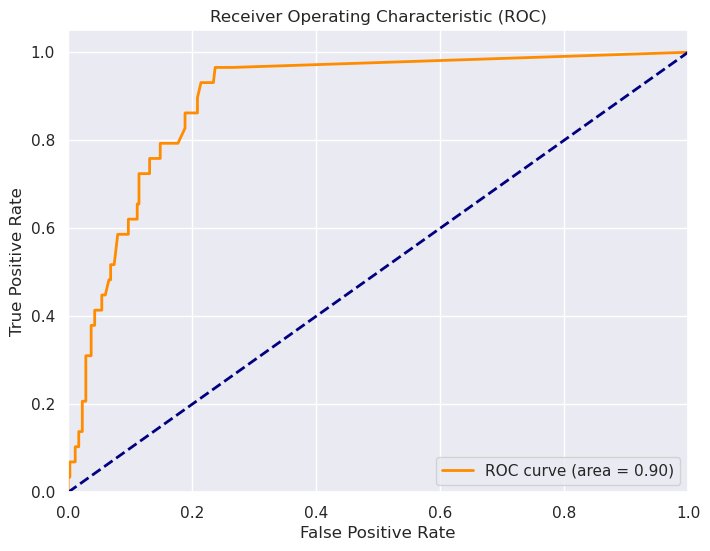

In [340]:
# Calculate the predicted probabilities for class 1 (positive class)
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f'xgboost_roc_{time_window}.png')
plt.show()

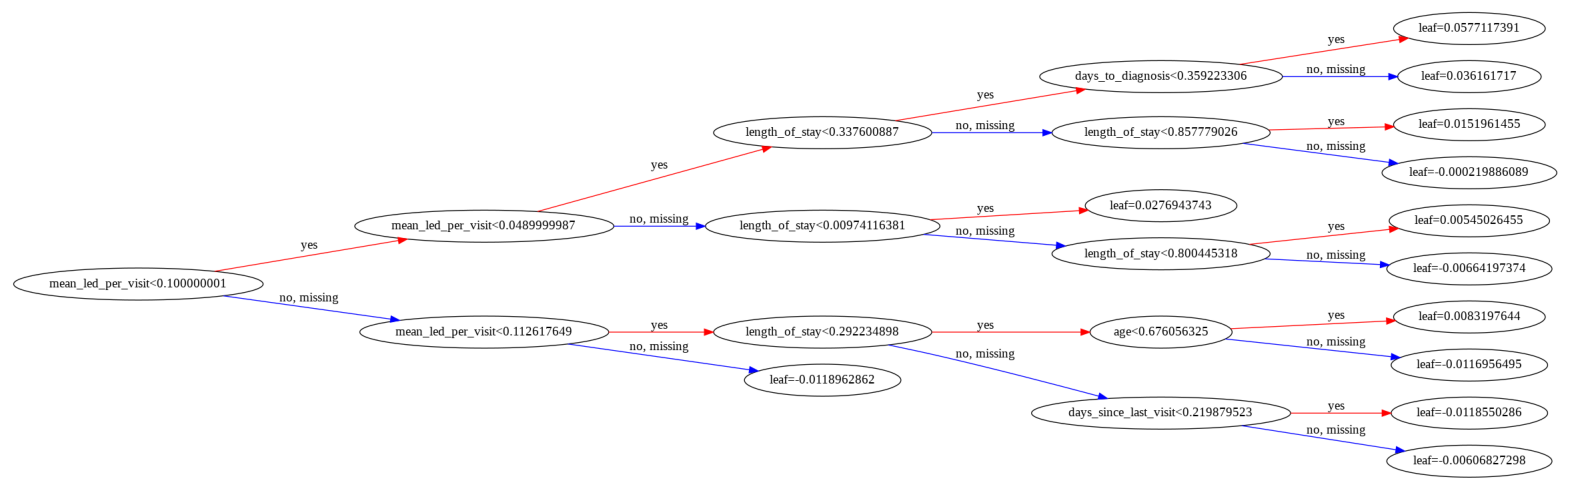

In [323]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(20, 15)
fig.savefig(f'xgboost_tree_{time_window}.png')

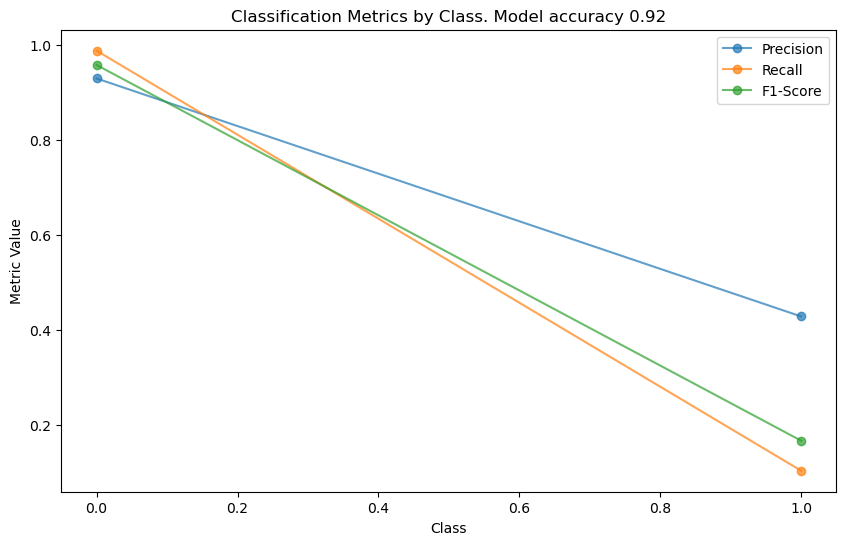

In [324]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    if key.isdigit():
        class_metrics.append([int(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [row[0] for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'XGBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.legend()
plt.grid(True)
plt.savefig(f'xgboost_acc_{time_window}.png')
plt.show()

In [325]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit                                                                                 32.409977
ropinirole 4 mg                                                                                     8.939099
length_of_stay                                                                                      7.326440
carbidopa-levodopa 25-100 mg                                                                        5.865613
home_meds                                                                                           4.838229
                                                                                                     ...    
carbidopa-levodopa 50-200 mg, pramipexole 0.5 mg, carbidopa-levodopa 25-100 mg                      0.000000
carbidopa-levodopa 50-200 mg, pramipexole 1.5 mg, carbidopa-levodopa 25-100 mg                      0.000000
carbidopa-levodopa 50-200 mg, pramipexole 1.5 mg, selegiline 5 mg, carbidopa-levodopa 25-100 mg     0.000000
carbidopa-levodopa 

In [326]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]

In [327]:
non_zero_feature_imp

mean_led_per_visit                                                32.409977
ropinirole 4 mg                                                    8.939099
length_of_stay                                                     7.326440
carbidopa-levodopa 25-100 mg                                       5.865613
home_meds                                                          4.838229
days_since_last_visit                                              4.367863
days_to_diagnosis                                                  4.167547
race_source_value_OTHER                                            4.118402
amantadine, carbidopa-levodopa                                     3.869361
gender_source_value_FEMALE                                         3.661608
amantadine 100 mg, carbidopa-levodopa 25-100 mg                    3.458822
benztropine 1 mg                                                   3.225307
amantadine er, carbidopa-levodopa, pramipexole dihydrochloride     3.161142
age         

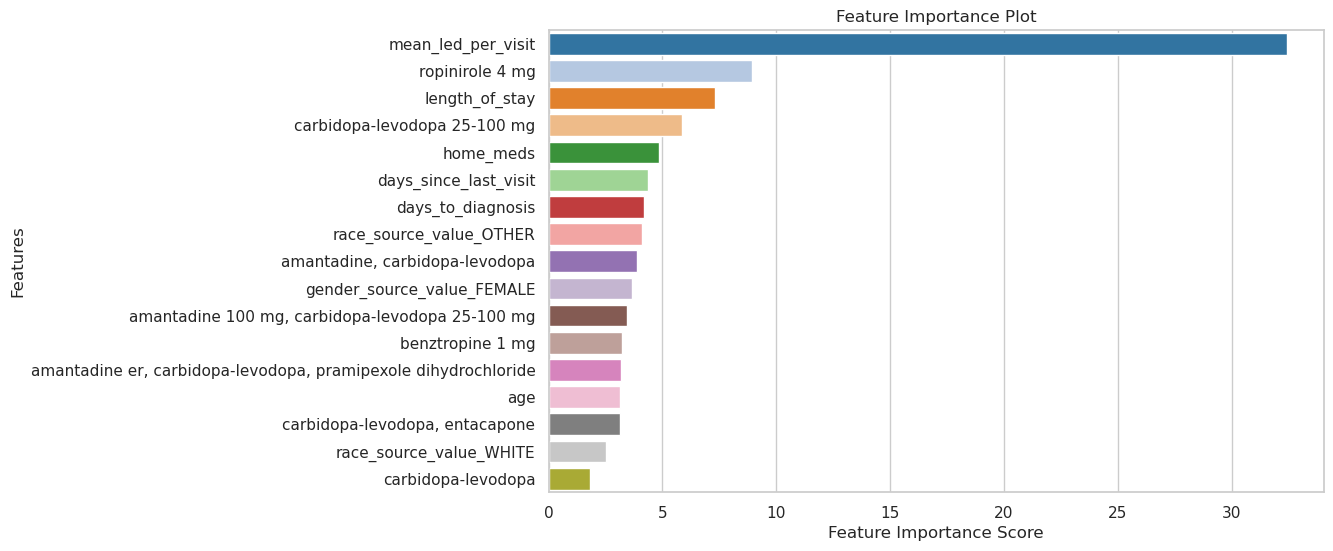

In [328]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'xgboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

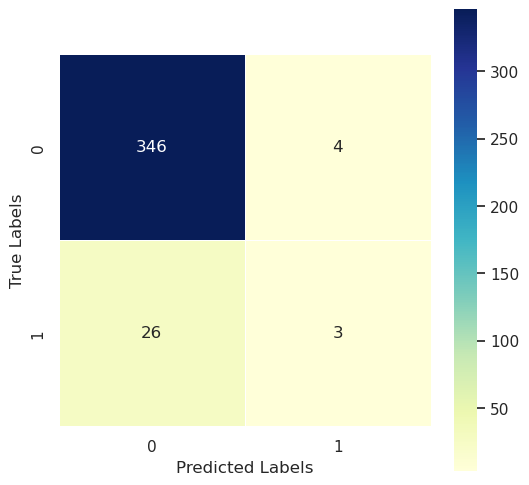

In [329]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('XGBoost Confusion Matrix')
plt.savefig(f'xgboost_confusion_matrix_{time_window}.png')

CatBoost Model

In [330]:
best_params = {
    "loss_function": "Logloss",  # You can choose the appropriate loss function
    "eval_metric": "AUC",  # Area under the curve or other suitable metrics
    "iterations": 300,  # Number of trees
    "learning_rate": 0.01,
    "depth": 4,  # Max depth of trees
    "l2_leaf_reg": 0.01,  # L2 regularization
    "verbose": 100,  # Output verbosity
    "task_type": "GPU",  # If you have a GPU available, use it
}

# Create and train the CatBoost model
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, verbose=True)  # Use verbose=True to see the training process

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("Accuracy:", accuracy)
file.write(f"AUC CatBoost Model: {accuracy} Time Window: {time_window}\n")
file.close()

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.73ms	remaining: 2.91s
1:	total: 17.3ms	remaining: 2.58s
2:	total: 52.5ms	remaining: 5.19s
3:	total: 62ms	remaining: 4.58s
4:	total: 69.5ms	remaining: 4.1s
5:	total: 74.7ms	remaining: 3.66s
6:	total: 81.1ms	remaining: 3.39s
7:	total: 90ms	remaining: 3.29s
8:	total: 120ms	remaining: 3.88s
9:	total: 155ms	remaining: 4.51s
10:	total: 169ms	remaining: 4.43s
11:	total: 175ms	remaining: 4.2s
12:	total: 181ms	remaining: 4s
13:	total: 186ms	remaining: 3.8s
14:	total: 192ms	remaining: 3.65s
15:	total: 220ms	remaining: 3.91s
16:	total: 241ms	remaining: 4.02s
17:	total: 266ms	remaining: 4.17s
18:	total: 280ms	remaining: 4.14s
19:	total: 285ms	remaining: 3.99s
20:	total: 290ms	remaining: 3.86s
21:	total: 295ms	remaining: 3.73s
22:	total: 302ms	remaining: 3.63s
23:	total: 307ms	remaining: 3.54s
24:	total: 324ms	remaining: 3.56s
25:	total: 342ms	remaining: 3.61s
26:	total: 348ms	remaining: 3.52s
27:	total: 378ms	remaining: 3.67s
28:	total: 394ms	remaining: 3.68s
29:	total: 403ms	remaining

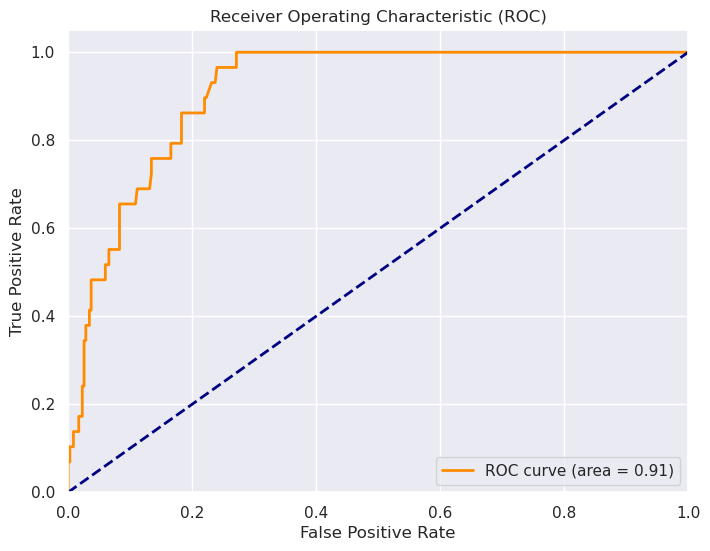

In [331]:
# Calculate the predicted probabilities for class 1 (positive class)
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc='lower right')
plt.savefig(f'catboost_roc_{time_window}.png')
plt.show()

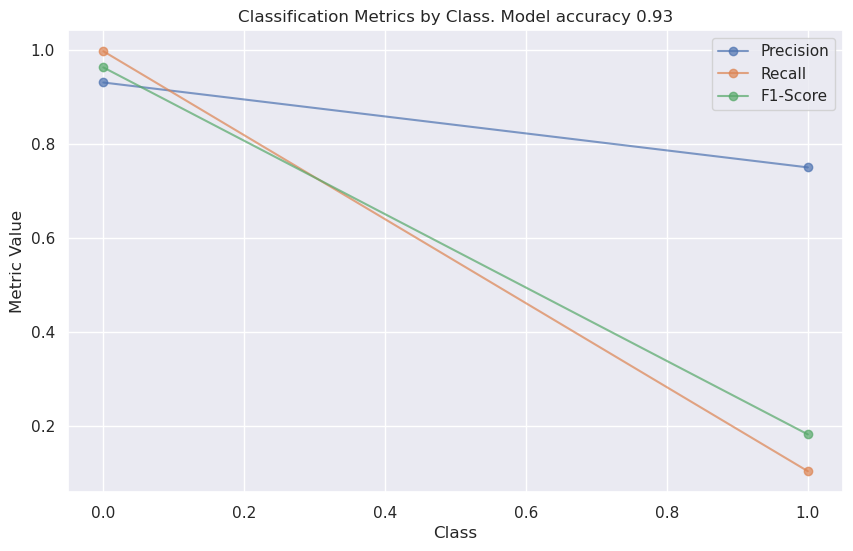

In [332]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    if key.isdigit():
        class_metrics.append([int(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [row[0] for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'CatBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.legend()
plt.savefig(f'catboost_acc_{time_window}.png')
plt.show()

In [333]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit                                                                    44.089234
                                                                                      43.859877
length_of_stay                                                                         2.973081
days_since_last_visit                                                                  1.317589
days_to_diagnosis                                                                      0.956730
                                                                                        ...    
bromocriptine 1.25 mg, carbidopa-levodopa 25-100 mg                                    0.000000
rasagiline mesylate 1 mg, rasagiline mesylate 0.5 mg, carbidopa-levodopa 25-100 mg     0.000000
carbidopa-levodopa 25-100 mg, amantadine 100 mg, carbidopa 25 mg                       0.000000
rasagiline mesylate 1 mg, carbidopa-levodopa 25-100 mg                                 0.000000
benztropine mesylate 2 mg               

In [334]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]

In [335]:
non_zero_feature_imp

mean_led_per_visit       44.089234
                         43.859877
length_of_stay            2.973081
days_since_last_visit     1.317589
dtype: float64

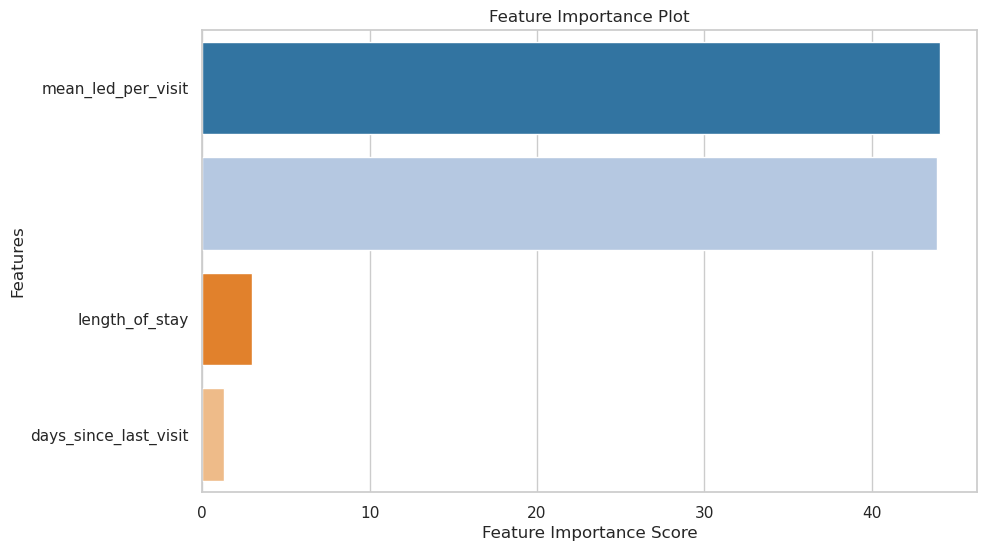

In [336]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'catboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

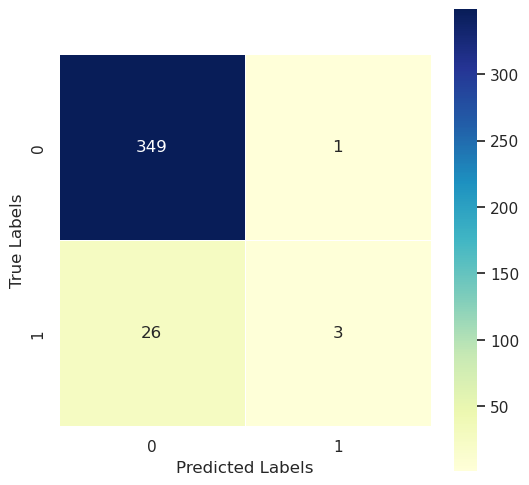

In [337]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('CatBoost Confusion Matrix')
plt.savefig(f'catboost_confusion_matrix_{time_window}.png')

Hyperparameter tuning

In [338]:
# # Define a parameter grid to search
# param_grid = {
#     'max_depth': [4, 5, 6, 7],
#     'learning_rate': [0.1, 0.01, 0.001, 0.0001],
#     'n_estimators': [300, 400, 500, 600, 700, 800],
# }

# # Create an XGBoost classifier
# # model = xgb.XGBClassifier(tree_method='gpu_hist')
# # model = xgb.XGBClassifier()

# # Perform grid search with cross-validation
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
# grid_search = GridSearchCV(model, param_grid, cv=kfold, n_jobs=-1, scoring='roc_auc', verbose=2)
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Train a model with the best hyperparameters
# best_model = xgb.XGBClassifier(**best_params)
# best_model.fit(X_train, y_train)

# # Make predictions and evaluate the best model
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print("Best Hyperparameters:", best_params)
# print("Best Model Accuracy:", accuracy)